In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

## 1.0 Model Function

In [2]:
def buildNN (data, num_hidden_layers = 2, hidden_nodes = 256, act = 'relu', loss_function = 'mean_absolute_error'):
    
    NN_model = Sequential()
    
    # The Input Layer :
    input_layer= Input(shape=(data.shape[1],))
    NN_model.add(input_layer)
    
    # The Hidden Layers :
    for i in range(num_hidden_layers):
        NN_model.add(Dense(hidden_nodes, kernel_initializer='normal',activation=act))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss= loss_function, optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return NN_model

In [65]:
def buildNN_adv (data, num_hidden_layers = 2, hidden_nodes = 256, act = 'relu', do = 0.2, regularizer = True,
                loss_function = 'mean_absolute_error'):
    
    if regularizer:
        reg = tf.keras.regularizers.l2(l=0.01)
    else:
        reg = None
        
    NN_model = Sequential()
    
    # The Input Layer :
    input_layer= Input(shape=(data.shape[1],))
    NN_model.add(input_layer)

    NN_model.add(Dense(hidden_nodes, kernel_initializer='normal',activation=act, kernel_regularizer = reg))
    # The Hidden Layers :
    for i in range(num_hidden_layers-1):
        NN_model.add(Dropout(do))
        NN_model.add(Dense(hidden_nodes, kernel_initializer='normal',activation=act, kernel_regularizer = reg))
        

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss= loss_function, optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return NN_model

In [4]:
def evaluateModel (model, X, y):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    mae = mean_absolute_error(y,y_pred)
    
    return mse, r2, mae

## 2.0 Data

In [5]:
data = pd.read_csv('input/processed_data_nyc.csv', index_col = 0)
data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,all_year_avail,low_avail,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.010635,1,9,2762,0.21,6,True,False,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,5.420535,1,45,2976,0.38,2,True,False,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,5.017280,3,0,0,0.00,1,True,False,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,4.499810,1,270,3021,4.64,1,False,False,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,4.394449,10,9,2793,0.10,1,False,True,...,0,0,0,0,0,0,0,1,0,0


In [6]:
y = data.price
data = data.drop(['price'], axis=1)

X = np.asarray(data).astype(np.float32)
y = np.asarray(y).ravel()

Data Splitting

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Dataset: {}".format(X_train.shape))
print("Testing Dataset: {}".format(X_test.shape))

Training Dataset: (39014, 239)
Testing Dataset: (9754, 239)


Scaling Data:

In [8]:
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 3.0 Testing Neural Network Architectures

### 3.1 Basic Architectures and Activations

In [46]:
EPOCHS = 30
BATCH_SIZE = 256

NUM_LAYERS = [1,2,4,6]
NUM_BASE_NODES = [8,32,128,512]
ACTS = ['tanh','relu']


mse_final = []
mae_final = []
r2_final = []
names = []

for numLayers in NUM_LAYERS:
    for numNodes in NUM_BASE_NODES:
        for act in ACTS:
            LOGNAME = "{}-{}-{}-Epochs={}-TIME={}".format(act,numLayers, numNodes , EPOCHS, int(time.time()) )
            print(LOGNAME)
            tensorboard = TensorBoard(log_dir='logs/NN/basic/{}'.format(LOGNAME))
            nn_model = buildNN(X, num_hidden_layers = numLayers, 
                               hidden_nodes = numNodes,
                               act = act)
            nn_model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
#                          callbacks = [tensorboard],
                        validation_split = 0.2)

            modelName = "{}-{}-{}".format(act,numLayers, numNodes)
            mse, r2, mae = evaluateModel(nn_model, X_test, y_test)

            print('RESULTS:')
            print('MSE = {}, MAE = {}, R2 = {}'.format(mse,mae,r2))

            names.append(modelName)
            mse_final.append(mse)
            mae_final.append(mae)
            r2_final.append(r2)

tanh-1-8-Epochs=30-TIME=1586773609
Train on 31211 samples, validate on 7803 samples
Epoch 1/30
31211/31211 [==============================] - 1s 28us/sample - loss: 4.2386 - mean_absolute_error: 4.2386 - mean_squared_error: 18.6184 - val_loss: 3.5087 - val_mean_absolute_error: 3.5087 - val_mean_squared_error: 12.8940
Epoch 2/30
31211/31211 [==============================] - 1s 18us/sample - loss: 2.7087 - mean_absolute_error: 2.7087 - mean_squared_error: 8.1476 - val_loss: 1.9351 - val_mean_absolute_error: 1.9351 - val_mean_squared_error: 4.3350
Epoch 3/30
31211/31211 [==============================] - 0s 15us/sample - loss: 1.2784 - mean_absolute_error: 1.2784 - mean_squared_error: 2.2918 - val_loss: 0.7788 - val_mean_absolute_error: 0.7788 - val_mean_squared_error: 0.9796
Epoch 4/30
31211/31211 [==============================] - 0s 15us/sample - loss: 0.6512 - mean_absolute_error: 0.6512 - mean_squared_error: 0.6927 - val_loss: 0.5902 - val_mean_absolute_error: 0.5902 - val_mean_squa

KeyboardInterrupt: 

In [23]:
result_df = pd.DataFrame({
    'Model': names,
    'MSE': mse_final,
    'MAE': mae_final,
    'R2': r2_final
})

result_df.to_csv('output/results_NN_basic_architectures.csv', index = False, header=True)

In [25]:
result_df.sort_values(by=['MSE'])

,Model,MSE,MAE,R2
20,tanh-4-128,0.181480,0.310069,0.601654
12,tanh-2-128,0.182446,0.310460,0.599534
2,tanh-1-32,0.182522,0.309438,0.599366
6,tanh-1-512,0.182922,0.314254,0.598489
9,relu-2-8,0.183030,0.312841,0.598251
14,tanh-2-512,0.184014,0.315050,0.596092
4,tanh-1-128,0.184298,0.310319,0.595468
3,relu-1-32,0.185012,0.314980,0.593901
27,relu-6-32,0.185097,0.317924,0.593715
1,relu-1-8,0.185293,0.313316,0.593284


Top 3 Basic Architectures

In [47]:
NN1 = buildNN(X, num_hidden_layers = 4, 
               hidden_nodes = 128,
               act = 'tanh')
NN2 = buildNN(X, num_hidden_layers = 2, 
               hidden_nodes = 128,
               act = 'tanh')
NN3 = buildNN(X, num_hidden_layers = 1, 
               hidden_nodes = 32,
               act = 'tanh')

### 3.2 Advanced Architectures: Dropout and Regularization

In [48]:
NN1_adv = buildNN_adv(X, num_hidden_layers = 4, 
               hidden_nodes = 128,
               act = 'tanh')
NN2_adv = buildNN_adv(X, num_hidden_layers = 2, 
               hidden_nodes = 128,
               act = 'tanh')
NN3_adv = buildNN_adv(X, num_hidden_layers = 1, 
               hidden_nodes = 32,
               act = 'tanh')

Now we will compare the effects of dropout and l2 regularization on the best 3 neural networks

In [51]:
models = [NN1, NN1_adv, NN2, NN2_adv, NN3, NN3_adv]
modelNames = ['NN1', 'NN1_adv', 'NN2', 'NN2_adv', 'NN3', 'NN3_adv']

i = 0
mse_final = []
mae_final = []
r2_final = []

for model in models:
    LOGNAME = "{}-TIME={}".format( modelNames[i] , int(time.time()) )
    print(LOGNAME)
    tensorboard = TensorBoard(log_dir='logs/NN/l2+dropout/{}'.format(LOGNAME))
    
    model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
                         callbacks = [tensorboard],
                validation_split = 0.2)

    mse, r2, mae = evaluateModel(model, X_test, y_test)

    print('RESULTS:')
    print('MSE = {}, MAE = {}, R2 = {}'.format(mse,mae,r2))

    mse_final.append(mse)
    mae_final.append(mae)
    r2_final.append(r2)
    i=i+1

NN1-TIME=1586773950
Train on 31211 samples, validate on 7803 samples
Epoch 1/30
31211/31211 [==============================] - 6s 177us/sample - loss: 0.9497 - mean_absolute_error: 0.9497 - mean_squared_error: 2.2444 - val_loss: 0.5386 - val_mean_absolute_error: 0.5386 - val_mean_squared_error: 0.4622
Epoch 2/30
31211/31211 [==============================] - 3s 106us/sample - loss: 0.4836 - mean_absolute_error: 0.4836 - mean_squared_error: 0.3934 - val_loss: 0.3631 - val_mean_absolute_error: 0.3631 - val_mean_squared_error: 0.2528
Epoch 3/30
31211/31211 [==============================] - 3s 94us/sample - loss: 0.3354 - mean_absolute_error: 0.3354 - mean_squared_error: 0.2153 - val_loss: 0.3326 - val_mean_absolute_error: 0.3326 - val_mean_squared_error: 0.2189
Epoch 4/30
31211/31211 [==============================] - 3s 93us/sample - loss: 0.3249 - mean_absolute_error: 0.3249 - mean_squared_error: 0.2023 - val_loss: 0.3214 - val_mean_absolute_error: 0.3214 - val_mean_squared_error: 0.20

31211/31211 [==============================] - 1s 42us/sample - loss: 0.3169 - mean_absolute_error: 0.3169 - mean_squared_error: 0.1946 - val_loss: 0.3164 - val_mean_absolute_error: 0.3164 - val_mean_squared_error: 0.1919
Epoch 10/30
31211/31211 [==============================] - 1s 43us/sample - loss: 0.3146 - mean_absolute_error: 0.3146 - mean_squared_error: 0.1928 - val_loss: 0.3197 - val_mean_absolute_error: 0.3197 - val_mean_squared_error: 0.1898
Epoch 11/30
31211/31211 [==============================] - 1s 44us/sample - loss: 0.3142 - mean_absolute_error: 0.3142 - mean_squared_error: 0.1922 - val_loss: 0.3170 - val_mean_absolute_error: 0.3170 - val_mean_squared_error: 0.1893
Epoch 12/30
31211/31211 [==============================] - 1s 41us/sample - loss: 0.3141 - mean_absolute_error: 0.3141 - mean_squared_error: 0.1920 - val_loss: 0.3184 - val_mean_absolute_error: 0.3184 - val_mean_squared_error: 0.1904
Epoch 13/30
31211/31211 [==============================] - 1s 42us/sample - 

31211/31211 [==============================] - 1s 31us/sample - loss: 0.3141 - mean_absolute_error: 0.3141 - mean_squared_error: 0.1930 - val_loss: 0.3172 - val_mean_absolute_error: 0.3172 - val_mean_squared_error: 0.1951
Epoch 18/30
31211/31211 [==============================] - 1s 30us/sample - loss: 0.3134 - mean_absolute_error: 0.3134 - mean_squared_error: 0.1922 - val_loss: 0.3160 - val_mean_absolute_error: 0.3160 - val_mean_squared_error: 0.1931
Epoch 19/30
31211/31211 [==============================] - 1s 32us/sample - loss: 0.3127 - mean_absolute_error: 0.3127 - mean_squared_error: 0.1914 - val_loss: 0.3160 - val_mean_absolute_error: 0.3160 - val_mean_squared_error: 0.1927
Epoch 20/30
31211/31211 [==============================] - 1s 38us/sample - loss: 0.3121 - mean_absolute_error: 0.3121 - mean_squared_error: 0.1909 - val_loss: 0.3166 - val_mean_absolute_error: 0.3166 - val_mean_squared_error: 0.1927
Epoch 21/30
31211/31211 [==============================] - 1s 30us/sample - 

In [52]:
result_df2 = pd.DataFrame({
    'Model': modelNames,
    'MSE': mse_final,
    'MAE': mae_final,
    'R2': r2_final
})

result_df2.to_csv('output/results_NN_l2dropout.csv', index = False, header=True)

In [53]:
result_df2

,Model,MSE,MAE,R2
0,NN1,0.192605,0.316263,0.577236
1,NN1_adv,0.208372,0.332500,0.542626
2,NN2,0.181129,0.310853,0.602424
3,NN2_adv,0.200705,0.332482,0.559455
4,NN3,0.184479,0.310669,0.595072
5,NN3_adv,0.205165,0.328617,0.549666


It seems like adding both l2 regularization and dropout lowered the performance of the neural networks. So now we will test 1 network with each on their own. It is also worth noting that the performance of the the same neural networks changed slightly, and NN1 is no longer the best.

In [54]:
NN1_do = buildNN_adv(X, num_hidden_layers = 4, 
               hidden_nodes = 128,
                regularizer=False,
               act = 'tanh')
NN1_l2 = buildNN_adv(X, num_hidden_layers = 4, 
               hidden_nodes = 128,
                     do = 0,
               act = 'tanh')

In [57]:
models = [NN1_do, NN1_l2]


mse_final = []
mae_final = []
r2_final = []

for model in models:
    
    model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
                validation_split = 0.2)

    mse, r2, mae = evaluateModel(model, X_test, y_test)

    print('RESULTS:')
    print('MSE = {}, MAE = {}, R2 = {}'.format(mse,mae,r2))

    mse_final.append(mse)
    mae_final.append(mae)
    r2_final.append(r2)


print("--------- RESULTS -------")
print('Dropout Only: MSE = {}, MAE = {}, R2 = {}'.format(mse_final[0],mae_final[0],r2_final[0]))
print('L2 Regularization Only: MSE = {}, MAE = {}, R2 = {}'.format(mse_final[1],mae_final[1],r2_final[1]))

Train on 31211 samples, validate on 7803 samples
Epoch 1/30
31211/31211 [==============================] - 2s 74us/sample - loss: 1.0218 - mean_absolute_error: 1.0218 - mean_squared_error: 2.4459 - val_loss: 0.5248 - val_mean_absolute_error: 0.5248 - val_mean_squared_error: 0.4379
Epoch 2/30
31211/31211 [==============================] - 6s 208us/sample - loss: 0.4675 - mean_absolute_error: 0.4675 - mean_squared_error: 0.3759 - val_loss: 0.3379 - val_mean_absolute_error: 0.3379 - val_mean_squared_error: 0.2147
Epoch 3/30
31211/31211 [==============================] - 5s 160us/sample - loss: 0.4055 - mean_absolute_error: 0.4055 - mean_squared_error: 0.2888 - val_loss: 0.3299 - val_mean_absolute_error: 0.3299 - val_mean_squared_error: 0.2063
Epoch 4/30
31211/31211 [==============================] - 6s 197us/sample - loss: 0.3938 - mean_absolute_error: 0.3938 - mean_squared_error: 0.2744 - val_loss: 0.3290 - val_mean_absolute_error: 0.3290 - val_mean_squared_error: 0.2097
Epoch 5/30
31211

Based on the above, dropout alone is better than l2 regularization alone. Also, with l2 regularization, the validation loss seems to fluctuate more with training; this might indicate inability to converge.  

Now we will test different percentage of dropout with the top 3 neural networks.

In [68]:
EPOCHS = 30
BATCH_SIZE = 256

do_values = []
mse_final1 = []
mae_final1 = []
r2_final1 = []
mse_final2 = []
mae_final2 = []
r2_final2 = []
mse_final3 = []
mae_final3 = []
r2_final3 = []

for i in range(1,8):
    do_value = i/10
    LOGNAME = "{}-Epochs={}-TIME={}".format(do_value , EPOCHS, int(time.time()) )
    print(LOGNAME)
    tensorboard1 = TensorBoard(log_dir='logs/NN/dropouts/NN1-{}'.format(LOGNAME))
    tensorboard2 = TensorBoard(log_dir='logs/NN/dropouts/NN2-{}'.format(LOGNAME))
    tensorboard3 = TensorBoard(log_dir='logs/NN/dropouts/NN3-{}'.format(LOGNAME))
    
    NN1_adv = buildNN_adv(X, num_hidden_layers = 4, 
                          hidden_nodes = 128,
                          regularizer=False,
                          do = do_value,
                          act = 'tanh')
    NN2_adv = buildNN_adv(X, num_hidden_layers = 2, 
                          hidden_nodes = 128, 
                          regularizer=False,
                          do = do_value,
                          act = 'tanh')
    NN3_adv = buildNN_adv(X, num_hidden_layers = 1, 
                          hidden_nodes = 32,
                          regularizer=False,
                          do = do_value,
                          act = 'tanh')
    
    ## Training Nets
    print("NN1 dropout={}".format(do_value))
    NN1_adv.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
            callbacks = [tensorboard1],
            validation_split = 0.2)
    print("NN2 dropout={}".format(do_value))
    NN2_adv.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
            callbacks = [tensorboard2],
            validation_split = 0.2)
    print("NN3 dropout={}".format(do_value))
    NN3_adv.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
            callbacks = [tensorboard3],
            validation_split = 0.2)
    
    ## Evaluating Nets
    mse_1, r2_1, mae_1 = evaluateModel(NN1_adv, X_test, y_test)
    mse_2, r2_2, mae_2 = evaluateModel(NN2_adv, X_test, y_test)
    mse_3, r2_3, mae_3 = evaluateModel(NN3_adv, X_test, y_test)
    
    print('RESULTS ----- Dropout = {}-------'.format(do_value))
    print('NN1: MSE = {}, MAE = {}, R2 = {}'.format(mse_1,mae_1,r2_1))
    print('NN2: MSE = {}, MAE = {}, R2 = {}'.format(mse_2,mae_3,r2_2))
    print('NN3: MSE = {}, MAE = {}, R2 = {}'.format(mse_3,mae_3,r2_3))
    
    ## Recording results in lists
    do_values.append(do_value)
    mse_final1.append(mse_1)
    mae_final1.append(mae_1)
    r2_final1.append(r2_1)
    mse_final2.append(mse_2)
    mae_final2.append(mae_2)
    r2_final2.append(r2_2)
    mse_final3.append(mse_3)
    mae_final3.append(mae_3)
    r2_final3.append(r2_3)

0.1-Epochs=30-TIME=1586776356
NN1 dropout=0.1
Train on 31211 samples, validate on 7803 samples
Epoch 1/30
31211/31211 [==============================] - 6s 176us/sample - loss: 0.9749 - mean_absolute_error: 0.9749 - mean_squared_error: 2.2651 - val_loss: 0.4849 - val_mean_absolute_error: 0.4849 - val_mean_squared_error: 0.3903
Epoch 2/30
31211/31211 [==============================] - 4s 142us/sample - loss: 0.4081 - mean_absolute_error: 0.4081 - mean_squared_error: 0.2978 - val_loss: 0.3492 - val_mean_absolute_error: 0.3492 - val_mean_squared_error: 0.2125
Epoch 3/30
31211/31211 [==============================] - 4s 135us/sample - loss: 0.3733 - mean_absolute_error: 0.3733 - mean_squared_error: 0.2517 - val_loss: 0.3257 - val_mean_absolute_error: 0.3257 - val_mean_squared_error: 0.2020
Epoch 4/30
31211/31211 [==============================] - 4s 122us/sample - loss: 0.3663 - mean_absolute_error: 0.3663 - mean_squared_error: 0.2432 - val_loss: 0.3269 - val_mean_absolute_error: 0.3269 - 

Epoch 10/30
31211/31211 [==============================] - 1s 44us/sample - loss: 0.4011 - mean_absolute_error: 0.4011 - mean_squared_error: 0.2848 - val_loss: 0.3259 - val_mean_absolute_error: 0.3259 - val_mean_squared_error: 0.2054
Epoch 11/30
31211/31211 [==============================] - 2s 49us/sample - loss: 0.4007 - mean_absolute_error: 0.4007 - mean_squared_error: 0.2831 - val_loss: 0.3237 - val_mean_absolute_error: 0.3237 - val_mean_squared_error: 0.2046
Epoch 12/30
31211/31211 [==============================] - 1s 44us/sample - loss: 0.3962 - mean_absolute_error: 0.3962 - mean_squared_error: 0.2782 - val_loss: 0.3231 - val_mean_absolute_error: 0.3231 - val_mean_squared_error: 0.1998
Epoch 13/30
31211/31211 [==============================] - 2s 62us/sample - loss: 0.3965 - mean_absolute_error: 0.3965 - mean_squared_error: 0.2783 - val_loss: 0.3216 - val_mean_absolute_error: 0.3216 - val_mean_squared_error: 0.2006
Epoch 14/30
31211/31211 [==============================] - 1s 40

Epoch 18/30
31211/31211 [==============================] - 4s 137us/sample - loss: 0.3666 - mean_absolute_error: 0.3666 - mean_squared_error: 0.2450 - val_loss: 0.3261 - val_mean_absolute_error: 0.3261 - val_mean_squared_error: 0.2113
Epoch 19/30
31211/31211 [==============================] - 2s 71us/sample - loss: 0.3673 - mean_absolute_error: 0.3673 - mean_squared_error: 0.2461 - val_loss: 0.3200 - val_mean_absolute_error: 0.3200 - val_mean_squared_error: 0.1976
Epoch 20/30
31211/31211 [==============================] - 2s 79us/sample - loss: 0.3670 - mean_absolute_error: 0.3670 - mean_squared_error: 0.2443 - val_loss: 0.3207 - val_mean_absolute_error: 0.3207 - val_mean_squared_error: 0.1938
Epoch 21/30
31211/31211 [==============================] - 2s 76us/sample - loss: 0.3643 - mean_absolute_error: 0.3643 - mean_squared_error: 0.2429 - val_loss: 0.3171 - val_mean_absolute_error: 0.3171 - val_mean_squared_error: 0.1962
Epoch 22/30
31211/31211 [==============================] - 2s 7

Epoch 23/30
31211/31211 [==============================] - 1s 34us/sample - loss: 0.4396 - mean_absolute_error: 0.4396 - mean_squared_error: 0.3330 - val_loss: 0.3245 - val_mean_absolute_error: 0.3245 - val_mean_squared_error: 0.2030
Epoch 24/30
31211/31211 [==============================] - 1s 38us/sample - loss: 0.4337 - mean_absolute_error: 0.4337 - mean_squared_error: 0.3248 - val_loss: 0.3227 - val_mean_absolute_error: 0.3227 - val_mean_squared_error: 0.2010
Epoch 25/30
31211/31211 [==============================] - 1s 38us/sample - loss: 0.4312 - mean_absolute_error: 0.4312 - mean_squared_error: 0.3227 - val_loss: 0.3252 - val_mean_absolute_error: 0.3252 - val_mean_squared_error: 0.2083
Epoch 26/30
31211/31211 [==============================] - 1s 34us/sample - loss: 0.4291 - mean_absolute_error: 0.4291 - mean_squared_error: 0.3201 - val_loss: 0.3212 - val_mean_absolute_error: 0.3212 - val_mean_squared_error: 0.1982
Epoch 27/30
31211/31211 [==============================] - 1s 34

NN3 dropout=0.3
Train on 31211 samples, validate on 7803 samples
Epoch 1/30
31211/31211 [==============================] - 1s 36us/sample - loss: 3.0480 - mean_absolute_error: 3.0480 - mean_squared_error: 11.6335 - val_loss: 1.1061 - val_mean_absolute_error: 1.1061 - val_mean_squared_error: 1.9771
Epoch 2/30
31211/31211 [==============================] - 1s 23us/sample - loss: 1.0193 - mean_absolute_error: 1.0193 - mean_squared_error: 1.6240 - val_loss: 0.7936 - val_mean_absolute_error: 0.7936 - val_mean_squared_error: 0.9970
Epoch 3/30
31211/31211 [==============================] - 1s 26us/sample - loss: 0.8366 - mean_absolute_error: 0.8366 - mean_squared_error: 1.1046 - val_loss: 0.6291 - val_mean_absolute_error: 0.6291 - val_mean_squared_error: 0.6397
Epoch 4/30
31211/31211 [==============================] - 1s 30us/sample - loss: 0.7063 - mean_absolute_error: 0.7063 - mean_squared_error: 0.8079 - val_loss: 0.4795 - val_mean_absolute_error: 0.4795 - val_mean_squared_error: 0.3996
Ep

Epoch 9/30
31211/31211 [==============================] - 1s 43us/sample - loss: 0.4383 - mean_absolute_error: 0.4383 - mean_squared_error: 0.3314 - val_loss: 0.3290 - val_mean_absolute_error: 0.3290 - val_mean_squared_error: 0.2147
Epoch 10/30
31211/31211 [==============================] - 1s 46us/sample - loss: 0.4370 - mean_absolute_error: 0.4370 - mean_squared_error: 0.3327 - val_loss: 0.3262 - val_mean_absolute_error: 0.3262 - val_mean_squared_error: 0.2066
Epoch 11/30
31211/31211 [==============================] - 1s 46us/sample - loss: 0.4355 - mean_absolute_error: 0.4355 - mean_squared_error: 0.3264 - val_loss: 0.3280 - val_mean_absolute_error: 0.3280 - val_mean_squared_error: 0.2103
Epoch 12/30
31211/31211 [==============================] - 1s 43us/sample - loss: 0.4346 - mean_absolute_error: 0.4346 - mean_squared_error: 0.3250 - val_loss: 0.3299 - val_mean_absolute_error: 0.3299 - val_mean_squared_error: 0.2061
Epoch 13/30
31211/31211 [==============================] - 1s 46u

Epoch 14/30
31211/31211 [==============================] - 1s 24us/sample - loss: 0.5883 - mean_absolute_error: 0.5883 - mean_squared_error: 0.5734 - val_loss: 0.3277 - val_mean_absolute_error: 0.3277 - val_mean_squared_error: 0.2091
Epoch 15/30
31211/31211 [==============================] - 1s 24us/sample - loss: 0.5853 - mean_absolute_error: 0.5853 - mean_squared_error: 0.5666 - val_loss: 0.3310 - val_mean_absolute_error: 0.3310 - val_mean_squared_error: 0.2142
Epoch 16/30
31211/31211 [==============================] - 1s 26us/sample - loss: 0.5742 - mean_absolute_error: 0.5742 - mean_squared_error: 0.5434 - val_loss: 0.3301 - val_mean_absolute_error: 0.3301 - val_mean_squared_error: 0.2123
Epoch 17/30
31211/31211 [==============================] - 1s 25us/sample - loss: 0.5681 - mean_absolute_error: 0.5681 - mean_squared_error: 0.5351 - val_loss: 0.3317 - val_mean_absolute_error: 0.3317 - val_mean_squared_error: 0.2211
Epoch 18/30
31211/31211 [==============================] - 1s 25

Epoch 22/30
31211/31211 [==============================] - 2s 74us/sample - loss: 0.4416 - mean_absolute_error: 0.4416 - mean_squared_error: 0.3383 - val_loss: 0.3269 - val_mean_absolute_error: 0.3269 - val_mean_squared_error: 0.2106
Epoch 23/30
31211/31211 [==============================] - 2s 70us/sample - loss: 0.4376 - mean_absolute_error: 0.4376 - mean_squared_error: 0.3313 - val_loss: 0.3283 - val_mean_absolute_error: 0.3283 - val_mean_squared_error: 0.2001
Epoch 24/30
31211/31211 [==============================] - 2s 69us/sample - loss: 0.4367 - mean_absolute_error: 0.4367 - mean_squared_error: 0.3313 - val_loss: 0.3283 - val_mean_absolute_error: 0.3283 - val_mean_squared_error: 0.2049
Epoch 25/30
31211/31211 [==============================] - 2s 74us/sample - loss: 0.4345 - mean_absolute_error: 0.4345 - mean_squared_error: 0.3257 - val_loss: 0.3293 - val_mean_absolute_error: 0.3293 - val_mean_squared_error: 0.2024
Epoch 26/30
31211/31211 [==============================] - 1s 43

Epoch 27/30
31211/31211 [==============================] - 1s 27us/sample - loss: 0.5352 - mean_absolute_error: 0.5352 - mean_squared_error: 0.4852 - val_loss: 0.3321 - val_mean_absolute_error: 0.3321 - val_mean_squared_error: 0.2146
Epoch 28/30
31211/31211 [==============================] - 1s 28us/sample - loss: 0.5273 - mean_absolute_error: 0.5273 - mean_squared_error: 0.4685 - val_loss: 0.3318 - val_mean_absolute_error: 0.3318 - val_mean_squared_error: 0.2175
Epoch 29/30
31211/31211 [==============================] - 1s 24us/sample - loss: 0.5178 - mean_absolute_error: 0.5178 - mean_squared_error: 0.4536 - val_loss: 0.3346 - val_mean_absolute_error: 0.3346 - val_mean_squared_error: 0.2214
Epoch 30/30
31211/31211 [==============================] - 1s 25us/sample - loss: 0.5049 - mean_absolute_error: 0.5049 - mean_squared_error: 0.4376 - val_loss: 0.3269 - val_mean_absolute_error: 0.3269 - val_mean_squared_error: 0.2086
RESULTS ----- Dropout = 0.5-------
NN1: MSE = 0.2052009510812691

Epoch 27/30
31211/31211 [==============================] - 5s 167us/sample - loss: 0.4706 - mean_absolute_error: 0.4706 - mean_squared_error: 0.3765 - val_loss: 0.3401 - val_mean_absolute_error: 0.3401 - val_mean_squared_error: 0.2255
Epoch 28/30
31211/31211 [==============================] - 4s 130us/sample - loss: 0.4698 - mean_absolute_error: 0.4698 - mean_squared_error: 0.3751 - val_loss: 0.3343 - val_mean_absolute_error: 0.3343 - val_mean_squared_error: 0.2082
Epoch 29/30
31211/31211 [==============================] - 4s 131us/sample - loss: 0.4632 - mean_absolute_error: 0.4632 - mean_squared_error: 0.3669 - val_loss: 0.3350 - val_mean_absolute_error: 0.3350 - val_mean_squared_error: 0.2196
Epoch 30/30
31211/31211 [==============================] - 4s 124us/sample - loss: 0.4603 - mean_absolute_error: 0.4603 - mean_squared_error: 0.3625 - val_loss: 0.3380 - val_mean_absolute_error: 0.3380 - val_mean_squared_error: 0.2218
NN2 dropout=0.6
Train on 31211 samples, validate on 7803 sam

31211/31211 [==============================] - 3s 105us/sample - loss: 0.7312 - mean_absolute_error: 0.7312 - mean_squared_error: 0.8503 - val_loss: 0.5382 - val_mean_absolute_error: 0.5382 - val_mean_squared_error: 0.4543
Epoch 5/30
31211/31211 [==============================] - 3s 82us/sample - loss: 0.7249 - mean_absolute_error: 0.7249 - mean_squared_error: 0.8377 - val_loss: 0.5334 - val_mean_absolute_error: 0.5334 - val_mean_squared_error: 0.4490
Epoch 6/30
31211/31211 [==============================] - 2s 54us/sample - loss: 0.7072 - mean_absolute_error: 0.7072 - mean_squared_error: 0.8033 - val_loss: 0.4206 - val_mean_absolute_error: 0.4206 - val_mean_squared_error: 0.3003
Epoch 7/30
31211/31211 [==============================] - 2s 53us/sample - loss: 0.6634 - mean_absolute_error: 0.6634 - mean_squared_error: 0.7134 - val_loss: 0.3742 - val_mean_absolute_error: 0.3742 - val_mean_squared_error: 0.2659
Epoch 8/30
31211/31211 [==============================] - 2s 54us/sample - los

Epoch 9/30
31211/31211 [==============================] - 1s 32us/sample - loss: 0.6013 - mean_absolute_error: 0.6013 - mean_squared_error: 0.5928 - val_loss: 0.3432 - val_mean_absolute_error: 0.3432 - val_mean_squared_error: 0.2268
Epoch 10/30
31211/31211 [==============================] - 4s 137us/sample - loss: 0.5971 - mean_absolute_error: 0.5971 - mean_squared_error: 0.5851 - val_loss: 0.3409 - val_mean_absolute_error: 0.3409 - val_mean_squared_error: 0.2216
Epoch 11/30
31211/31211 [==============================] - 3s 80us/sample - loss: 0.5897 - mean_absolute_error: 0.5897 - mean_squared_error: 0.5710 - val_loss: 0.3491 - val_mean_absolute_error: 0.3491 - val_mean_squared_error: 0.2206
Epoch 12/30
31211/31211 [==============================] - 3s 84us/sample - loss: 0.5885 - mean_absolute_error: 0.5885 - mean_squared_error: 0.5679 - val_loss: 0.3440 - val_mean_absolute_error: 0.3440 - val_mean_squared_error: 0.2226
Epoch 13/30
31211/31211 [==============================] - 2s 78

Epoch 14/30
31211/31211 [==============================] - 1s 28us/sample - loss: 0.8877 - mean_absolute_error: 0.8877 - mean_squared_error: 1.2582 - val_loss: 0.4141 - val_mean_absolute_error: 0.4141 - val_mean_squared_error: 0.3226
Epoch 15/30
31211/31211 [==============================] - 1s 25us/sample - loss: 0.8590 - mean_absolute_error: 0.8590 - mean_squared_error: 1.1799 - val_loss: 0.3675 - val_mean_absolute_error: 0.3675 - val_mean_squared_error: 0.2651
Epoch 16/30
31211/31211 [==============================] - 1s 24us/sample - loss: 0.8380 - mean_absolute_error: 0.8380 - mean_squared_error: 1.1273 - val_loss: 0.3622 - val_mean_absolute_error: 0.3622 - val_mean_squared_error: 0.2592
Epoch 17/30
31211/31211 [==============================] - 1s 23us/sample - loss: 0.8201 - mean_absolute_error: 0.8201 - mean_squared_error: 1.0785 - val_loss: 0.3766 - val_mean_absolute_error: 0.3766 - val_mean_squared_error: 0.2784
Epoch 18/30
31211/31211 [==============================] - 1s 29

In [69]:
result_df3 = pd.DataFrame({
    'Dropout': do_values,
    'MSE_NN1': mse_final1,
    'MAE_NN1': mae_final1,
    'R2_NN1': r2_final1,
    'MSE_NN2': mse_final2,
    'MAE_NN2': mae_final2,
    'R2_NN2': r2_final2,
    'MSE_NN3': mse_final3,
    'MAE_NN3': mae_final3,
    'R2_NN3': r2_final3
})

result_df3.to_csv('output/results_NN_dropouts.csv', index = False, header=True)

In [70]:
result_df3

,Dropout,MSE_NN1,MAE_NN1,R2_NN1,MSE_NN2,MAE_NN2,R2_NN2,MSE_NN3,MAE_NN3,R2_NN3
0,0.1,0.188088,0.314048,0.587149,0.184591,0.313270,0.594824,0.192886,0.317882,0.576617
1,0.2,0.188525,0.317429,0.586190,0.186366,0.316387,0.590929,0.191859,0.320603,0.578871
2,0.3,0.196201,0.334846,0.569342,0.190619,0.317520,0.581595,0.196032,0.321497,0.569713
3,0.4,0.193154,0.323390,0.576029,0.216943,0.334900,0.523813,0.207691,0.329203,0.544121
4,0.5,0.205201,0.327363,0.549587,0.197931,0.326285,0.565544,0.202977,0.326741,0.554469
5,0.6,0.214896,0.335861,0.528307,0.203764,0.326412,0.552741,0.215549,0.334226,0.526873
6,0.7,0.213259,0.343493,0.531900,0.200894,0.329107,0.559041,0.224347,0.341262,0.507561


Based on the results above, we can see that increasing the dropout had negative impact on model performance. So we will choose a dropout of 0.1. Even though small dropout does not seem to have an effect on the numerical results, it is still expected to improve generalization on unseen data; therefore, it will be used in our neural nets.

### 3.3 Testing Loss Functions

Here we will test the top 3 neural networks from earlier with different loss functions and compare the results.

In [9]:
EPOCHS = 100
BATCH_SIZE = 256

LOSSES = ['mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']

losses = []
mse_final1 = []
mae_final1 = []
r2_final1 = []
mse_final2 = []
mae_final2 = []
r2_final2 = []
mse_final3 = []
mae_final3 = []
r2_final3 = []

for loss in LOSSES:
    LOGNAME = "{}-Epochs={}-TIME={}".format(loss , EPOCHS, int(time.time()) )
    print(LOGNAME)
    tensorboard1 = TensorBoard(log_dir='logs/NN/losses/NN1-{}'.format(LOGNAME))
    tensorboard2 = TensorBoard(log_dir='logs/NN/losses/NN2-{}'.format(LOGNAME))
    tensorboard3 = TensorBoard(log_dir='logs/NN/losses/NN3-{}'.format(LOGNAME))
    
    NN1_adv = buildNN_adv(X, num_hidden_layers = 4, 
                          hidden_nodes = 128,
                          regularizer=False,
                          do = 0.1,
                          loss_function = loss,
                          act = 'tanh')
    NN2_adv = buildNN_adv(X, num_hidden_layers = 2, 
                          hidden_nodes = 128, 
                          regularizer=False,
                          do = 0.1,
                          loss_function = loss,
                          act = 'tanh')
    NN3_adv = buildNN_adv(X, num_hidden_layers = 1, 
                          hidden_nodes = 32,
                          regularizer=False,
                          do = 0.1,
                          loss_function = loss,
                          act = 'tanh')
    
    ## Training Nets
    print("NN1 with {}".format(loss))
    NN1_adv.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
            callbacks = [tensorboard1],
            validation_split = 0.2)
    print("NN2 with {}".format(loss))
    NN2_adv.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
            callbacks = [tensorboard2],
            validation_split = 0.2)
    print("NN3 with {}".format(loss))
    NN3_adv.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
            callbacks = [tensorboard3],
            validation_split = 0.2)
    
    ## Evaluating Nets
    mse_1, r2_1, mae_1 = evaluateModel(NN1_adv, X_test, y_test)
    mse_2, r2_2, mae_2 = evaluateModel(NN2_adv, X_test, y_test)
    mse_3, r2_3, mae_3 = evaluateModel(NN3_adv, X_test, y_test)
    
    print('RESULTS ----- Loss = {} -------'.format(loss))
    print('NN1: MSE = {}, MAE = {}, R2 = {}'.format(mse_1,mae_1,r2_1))
    print('NN2: MSE = {}, MAE = {}, R2 = {}'.format(mse_2,mae_3,r2_2))
    print('NN3: MSE = {}, MAE = {}, R2 = {}'.format(mse_3,mae_3,r2_3))
    
    ## Recording results in lists
    losses.append(loss)
    mse_final1.append(mse_1)
    mae_final1.append(mae_1)
    r2_final1.append(r2_1)
    mse_final2.append(mse_2)
    mae_final2.append(mae_2)
    r2_final2.append(r2_2)
    mse_final3.append(mse_3)
    mae_final3.append(mae_3)
    r2_final3.append(r2_3)

mean_absolute_error-Epochs=100-TIME=1586810393
NN1 with mean_absolute_error
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 6s 203us/sample - loss: 1.0088 - mean_absolute_error: 1.0088 - mean_squared_error: 2.4437 - val_loss: 0.5213 - val_mean_absolute_error: 0.5213 - val_mean_squared_error: 0.4373
Epoch 2/100
31211/31211 [==============================] - 4s 126us/sample - loss: 0.4298 - mean_absolute_error: 0.4298 - mean_squared_error: 0.3287 - val_loss: 0.3422 - val_mean_absolute_error: 0.3422 - val_mean_squared_error: 0.2170
Epoch 3/100
31211/31211 [==============================] - 4s 119us/sample - loss: 0.3737 - mean_absolute_error: 0.3737 - mean_squared_error: 0.2528 - val_loss: 0.3408 - val_mean_absolute_error: 0.3408 - val_mean_squared_error: 0.2285
Epoch 4/100
31211/31211 [==============================] - 4s 115us/sample - loss: 0.3615 - mean_absolute_error: 0.3615 - mean_squared_error: 0.2399 - val_loss: 0.3232 - 

31211/31211 [==============================] - 7s 233us/sample - loss: 0.3393 - mean_absolute_error: 0.3393 - mean_squared_error: 0.2146 - val_loss: 0.3140 - val_mean_absolute_error: 0.3140 - val_mean_squared_error: 0.1951
Epoch 36/100
31211/31211 [==============================] - 5s 149us/sample - loss: 0.3380 - mean_absolute_error: 0.3380 - mean_squared_error: 0.2136 - val_loss: 0.3133 - val_mean_absolute_error: 0.3133 - val_mean_squared_error: 0.1943
Epoch 37/100
31211/31211 [==============================] - 6s 187us/sample - loss: 0.3384 - mean_absolute_error: 0.3384 - mean_squared_error: 0.2145 - val_loss: 0.3243 - val_mean_absolute_error: 0.3243 - val_mean_squared_error: 0.2070
Epoch 38/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.3366 - mean_absolute_error: 0.3366 - mean_squared_error: 0.2125 - val_loss: 0.3147 - val_mean_absolute_error: 0.3147 - val_mean_squared_error: 0.1968
Epoch 39/100
31211/31211 [==============================] - 4s 115us/

Epoch 70/100
31211/31211 [==============================] - 2s 62us/sample - loss: 0.3305 - mean_absolute_error: 0.3305 - mean_squared_error: 0.2065 - val_loss: 0.3156 - val_mean_absolute_error: 0.3156 - val_mean_squared_error: 0.1953
Epoch 71/100
31211/31211 [==============================] - 2s 61us/sample - loss: 0.3294 - mean_absolute_error: 0.3294 - mean_squared_error: 0.2048 - val_loss: 0.3166 - val_mean_absolute_error: 0.3166 - val_mean_squared_error: 0.1978
Epoch 72/100
31211/31211 [==============================] - 2s 62us/sample - loss: 0.3312 - mean_absolute_error: 0.3312 - mean_squared_error: 0.2068 - val_loss: 0.3160 - val_mean_absolute_error: 0.3160 - val_mean_squared_error: 0.1897
Epoch 73/100
31211/31211 [==============================] - 2s 59us/sample - loss: 0.3284 - mean_absolute_error: 0.3284 - mean_squared_error: 0.2042 - val_loss: 0.3150 - val_mean_absolute_error: 0.3150 - val_mean_squared_error: 0.1920
Epoch 74/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 1s 44us/sample - loss: 0.3598 - mean_absolute_error: 0.3598 - mean_squared_error: 0.2385 - val_loss: 0.3284 - val_mean_absolute_error: 0.3284 - val_mean_squared_error: 0.2122
Epoch 5/100
31211/31211 [==============================] - 1s 45us/sample - loss: 0.3592 - mean_absolute_error: 0.3592 - mean_squared_error: 0.2358 - val_loss: 0.3260 - val_mean_absolute_error: 0.3260 - val_mean_squared_error: 0.2070
Epoch 6/100
31211/31211 [==============================] - 1s 47us/sample - loss: 0.3563 - mean_absolute_error: 0.3563 - mean_squared_error: 0.2331 - val_loss: 0.3285 - val_mean_absolute_error: 0.3285 - val_mean_squared_error: 0.2007
Epoch 7/100
31211/31211 [==============================] - 1s 46us/sample - loss: 0.3528 - mean_absolute_error: 0.3528 - mean_squared_error: 0.2297 - val_loss: 0.3210 - val_mean_absolute_error: 0.3210 - val_mean_squared_error: 0.1964
Epoch 8/100
31211/31211 [==============================] - 2s 54us/sample - 

Epoch 39/100
31211/31211 [==============================] - 2s 53us/sample - loss: 0.3346 - mean_absolute_error: 0.3346 - mean_squared_error: 0.2099 - val_loss: 0.3138 - val_mean_absolute_error: 0.3138 - val_mean_squared_error: 0.1929
Epoch 40/100
31211/31211 [==============================] - 1s 45us/sample - loss: 0.3331 - mean_absolute_error: 0.3331 - mean_squared_error: 0.2087 - val_loss: 0.3139 - val_mean_absolute_error: 0.3139 - val_mean_squared_error: 0.1917
Epoch 41/100
31211/31211 [==============================] - 1s 44us/sample - loss: 0.3337 - mean_absolute_error: 0.3337 - mean_squared_error: 0.2099 - val_loss: 0.3171 - val_mean_absolute_error: 0.3171 - val_mean_squared_error: 0.1895
Epoch 42/100
31211/31211 [==============================] - 1s 41us/sample - loss: 0.3341 - mean_absolute_error: 0.3341 - mean_squared_error: 0.2094 - val_loss: 0.3134 - val_mean_absolute_error: 0.3134 - val_mean_squared_error: 0.1943
Epoch 43/100
31211/31211 [==============================] - 

Epoch 74/100
31211/31211 [==============================] - 1s 38us/sample - loss: 0.3266 - mean_absolute_error: 0.3266 - mean_squared_error: 0.2016 - val_loss: 0.3228 - val_mean_absolute_error: 0.3228 - val_mean_squared_error: 0.1900
Epoch 75/100
31211/31211 [==============================] - 2s 54us/sample - loss: 0.3270 - mean_absolute_error: 0.3270 - mean_squared_error: 0.2019 - val_loss: 0.3143 - val_mean_absolute_error: 0.3143 - val_mean_squared_error: 0.1949
Epoch 76/100
31211/31211 [==============================] - 2s 63us/sample - loss: 0.3255 - mean_absolute_error: 0.3255 - mean_squared_error: 0.2001 - val_loss: 0.3147 - val_mean_absolute_error: 0.3147 - val_mean_squared_error: 0.1889
Epoch 77/100
31211/31211 [==============================] - 2s 49us/sample - loss: 0.3241 - mean_absolute_error: 0.3241 - mean_squared_error: 0.1992 - val_loss: 0.3132 - val_mean_absolute_error: 0.3132 - val_mean_squared_error: 0.1934
Epoch 78/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 1s 20us/sample - loss: 0.4092 - mean_absolute_error: 0.4092 - mean_squared_error: 0.2942 - val_loss: 0.3264 - val_mean_absolute_error: 0.3264 - val_mean_squared_error: 0.2058
Epoch 9/100
31211/31211 [==============================] - 1s 28us/sample - loss: 0.4060 - mean_absolute_error: 0.4060 - mean_squared_error: 0.2905 - val_loss: 0.3241 - val_mean_absolute_error: 0.3241 - val_mean_squared_error: 0.2022
Epoch 10/100
31211/31211 [==============================] - 1s 29us/sample - loss: 0.4025 - mean_absolute_error: 0.4025 - mean_squared_error: 0.2861 - val_loss: 0.3234 - val_mean_absolute_error: 0.3234 - val_mean_squared_error: 0.2030
Epoch 11/100
31211/31211 [==============================] - 1s 23us/sample - loss: 0.3999 - mean_absolute_error: 0.3999 - mean_squared_error: 0.2825 - val_loss: 0.3228 - val_mean_absolute_error: 0.3228 - val_mean_squared_error: 0.2035
Epoch 12/100
31211/31211 [==============================] - 1s 20us/sample

Epoch 43/100
31211/31211 [==============================] - 1s 19us/sample - loss: 0.3646 - mean_absolute_error: 0.3646 - mean_squared_error: 0.2408 - val_loss: 0.3171 - val_mean_absolute_error: 0.3171 - val_mean_squared_error: 0.1937
Epoch 44/100
31211/31211 [==============================] - 1s 23us/sample - loss: 0.3622 - mean_absolute_error: 0.3622 - mean_squared_error: 0.2390 - val_loss: 0.3159 - val_mean_absolute_error: 0.3159 - val_mean_squared_error: 0.1942
Epoch 45/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.3601 - mean_absolute_error: 0.3601 - mean_squared_error: 0.2371 - val_loss: 0.3162 - val_mean_absolute_error: 0.3162 - val_mean_squared_error: 0.1935
Epoch 46/100
31211/31211 [==============================] - 1s 24us/sample - loss: 0.3623 - mean_absolute_error: 0.3623 - mean_squared_error: 0.2395 - val_loss: 0.3167 - val_mean_absolute_error: 0.3167 - val_mean_squared_error: 0.1948
Epoch 47/100
31211/31211 [==============================] - 

Epoch 78/100
31211/31211 [==============================] - 1s 24us/sample - loss: 0.3367 - mean_absolute_error: 0.3367 - mean_squared_error: 0.2129 - val_loss: 0.3146 - val_mean_absolute_error: 0.3146 - val_mean_squared_error: 0.1931
Epoch 79/100
31211/31211 [==============================] - 1s 23us/sample - loss: 0.3364 - mean_absolute_error: 0.3364 - mean_squared_error: 0.2128 - val_loss: 0.3149 - val_mean_absolute_error: 0.3149 - val_mean_squared_error: 0.1904
Epoch 80/100
31211/31211 [==============================] - 1s 23us/sample - loss: 0.3355 - mean_absolute_error: 0.3355 - mean_squared_error: 0.2122 - val_loss: 0.3151 - val_mean_absolute_error: 0.3151 - val_mean_squared_error: 0.1947
Epoch 81/100
31211/31211 [==============================] - 1s 22us/sample - loss: 0.3371 - mean_absolute_error: 0.3371 - mean_squared_error: 0.2143 - val_loss: 0.3163 - val_mean_absolute_error: 0.3163 - val_mean_squared_error: 0.1912
Epoch 82/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 3s 87us/sample - loss: 0.2300 - mean_absolute_error: 0.3591 - mean_squared_error: 0.2300 - val_loss: 0.1947 - val_mean_absolute_error: 0.3268 - val_mean_squared_error: 0.1947
Epoch 12/100
31211/31211 [==============================] - 2s 79us/sample - loss: 0.2267 - mean_absolute_error: 0.3552 - mean_squared_error: 0.2267 - val_loss: 0.1967 - val_mean_absolute_error: 0.3191 - val_mean_squared_error: 0.1967
Epoch 13/100
31211/31211 [==============================] - 2s 76us/sample - loss: 0.2255 - mean_absolute_error: 0.3550 - mean_squared_error: 0.2255 - val_loss: 0.1921 - val_mean_absolute_error: 0.3225 - val_mean_squared_error: 0.1921
Epoch 14/100
31211/31211 [==============================] - 2s 78us/sample - loss: 0.2223 - mean_absolute_error: 0.3521 - mean_squared_error: 0.2223 - val_loss: 0.1923 - val_mean_absolute_error: 0.3224 - val_mean_squared_error: 0.1923
Epoch 15/100
31211/31211 [==============================] - 2s 72us/sampl

Epoch 46/100
31211/31211 [==============================] - 2s 67us/sample - loss: 0.2084 - mean_absolute_error: 0.3401 - mean_squared_error: 0.2084 - val_loss: 0.1879 - val_mean_absolute_error: 0.3179 - val_mean_squared_error: 0.1879
Epoch 47/100
31211/31211 [==============================] - 2s 59us/sample - loss: 0.2094 - mean_absolute_error: 0.3413 - mean_squared_error: 0.2094 - val_loss: 0.1878 - val_mean_absolute_error: 0.3179 - val_mean_squared_error: 0.1878
Epoch 48/100
31211/31211 [==============================] - 2s 61us/sample - loss: 0.2085 - mean_absolute_error: 0.3407 - mean_squared_error: 0.2085 - val_loss: 0.1901 - val_mean_absolute_error: 0.3156 - val_mean_squared_error: 0.1901
Epoch 49/100
31211/31211 [==============================] - 2s 61us/sample - loss: 0.2094 - mean_absolute_error: 0.3418 - mean_squared_error: 0.2094 - val_loss: 0.1891 - val_mean_absolute_error: 0.3166 - val_mean_squared_error: 0.1891
Epoch 50/100
31211/31211 [==============================] - 

Epoch 81/100
31211/31211 [==============================] - 2s 67us/sample - loss: 0.2006 - mean_absolute_error: 0.3333 - mean_squared_error: 0.2006 - val_loss: 0.1882 - val_mean_absolute_error: 0.3199 - val_mean_squared_error: 0.1882
Epoch 82/100
31211/31211 [==============================] - 2s 65us/sample - loss: 0.1992 - mean_absolute_error: 0.3324 - mean_squared_error: 0.1992 - val_loss: 0.1960 - val_mean_absolute_error: 0.3350 - val_mean_squared_error: 0.1960
Epoch 83/100
31211/31211 [==============================] - 2s 67us/sample - loss: 0.1976 - mean_absolute_error: 0.3309 - mean_squared_error: 0.1976 - val_loss: 0.1961 - val_mean_absolute_error: 0.3354 - val_mean_squared_error: 0.1961
Epoch 84/100
31211/31211 [==============================] - 2s 66us/sample - loss: 0.1965 - mean_absolute_error: 0.3295 - mean_squared_error: 0.1965 - val_loss: 0.1921 - val_mean_absolute_error: 0.3269 - val_mean_squared_error: 0.1921
Epoch 85/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 1s 44us/sample - loss: 0.2218 - mean_absolute_error: 0.3517 - mean_squared_error: 0.2218 - val_loss: 0.1915 - val_mean_absolute_error: 0.3175 - val_mean_squared_error: 0.1915
Epoch 16/100
31211/31211 [==============================] - 1s 47us/sample - loss: 0.2201 - mean_absolute_error: 0.3501 - mean_squared_error: 0.2201 - val_loss: 0.1909 - val_mean_absolute_error: 0.3252 - val_mean_squared_error: 0.1909
Epoch 17/100
31211/31211 [==============================] - 2s 50us/sample - loss: 0.2176 - mean_absolute_error: 0.3482 - mean_squared_error: 0.2176 - val_loss: 0.1961 - val_mean_absolute_error: 0.3184 - val_mean_squared_error: 0.1961
Epoch 18/100
31211/31211 [==============================] - 2s 55us/sample - loss: 0.2206 - mean_absolute_error: 0.3515 - mean_squared_error: 0.2206 - val_loss: 0.1900 - val_mean_absolute_error: 0.3204 - val_mean_squared_error: 0.1900
Epoch 19/100
31211/31211 [==============================] - 2s 53us/sampl

Epoch 50/100
31211/31211 [==============================] - 2s 55us/sample - loss: 0.2070 - mean_absolute_error: 0.3391 - mean_squared_error: 0.2070 - val_loss: 0.1883 - val_mean_absolute_error: 0.3206 - val_mean_squared_error: 0.1883
Epoch 51/100
31211/31211 [==============================] - 2s 54us/sample - loss: 0.2063 - mean_absolute_error: 0.3386 - mean_squared_error: 0.2063 - val_loss: 0.1873 - val_mean_absolute_error: 0.3198 - val_mean_squared_error: 0.1873
Epoch 52/100
31211/31211 [==============================] - 2s 52us/sample - loss: 0.2036 - mean_absolute_error: 0.3360 - mean_squared_error: 0.2036 - val_loss: 0.1924 - val_mean_absolute_error: 0.3304 - val_mean_squared_error: 0.1924
Epoch 53/100
31211/31211 [==============================] - 2s 55us/sample - loss: 0.2066 - mean_absolute_error: 0.3396 - mean_squared_error: 0.2066 - val_loss: 0.1879 - val_mean_absolute_error: 0.3181 - val_mean_squared_error: 0.1879
Epoch 54/100
31211/31211 [==============================] - 

Epoch 85/100
31211/31211 [==============================] - 2s 49us/sample - loss: 0.1981 - mean_absolute_error: 0.3316 - mean_squared_error: 0.1981 - val_loss: 0.1871 - val_mean_absolute_error: 0.3188 - val_mean_squared_error: 0.1871
Epoch 86/100
31211/31211 [==============================] - 1s 46us/sample - loss: 0.1975 - mean_absolute_error: 0.3296 - mean_squared_error: 0.1975 - val_loss: 0.1863 - val_mean_absolute_error: 0.3140 - val_mean_squared_error: 0.1863
Epoch 87/100
31211/31211 [==============================] - 2s 49us/sample - loss: 0.1980 - mean_absolute_error: 0.3303 - mean_squared_error: 0.1980 - val_loss: 0.1863 - val_mean_absolute_error: 0.3149 - val_mean_squared_error: 0.1863
Epoch 88/100
31211/31211 [==============================] - 2s 52us/sample - loss: 0.1959 - mean_absolute_error: 0.3295 - mean_squared_error: 0.1959 - val_loss: 0.1874 - val_mean_absolute_error: 0.3188 - val_mean_squared_error: 0.1874
Epoch 89/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 1s 25us/sample - loss: 0.2864 - mean_absolute_error: 0.4063 - mean_squared_error: 0.2864 - val_loss: 0.1972 - val_mean_absolute_error: 0.3280 - val_mean_squared_error: 0.1972
Epoch 20/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.2805 - mean_absolute_error: 0.4032 - mean_squared_error: 0.2805 - val_loss: 0.1961 - val_mean_absolute_error: 0.3254 - val_mean_squared_error: 0.1961
Epoch 21/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.2826 - mean_absolute_error: 0.4055 - mean_squared_error: 0.2826 - val_loss: 0.1966 - val_mean_absolute_error: 0.3270 - val_mean_squared_error: 0.1966
Epoch 22/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.2812 - mean_absolute_error: 0.4042 - mean_squared_error: 0.2812 - val_loss: 0.1951 - val_mean_absolute_error: 0.3253 - val_mean_squared_error: 0.1951
Epoch 23/100
31211/31211 [==============================] - 1s 23us/sampl

Epoch 54/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.2502 - mean_absolute_error: 0.3774 - mean_squared_error: 0.2502 - val_loss: 0.1895 - val_mean_absolute_error: 0.3200 - val_mean_squared_error: 0.1895
Epoch 55/100
31211/31211 [==============================] - 1s 23us/sample - loss: 0.2512 - mean_absolute_error: 0.3785 - mean_squared_error: 0.2512 - val_loss: 0.1899 - val_mean_absolute_error: 0.3198 - val_mean_squared_error: 0.1899
Epoch 56/100
31211/31211 [==============================] - 1s 26us/sample - loss: 0.2451 - mean_absolute_error: 0.3739 - mean_squared_error: 0.2451 - val_loss: 0.1916 - val_mean_absolute_error: 0.3207 - val_mean_squared_error: 0.1916
Epoch 57/100
31211/31211 [==============================] - 1s 24us/sample - loss: 0.2457 - mean_absolute_error: 0.3744 - mean_squared_error: 0.2457 - val_loss: 0.1895 - val_mean_absolute_error: 0.3186 - val_mean_squared_error: 0.1895
Epoch 58/100
31211/31211 [==============================] - 

Epoch 89/100
31211/31211 [==============================] - 1s 24us/sample - loss: 0.2169 - mean_absolute_error: 0.3488 - mean_squared_error: 0.2169 - val_loss: 0.1879 - val_mean_absolute_error: 0.3183 - val_mean_squared_error: 0.1879
Epoch 90/100
31211/31211 [==============================] - 1s 26us/sample - loss: 0.2152 - mean_absolute_error: 0.3458 - mean_squared_error: 0.2152 - val_loss: 0.1904 - val_mean_absolute_error: 0.3263 - val_mean_squared_error: 0.1904
Epoch 91/100
31211/31211 [==============================] - 1s 31us/sample - loss: 0.2163 - mean_absolute_error: 0.3467 - mean_squared_error: 0.2163 - val_loss: 0.1915 - val_mean_absolute_error: 0.3163 - val_mean_squared_error: 0.1915
Epoch 92/100
31211/31211 [==============================] - 1s 26us/sample - loss: 0.2136 - mean_absolute_error: 0.3451 - mean_squared_error: 0.2136 - val_loss: 0.1880 - val_mean_absolute_error: 0.3196 - val_mean_squared_error: 0.1880
Epoch 93/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 2s 63us/sample - loss: 0.0065 - mean_absolute_error: 0.3560 - mean_squared_error: 0.2276 - val_loss: 0.0056 - val_mean_absolute_error: 0.3227 - val_mean_squared_error: 0.2022
Epoch 23/100
31211/31211 [==============================] - 2s 74us/sample - loss: 0.0064 - mean_absolute_error: 0.3538 - mean_squared_error: 0.2251 - val_loss: 0.0056 - val_mean_absolute_error: 0.3225 - val_mean_squared_error: 0.2014
Epoch 24/100
31211/31211 [==============================] - 2s 71us/sample - loss: 0.0064 - mean_absolute_error: 0.3536 - mean_squared_error: 0.2254 - val_loss: 0.0055 - val_mean_absolute_error: 0.3202 - val_mean_squared_error: 0.1973
Epoch 25/100
31211/31211 [==============================] - 2s 68us/sample - loss: 0.0063 - mean_absolute_error: 0.3524 - mean_squared_error: 0.2229 - val_loss: 0.0055 - val_mean_absolute_error: 0.3205 - val_mean_squared_error: 0.1968
Epoch 26/100
31211/31211 [==============================] - 2s 69us/sampl

Epoch 57/100
31211/31211 [==============================] - 2s 71us/sample - loss: 0.0061 - mean_absolute_error: 0.3452 - mean_squared_error: 0.2146 - val_loss: 0.0053 - val_mean_absolute_error: 0.3202 - val_mean_squared_error: 0.1892
Epoch 58/100
31211/31211 [==============================] - 2s 66us/sample - loss: 0.0060 - mean_absolute_error: 0.3421 - mean_squared_error: 0.2121 - val_loss: 0.0053 - val_mean_absolute_error: 0.3182 - val_mean_squared_error: 0.1891
Epoch 59/100
31211/31211 [==============================] - 2s 65us/sample - loss: 0.0060 - mean_absolute_error: 0.3419 - mean_squared_error: 0.2117 - val_loss: 0.0053 - val_mean_absolute_error: 0.3182 - val_mean_squared_error: 0.1886
Epoch 60/100
31211/31211 [==============================] - 2s 73us/sample - loss: 0.0060 - mean_absolute_error: 0.3417 - mean_squared_error: 0.2117 - val_loss: 0.0053 - val_mean_absolute_error: 0.3182 - val_mean_squared_error: 0.1884
Epoch 61/100
31211/31211 [==============================] - 

Epoch 92/100
31211/31211 [==============================] - 2s 71us/sample - loss: 0.0057 - mean_absolute_error: 0.3344 - mean_squared_error: 0.2034 - val_loss: 0.0053 - val_mean_absolute_error: 0.3155 - val_mean_squared_error: 0.1893
Epoch 93/100
31211/31211 [==============================] - 2s 72us/sample - loss: 0.0058 - mean_absolute_error: 0.3341 - mean_squared_error: 0.2036 - val_loss: 0.0054 - val_mean_absolute_error: 0.3229 - val_mean_squared_error: 0.1897
Epoch 94/100
31211/31211 [==============================] - 2s 70us/sample - loss: 0.0057 - mean_absolute_error: 0.3337 - mean_squared_error: 0.2033 - val_loss: 0.0054 - val_mean_absolute_error: 0.3233 - val_mean_squared_error: 0.1895
Epoch 95/100
31211/31211 [==============================] - 2s 62us/sample - loss: 0.0058 - mean_absolute_error: 0.3350 - mean_squared_error: 0.2039 - val_loss: 0.0053 - val_mean_absolute_error: 0.3182 - val_mean_squared_error: 0.1878
Epoch 96/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 1s 40us/sample - loss: 0.0063 - mean_absolute_error: 0.3516 - mean_squared_error: 0.2230 - val_loss: 0.0054 - val_mean_absolute_error: 0.3185 - val_mean_squared_error: 0.1943
Epoch 27/100
31211/31211 [==============================] - 1s 45us/sample - loss: 0.0063 - mean_absolute_error: 0.3518 - mean_squared_error: 0.2230 - val_loss: 0.0055 - val_mean_absolute_error: 0.3242 - val_mean_squared_error: 0.1936
Epoch 28/100
31211/31211 [==============================] - 1s 42us/sample - loss: 0.0063 - mean_absolute_error: 0.3511 - mean_squared_error: 0.2221 - val_loss: 0.0054 - val_mean_absolute_error: 0.3181 - val_mean_squared_error: 0.1948
Epoch 29/100
31211/31211 [==============================] - 1s 46us/sample - loss: 0.0063 - mean_absolute_error: 0.3495 - mean_squared_error: 0.2210 - val_loss: 0.0055 - val_mean_absolute_error: 0.3253 - val_mean_squared_error: 0.1926
Epoch 30/100
31211/31211 [==============================] - 1s 38us/sampl

Epoch 61/100
31211/31211 [==============================] - 1s 43us/sample - loss: 0.0059 - mean_absolute_error: 0.3386 - mean_squared_error: 0.2084 - val_loss: 0.0053 - val_mean_absolute_error: 0.3193 - val_mean_squared_error: 0.1887
Epoch 62/100
31211/31211 [==============================] - 1s 46us/sample - loss: 0.0059 - mean_absolute_error: 0.3383 - mean_squared_error: 0.2081 - val_loss: 0.0053 - val_mean_absolute_error: 0.3139 - val_mean_squared_error: 0.1895
Epoch 63/100
31211/31211 [==============================] - 1s 43us/sample - loss: 0.0059 - mean_absolute_error: 0.3380 - mean_squared_error: 0.2074 - val_loss: 0.0053 - val_mean_absolute_error: 0.3170 - val_mean_squared_error: 0.1877
Epoch 64/100
31211/31211 [==============================] - 1s 41us/sample - loss: 0.0059 - mean_absolute_error: 0.3381 - mean_squared_error: 0.2069 - val_loss: 0.0053 - val_mean_absolute_error: 0.3211 - val_mean_squared_error: 0.1885
Epoch 65/100
31211/31211 [==============================] - 

Epoch 96/100
31211/31211 [==============================] - 1s 43us/sample - loss: 0.0057 - mean_absolute_error: 0.3319 - mean_squared_error: 0.2010 - val_loss: 0.0053 - val_mean_absolute_error: 0.3146 - val_mean_squared_error: 0.1882
Epoch 97/100
31211/31211 [==============================] - 1s 40us/sample - loss: 0.0057 - mean_absolute_error: 0.3319 - mean_squared_error: 0.2007 - val_loss: 0.0053 - val_mean_absolute_error: 0.3154 - val_mean_squared_error: 0.1873
Epoch 98/100
31211/31211 [==============================] - 1s 41us/sample - loss: 0.0057 - mean_absolute_error: 0.3321 - mean_squared_error: 0.2007 - val_loss: 0.0053 - val_mean_absolute_error: 0.3156 - val_mean_squared_error: 0.1890
Epoch 99/100
31211/31211 [==============================] - 1s 38us/sample - loss: 0.0056 - mean_absolute_error: 0.3298 - mean_squared_error: 0.1989 - val_loss: 0.0053 - val_mean_absolute_error: 0.3146 - val_mean_squared_error: 0.1885
Epoch 100/100
31211/31211 [==============================] -

31211/31211 [==============================] - 1s 24us/sample - loss: 0.0086 - mean_absolute_error: 0.4132 - mean_squared_error: 0.2947 - val_loss: 0.0057 - val_mean_absolute_error: 0.3279 - val_mean_squared_error: 0.2012
Epoch 31/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.0086 - mean_absolute_error: 0.4138 - mean_squared_error: 0.2940 - val_loss: 0.0057 - val_mean_absolute_error: 0.3288 - val_mean_squared_error: 0.2022
Epoch 32/100
31211/31211 [==============================] - 1s 25us/sample - loss: 0.0085 - mean_absolute_error: 0.4110 - mean_squared_error: 0.2904 - val_loss: 0.0056 - val_mean_absolute_error: 0.3269 - val_mean_squared_error: 0.2005
Epoch 33/100
31211/31211 [==============================] - 1s 26us/sample - loss: 0.0084 - mean_absolute_error: 0.4101 - mean_squared_error: 0.2884 - val_loss: 0.0056 - val_mean_absolute_error: 0.3273 - val_mean_squared_error: 0.1983
Epoch 34/100
31211/31211 [==============================] - 1s 23us/sampl

Epoch 65/100
31211/31211 [==============================] - 1s 27us/sample - loss: 0.0077 - mean_absolute_error: 0.3908 - mean_squared_error: 0.2659 - val_loss: 0.0056 - val_mean_absolute_error: 0.3239 - val_mean_squared_error: 0.2009
Epoch 66/100
31211/31211 [==============================] - 1s 26us/sample - loss: 0.0076 - mean_absolute_error: 0.3891 - mean_squared_error: 0.2650 - val_loss: 0.0054 - val_mean_absolute_error: 0.3216 - val_mean_squared_error: 0.1906
Epoch 67/100
31211/31211 [==============================] - 1s 28us/sample - loss: 0.0077 - mean_absolute_error: 0.3906 - mean_squared_error: 0.2656 - val_loss: 0.0054 - val_mean_absolute_error: 0.3203 - val_mean_squared_error: 0.1905
Epoch 68/100
31211/31211 [==============================] - 1s 24us/sample - loss: 0.0076 - mean_absolute_error: 0.3880 - mean_squared_error: 0.2630 - val_loss: 0.0054 - val_mean_absolute_error: 0.3197 - val_mean_squared_error: 0.1910
Epoch 69/100
31211/31211 [==============================] - 

Epoch 100/100
31211/31211 [==============================] - 1s 24us/sample - loss: 0.0067 - mean_absolute_error: 0.3636 - mean_squared_error: 0.2350 - val_loss: 0.0053 - val_mean_absolute_error: 0.3175 - val_mean_squared_error: 0.1904
RESULTS ----- Loss = mean_squared_logarithmic_error -------
NN1: MSE = 0.18189480108739403, MAE = 0.3126069698940288, R2 = 0.6007433915610456
NN2: MSE = 0.18195119940062893, MAE = 0.316718614876575, R2 = 0.6006195980324278
NN3: MSE = 0.18503752987791058, MAE = 0.316718614876575, R2 = 0.5938451447137252


In [10]:
result_df4 = pd.DataFrame({
    'Loss': losses,
    'MSE_NN1': mse_final1,
    'MAE_NN1': mae_final1,
    'R2_NN1': r2_final1,
    'MSE_NN2': mse_final2,
    'MAE_NN2': mae_final2,
    'R2_NN2': r2_final2,
    'MSE_NN3': mse_final3,
    'MAE_NN3': mae_final3,
    'R2_NN3': r2_final3
})

result_df4.to_csv('output/results_NN_losses.csv', index = False, header=True)

result_df4

,Loss,MSE_NN1,MAE_NN1,R2_NN1,MSE_NN2,MAE_NN2,R2_NN2,MSE_NN3,MAE_NN3,R2_NN3
0,mean_absolute_error,0.183234,0.311956,0.597803,0.182003,0.310613,0.600507,0.185974,0.313182,0.591789
1,mean_squared_error,0.178778,0.312639,0.607584,0.180192,0.311948,0.604481,0.182818,0.315448,0.598718
2,mean_squared_logarithmic_error,0.181895,0.312607,0.600743,0.181951,0.315900,0.600620,0.185038,0.316719,0.593845


Based on the above, there is a minor difference in performance when changing the loss function of a neural network. The best loss function appears to be the Mean Squared Error (MSE) loss.

### 3.4 Retesting Neural Networks with Autoencoders
In the autoencoder.ipynb notebook, we compared various structures of autoencoders and found the 3 best suited models based on their MSE.

In [ ]:
## This function build the auto encoder model
def build_autoencoder(data, num_hidden_layers = 2, num_nodes = 16, act = 'relu'):

    model=Sequential()
    
    input_layer= Input(shape=(data.shape[1],))
    model.add(input_layer)
    
    for i in range(num_hidden_layers):
        model.add(Dense(units = num_nodes, activation=act))

            
    model.add(Dense(units=data.shape[1], activation=act))
    
    model.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse']) 
    
    return model

The three best autoencoder models were determined to be the following:

In [ ]:
AE1 = build_autoencoder(X_train, num_hidden_layers = 2, num_nodes = 16, act = 'relu')
AE2 = build_autoencoder(X_train, num_hidden_layers = 1, num_nodes = 16, act = 'relu')
AE3 = build_autoencoder(X_train, num_hidden_layers = 2, num_nodes = 32, act = 'relu')

## 4.0 Building Ensemble Model

In [53]:
print("Max Label = {}".format(max(y)))
print("Min Label = {}".format(min(y)))

Max Label = 7.972810784121403
Min Label = 3.0445224377234235


(48768, 239)

In [52]:
print("Size of whole dataset: X shape = {} , y shape = {}".format(X_train.shape, y_train.shape))


X_low = X_train[y_train<4]
y_low = y_train[y_train<4]
print("Low price data X shape = {} , y shape = {}".format(X_low.shape, y_low.shape))
X_high = X_train[y_train>7]
y_high = y_train[y_train>7]
print("High price data X shape = {} , y shape = {}".format(X_high.shape, y_high.shape))

## Medium price range will overlap with high and low to better learn anomalies
X_mid = X[y<7.5 and y>3.5]
y_mid = y[y<7.5 and y>3.5]
print("Mid price data X shape = {} , y shape = {}".format(X_mid.shape, y_mid.shape))

(6849, 239)

In [11]:
rf = RandomForestRegressor(n_estimators = 50)
ridge = Ridge(alpha=5)
huber = HuberRegressor(alpha=10, epsilon=3)

In [13]:
NN1 = buildNN_adv(X, num_hidden_layers = 4, 
                          hidden_nodes = 128,
                          regularizer=False,
                          do = 0.1,
                          loss_function = 'mean_squared_error',
                          act = 'tanh')

NN2 = buildNN_adv(X, num_hidden_layers = 2, 
                          hidden_nodes = 128, 
                          regularizer=False,
                          do = 0.1,
                          loss_function = 'mean_squared_error',
                          act = 'tanh')

NN3= buildNN_adv(X, num_hidden_layers = 1, 
                          hidden_nodes = 128,
                          regularizer=False,
                          do = 0.1,
                          loss_function = 'mean_squared_error',
                          act = 'relu')

In [14]:
MODELS = [NN1, NN2, NN3]
EPOCHS = 100
BATCH_SIZE = 256

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

## FIRST RF
X_train1, X_ignore, y_train1, y_ignore = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
#Train model on the randomly sectioned train data
rf.fit(X_train1,y_train1)

print(rf.__class__.__name__)

# Display performance on ignored set
y_pred = rf.predict(X_ignore)
mse = mean_squared_error(y_ignore, y_pred)
print("Ignored MSE = {}".format(mse))

rf_out = rf.predict(X_train)
rf_out = np.reshape(rf_out, (rf_out.shape[0], 1) )
mse = mean_squared_error(y_train, rf_out)
print("Train MSE = {}".format(mse))
fusion_vector_train = rf_out

rf_out = rf.predict(X_test)
rf_out = np.reshape(rf_out, (rf_out.shape[0], 1) )
fusion_vector_test = rf_out

mse = mean_squared_error(y_test, rf_out)
print("Test MSE = {}".format(mse))

for model in MODELS:
    print(model.__class__.__name__)
        
    X_train1, X_ignore, y_train1, y_ignore = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
    #Train model on the randomly sectioned train data
    model.fit(X_train1, y_train1, epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks = [early_stop],
               validation_split = 0.2)
    
    # Display performance on ignored set
    y_pred = model.predict(X_ignore)
    mse = mean_squared_error(y_ignore, y_pred)
    print("Ignored MSE = {}".format(mse))
    
    model_out = model.predict(X_train)
    model_out = np.reshape(model_out, (model_out.shape[0], 1) )
    mse = mean_squared_error(y_train, model_out)
    print("Train MSE = {}".format(mse))
    
    # Fusion Train
    fusion_vector_train = np.hstack((fusion_vector_train,model_out))
    
    model_out = model.predict(X_test)
    model_out = np.reshape(model_out, (model_out.shape[0], 1) )
    mse = mean_squared_error(y_test, model_out)
    print("Test MSE = {}".format(mse))
    
    # Fusion Test
    fusion_vector_test = np.hstack((fusion_vector_test,model_out))

RandomForestRegressor
Ignored MSE = 0.18487216664235093
Train MSE = 0.0907859665547387
Test MSE = 0.17979151130745108
Sequential
Train on 18726 samples, validate on 4682 samples
Epoch 1/100
18726/18726 [==============================] - 2s 111us/sample - loss: 3.4943 - mean_absolute_error: 1.2769 - mean_squared_error: 3.4943 - val_loss: 0.4712 - val_mean_absolute_error: 0.5488 - val_mean_squared_error: 0.4712
Epoch 2/100
18726/18726 [==============================] - 1s 68us/sample - loss: 0.5128 - mean_absolute_error: 0.5720 - mean_squared_error: 0.5128 - val_loss: 0.4585 - val_mean_absolute_error: 0.5394 - val_mean_squared_error: 0.4585
Epoch 3/100
18726/18726 [==============================] - 1s 65us/sample - loss: 0.5000 - mean_absolute_error: 0.5646 - mean_squared_error: 0.5000 - val_loss: 0.4529 - val_mean_absolute_error: 0.5347 - val_mean_squared_error: 0.4529
Epoch 4/100
18726/18726 [==============================] - 1s 52us/sample - loss: 0.4867 - mean_absolute_error: 0.5565 

18726/18726 [==============================] - 1s 70us/sample - loss: 0.2192 - mean_absolute_error: 0.3490 - mean_squared_error: 0.2192 - val_loss: 0.1987 - val_mean_absolute_error: 0.3339 - val_mean_squared_error: 0.1987
Epoch 36/100
18726/18726 [==============================] - 1s 65us/sample - loss: 0.2183 - mean_absolute_error: 0.3487 - mean_squared_error: 0.2183 - val_loss: 0.1985 - val_mean_absolute_error: 0.3332 - val_mean_squared_error: 0.1985
Epoch 37/100
18726/18726 [==============================] - 1s 65us/sample - loss: 0.2185 - mean_absolute_error: 0.3493 - mean_squared_error: 0.2185 - val_loss: 0.1996 - val_mean_absolute_error: 0.3294 - val_mean_squared_error: 0.1996
Epoch 38/100
18726/18726 [==============================] - 1s 71us/sample - loss: 0.2186 - mean_absolute_error: 0.3489 - mean_squared_error: 0.2186 - val_loss: 0.1981 - val_mean_absolute_error: 0.3336 - val_mean_squared_error: 0.1981
Epoch 39/100
18726/18726 [==============================] - 2s 85us/sampl

Epoch 70/100
18726/18726 [==============================] - 1s 78us/sample - loss: 0.2125 - mean_absolute_error: 0.3452 - mean_squared_error: 0.2125 - val_loss: 0.1927 - val_mean_absolute_error: 0.3245 - val_mean_squared_error: 0.1927
Epoch 71/100
18726/18726 [==============================] - 2s 106us/sample - loss: 0.2092 - mean_absolute_error: 0.3406 - mean_squared_error: 0.2092 - val_loss: 0.1923 - val_mean_absolute_error: 0.3194 - val_mean_squared_error: 0.1923
Epoch 72/100
18726/18726 [==============================] - 2s 109us/sample - loss: 0.2094 - mean_absolute_error: 0.3408 - mean_squared_error: 0.2094 - val_loss: 0.1927 - val_mean_absolute_error: 0.3231 - val_mean_squared_error: 0.1927
Epoch 73/100
18726/18726 [==============================] - 2s 102us/sample - loss: 0.2100 - mean_absolute_error: 0.3408 - mean_squared_error: 0.2100 - val_loss: 0.1960 - val_mean_absolute_error: 0.3308 - val_mean_squared_error: 0.1960
Epoch 74/100
18726/18726 [==============================]

18726/18726 [==============================] - 1s 37us/sample - loss: 0.2778 - mean_absolute_error: 0.3989 - mean_squared_error: 0.2778 - val_loss: 0.2217 - val_mean_absolute_error: 0.3489 - val_mean_squared_error: 0.2217
Epoch 5/100
18726/18726 [==============================] - 1s 47us/sample - loss: 0.2524 - mean_absolute_error: 0.3774 - mean_squared_error: 0.2524 - val_loss: 0.2111 - val_mean_absolute_error: 0.3395 - val_mean_squared_error: 0.2111
Epoch 6/100
18726/18726 [==============================] - 1s 38us/sample - loss: 0.2491 - mean_absolute_error: 0.3768 - mean_squared_error: 0.2491 - val_loss: 0.2129 - val_mean_absolute_error: 0.3434 - val_mean_squared_error: 0.2129
Epoch 7/100
18726/18726 [==============================] - 1s 48us/sample - loss: 0.2454 - mean_absolute_error: 0.3731 - mean_squared_error: 0.2454 - val_loss: 0.2082 - val_mean_absolute_error: 0.3406 - val_mean_squared_error: 0.2082
Epoch 8/100
18726/18726 [==============================] - 1s 39us/sample - 

Epoch 39/100
18726/18726 [==============================] - 1s 45us/sample - loss: 0.2154 - mean_absolute_error: 0.3455 - mean_squared_error: 0.2154 - val_loss: 0.1959 - val_mean_absolute_error: 0.3304 - val_mean_squared_error: 0.1959
Epoch 40/100
18726/18726 [==============================] - 1s 46us/sample - loss: 0.2127 - mean_absolute_error: 0.3433 - mean_squared_error: 0.2127 - val_loss: 0.1954 - val_mean_absolute_error: 0.3239 - val_mean_squared_error: 0.1954
Epoch 41/100
18726/18726 [==============================] - 1s 55us/sample - loss: 0.2152 - mean_absolute_error: 0.3445 - mean_squared_error: 0.2152 - val_loss: 0.1945 - val_mean_absolute_error: 0.3230 - val_mean_squared_error: 0.1945
Epoch 42/100
18726/18726 [==============================] - 1s 60us/sample - loss: 0.2134 - mean_absolute_error: 0.3447 - mean_squared_error: 0.2134 - val_loss: 0.1948 - val_mean_absolute_error: 0.3243 - val_mean_squared_error: 0.1948
Epoch 43/100
18726/18726 [==============================] - 

Epoch 74/100
18726/18726 [==============================] - 1s 53us/sample - loss: 0.2088 - mean_absolute_error: 0.3396 - mean_squared_error: 0.2088 - val_loss: 0.1939 - val_mean_absolute_error: 0.3190 - val_mean_squared_error: 0.1939
Epoch 75/100
18726/18726 [==============================] - 1s 61us/sample - loss: 0.2071 - mean_absolute_error: 0.3396 - mean_squared_error: 0.2071 - val_loss: 0.1925 - val_mean_absolute_error: 0.3214 - val_mean_squared_error: 0.1925
Epoch 76/100
18726/18726 [==============================] - 1s 56us/sample - loss: 0.2060 - mean_absolute_error: 0.3380 - mean_squared_error: 0.2060 - val_loss: 0.1955 - val_mean_absolute_error: 0.3218 - val_mean_squared_error: 0.1955
Epoch 77/100
18726/18726 [==============================] - 1s 50us/sample - loss: 0.2088 - mean_absolute_error: 0.3401 - mean_squared_error: 0.2088 - val_loss: 0.1932 - val_mean_absolute_error: 0.3257 - val_mean_squared_error: 0.1932
Epoch 78/100
18726/18726 [==============================] - 

18726/18726 [==============================] - 1s 45us/sample - loss: 0.2710 - mean_absolute_error: 0.3813 - mean_squared_error: 0.2710 - val_loss: 0.2230 - val_mean_absolute_error: 0.3411 - val_mean_squared_error: 0.2230
Epoch 9/100
18726/18726 [==============================] - 1s 41us/sample - loss: 0.2582 - mean_absolute_error: 0.3762 - mean_squared_error: 0.2582 - val_loss: 0.2037 - val_mean_absolute_error: 0.3257 - val_mean_squared_error: 0.2037
Epoch 10/100
18726/18726 [==============================] - 1s 47us/sample - loss: 0.2543 - mean_absolute_error: 0.3742 - mean_squared_error: 0.2543 - val_loss: 0.2033 - val_mean_absolute_error: 0.3304 - val_mean_squared_error: 0.2033
Epoch 11/100
18726/18726 [==============================] - 1s 37us/sample - loss: 0.2576 - mean_absolute_error: 0.3730 - mean_squared_error: 0.2576 - val_loss: 0.2016 - val_mean_absolute_error: 0.3306 - val_mean_squared_error: 0.2016
Epoch 12/100
18726/18726 [==============================] - 1s 45us/sample

Epoch 43/100
18726/18726 [==============================] - 1s 33us/sample - loss: 0.2198 - mean_absolute_error: 0.3498 - mean_squared_error: 0.2198 - val_loss: 0.1973 - val_mean_absolute_error: 0.3254 - val_mean_squared_error: 0.1973
Epoch 44/100
18726/18726 [==============================] - 1s 40us/sample - loss: 0.2206 - mean_absolute_error: 0.3510 - mean_squared_error: 0.2206 - val_loss: 0.1987 - val_mean_absolute_error: 0.3265 - val_mean_squared_error: 0.1987
Epoch 45/100
18726/18726 [==============================] - 1s 48us/sample - loss: 0.2170 - mean_absolute_error: 0.3481 - mean_squared_error: 0.2170 - val_loss: 0.1961 - val_mean_absolute_error: 0.3215 - val_mean_squared_error: 0.1961
Epoch 46/100
18726/18726 [==============================] - 1s 40us/sample - loss: 0.2186 - mean_absolute_error: 0.3491 - mean_squared_error: 0.2186 - val_loss: 0.1952 - val_mean_absolute_error: 0.3216 - val_mean_squared_error: 0.1952
Epoch 47/100
18726/18726 [==============================] - 

Epoch 78/100
18726/18726 [==============================] - 1s 39us/sample - loss: 0.2052 - mean_absolute_error: 0.3378 - mean_squared_error: 0.2052 - val_loss: 0.1993 - val_mean_absolute_error: 0.3259 - val_mean_squared_error: 0.1993
Epoch 79/100
18726/18726 [==============================] - 1s 36us/sample - loss: 0.2052 - mean_absolute_error: 0.3389 - mean_squared_error: 0.2052 - val_loss: 0.1978 - val_mean_absolute_error: 0.3236 - val_mean_squared_error: 0.1978
Epoch 80/100
18726/18726 [==============================] - 1s 32us/sample - loss: 0.2076 - mean_absolute_error: 0.3387 - mean_squared_error: 0.2076 - val_loss: 0.2003 - val_mean_absolute_error: 0.3296 - val_mean_squared_error: 0.2003
Epoch 81/100
18726/18726 [==============================] - 1s 41us/sample - loss: 0.2079 - mean_absolute_error: 0.3409 - mean_squared_error: 0.2079 - val_loss: 0.2029 - val_mean_absolute_error: 0.3268 - val_mean_squared_error: 0.2029
Epoch 82/100
18726/18726 [==============================] - 

The idea is that each model will make different mistakes, and the final classifier will learn from the labels of these models, and as a result, learn from their mistakes. Below, we plot some of the predictions of each model on the training data to see how different the predictions are.

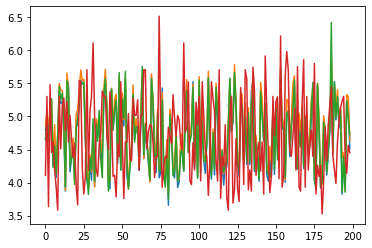

In [31]:
predictions = []
for model in MODELS:
    y_pred = model.predict(X_train)
    predictions.append(y_pred.copy())

plt.plot(predictions[0][1:200])
plt.plot(predictions[1][1:200])
plt.plot(predictions[2][1:200])
plt.plot(y_test[1:200])

Let's try a random forest classifier as a final classifier

In [15]:
rf.fit(fusion_vector_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
rf_out = rf.predict(fusion_vector_test)
mse = mean_squared_error(y_test, rf_out)
print("Test MSE = {}".format(mse))

Test MSE = 0.1899543529157859


Alternatively, we can try a neural network as the last classifier

In [18]:
numLayers = 2
numNodes = 128
EPOCHS = 30
BATCH_SIZE = 32

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

nn_model = buildNN_adv(fusion_vector_train, num_hidden_layers = numLayers, hidden_nodes = numNodes,
                      regularizer = False, do = 0.2, loss_function = 'mean_squared_error')
nn_model.fit(fusion_vector_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks = [early_stop],
            validation_split = 0.2)

mse_f, r2_f, mae_f = evaluateModel(nn_model, fusion_vector_test, y_test)
print('final results ---  MSE = {}, MAE = {}, R2 = {}'.format(mse_f,mae_f,r2_f))

Train on 31211 samples, validate on 7803 samples
Epoch 1/30
31211/31211 [==============================] - 11s 349us/sample - loss: 0.6653 - mean_absolute_error: 0.5350 - mean_squared_error: 0.6653 - val_loss: 0.1150 - val_mean_absolute_error: 0.2527 - val_mean_squared_error: 0.1150
Epoch 2/30
31211/31211 [==============================] - 10s 307us/sample - loss: 0.2736 - mean_absolute_error: 0.4044 - mean_squared_error: 0.2736 - val_loss: 0.1840 - val_mean_absolute_error: 0.3427 - val_mean_squared_error: 0.1840
Epoch 3/30
31211/31211 [==============================] - 13s 405us/sample - loss: 0.2361 - mean_absolute_error: 0.3719 - mean_squared_error: 0.2361 - val_loss: 0.1147 - val_mean_absolute_error: 0.2510 - val_mean_squared_error: 0.1147
Epoch 4/30
31211/31211 [==============================] - 10s 332us/sample - loss: 0.2157 - mean_absolute_error: 0.3521 - mean_squared_error: 0.2157 - val_loss: 0.0906 - val_mean_absolute_error: 0.1970 - val_mean_squared_error: 0.0906
Epoch 5/30


It seems like this ensemble method of classifiers is not very effective. Maybe we can enhance it by including autoencoders.

### 4.1 Incorporating Autoencoders Into Ensemble Model

In [59]:
NN1 = buildNN_adv(X, num_hidden_layers = 4, 
                          hidden_nodes = 128,
                          regularizer=False,
                          do = 0.1,
                          loss_function = 'mean_squared_error',
                          act = 'tanh')

NN2 = buildNN_adv(X, num_hidden_layers = 2, 
                          hidden_nodes = 128, 
                          regularizer=False,
                          do = 0.1,
                          loss_function = 'mean_squared_error',
                          act = 'tanh')

NN3= buildNN_adv(X, num_hidden_layers = 1, 
                          hidden_nodes = 128,
                          regularizer=False,
                          do = 0.1,
                          loss_function = 'mean_squared_error',
                          act = 'relu')

AE1 = build_autoencoder(X_train, num_hidden_layers = 2, num_nodes = 16, act = 'relu')
AE2 = build_autoencoder(X_train, num_hidden_layers = 1, num_nodes = 16, act = 'relu')
AE3 = build_autoencoder(X_train, num_hidden_layers = 2, num_nodes = 32, act = 'relu')
AE4 = build_autoencoder(X_train, num_hidden_layers = 2, num_nodes = 64, act = 'relu')
AE5 = build_autoencoder(X_train, num_hidden_layers = 1, num_nodes = 128, act = 'relu')
AE6 = build_autoencoder(X_train, num_hidden_layers = 1, num_nodes = 32, act = 'relu')

In [61]:
AE_MODELS = [AE1, AE2, AE3, AE4, AE5, AE6]
rf_model = RandomForestRegressor(n_estimators=50)
i = 0

EPOCHS = 100
BATCH_SIZE = 256

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.00001, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

## FIRST RF
X_train1, X_ignore, y_train1, y_ignore = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
#Train model on the randomly sectioned train data
rf.fit(X_train1,y_train1)

print(rf.__class__.__name__)

# Display performance on ignored set
y_pred = rf.predict(X_ignore)
mse = mean_squared_error(y_ignore, y_pred)
print("Ignored MSE = {}".format(mse))

rf_out = rf.predict(X_train)
rf_out = np.reshape(rf_out, (rf_out.shape[0], 1) )
mse = mean_squared_error(y_train, rf_out)
print("Train MSE = {}".format(mse))
fusion_vector_train = rf_out

rf_out = rf.predict(X_test)
rf_out = np.reshape(rf_out, (rf_out.shape[0], 1) )
fusion_vector_test = rf_out

mse = mean_squared_error(y_test, rf_out)
print("Test MSE = {}".format(mse))

for model in AE_MODELS:
    print(model.__class__.__name__)
        
    X_train1, X_ignore, y_train1, y_ignore = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
    # Training Autoencoder
    print("Training AE {}".format(i+1))
    model.fit(X_train1, X_train1, epochs = EPOCHS,
                     batch_size = BATCH_SIZE,
                     callbacks = [early_stop],
                     validation_split = 0.2)
    
    # Getting new representations
    X_train_new = AE_MODELS[i].predict(X_train)
    X_train1_new = AE_MODELS[i].predict(X_train1)
    X_ignore_new = AE_MODELS[i].predict(X_ignore)
    X_test_new = AE_MODELS[i].predict(X_test)
    
    #Train model on the randomly sectioned train data
    rf_model.fit(X_train1_new, y_train1)
    
    # Display performance on ignored set
    y_pred = rf_model.predict(X_ignore_new)
    mse = mean_squared_error(y_ignore, y_pred)
    print("Ignored MSE = {}".format(mse))
    
    model_out = rf_model.predict(X_train_new)
    model_out = np.reshape(model_out, (model_out.shape[0], 1) )
    mse = mean_squared_error(y_train, model_out)
    print("Whole Train Set MSE = {}".format(mse))
    
    # Fusion Train
    fusion_vector_train = np.hstack((fusion_vector_train,model_out))
    
    model_out = rf_model.predict(X_test_new)
    model_out = np.reshape(model_out, (model_out.shape[0], 1) )
    mse = mean_squared_error(y_test, model_out)
    print("Test MSE = {}".format(mse))
    
    # Fusion Test
    fusion_vector_test = np.hstack((fusion_vector_test,model_out))
    
    i=i+1

RandomForestRegressor
Ignored MSE = 0.18543149558082708
Train MSE = 0.09090255530849904
Test MSE = 0.17936428930930803
Sequential
Training AE 1
Train on 18726 samples, validate on 4682 samples
Epoch 1/100
18726/18726 [==============================] - 3s 150us/sample - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 2/100
18726/18726 [==============================] - 2s 104us/sample - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 3/100
18726/18726 [==============================] - 1s 80us/sample - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 4/100
18726/18726 [==============================] - 2s 82us/sample - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 5/100
18726/18726 [==============================] - 1s 62us/sample - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 6/100
18726/18726 [==============================] - 1s 80us/sample - loss: 0.0152 - mse: 0.0152 - 

18726/18726 [==============================] - 1s 67us/sample - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 27/100
18726/18726 [==============================] - 1s 55us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 28/100
18726/18726 [==============================] - 1s 55us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 29/100
18726/18726 [==============================] - 1s 60us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 30/100
18726/18726 [==============================] - 1s 50us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 31/100
18726/18726 [==============================] - 1s 51us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 32/100
18726/18726 [==============================] - 1s 46us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 33/100
18726/18726 [

Epoch 9/100
18726/18726 [==============================] - 2s 85us/sample - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 10/100
18726/18726 [==============================] - 2s 80us/sample - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 11/100
18726/18726 [==============================] - 1s 59us/sample - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 12/100
18726/18726 [==============================] - 1s 68us/sample - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 13/100
18726/18726 [==============================] - 1s 44us/sample - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 14/100
18726/18726 [==============================] - 1s 53us/sample - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 15/100
18726/18726 [==============================] - 1s 59us/sample - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 16/100
1

18726/18726 [==============================] - 1s 51us/sample - loss: 0.1020 - mse: 0.1020 - val_loss: 0.1061 - val_mse: 0.1061
Epoch 37/100
18726/18726 [==============================] - 1s 53us/sample - loss: 0.1020 - mse: 0.1020 - val_loss: 0.1061 - val_mse: 0.1061
Ignored MSE = 0.21856483768951512
Whole Train Set MSE = 0.1069197862445524
Test MSE = 0.2143948769785602
Sequential
Training AE 6
Train on 18726 samples, validate on 4682 samples
Epoch 1/100
18726/18726 [==============================] - 4s 217us/sample - loss: 4.7726 - mse: 4.7726 - val_loss: 3.2991 - val_mse: 3.2991
Epoch 2/100
18726/18726 [==============================] - 1s 79us/sample - loss: 2.4142 - mse: 2.4142 - val_loss: 0.7729 - val_mse: 0.7729
Epoch 3/100
18726/18726 [==============================] - 2s 89us/sample - loss: 0.2932 - mse: 0.2932 - val_loss: 0.0475 - val_mse: 0.0475
Epoch 4/100
18726/18726 [==============================] - 1s 74us/sample - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0242 - val_mse

In [42]:
# MODELS = [NN1, NN2, NN3]
# AE_MODELS = [AE1, AE2, AE3]
# i = 0

# EPOCHS = 100
# BATCH_SIZE = 256

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto',
#     baseline=None, restore_best_weights=False
# )

# ## FIRST RF
# X_train1, X_ignore, y_train1, y_ignore = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
# #Train model on the randomly sectioned train data
# rf.fit(X_train1,y_train1)

# print(rf.__class__.__name__)

# # Display performance on ignored set
# y_pred = rf.predict(X_ignore)
# mse = mean_squared_error(y_ignore, y_pred)
# print("Ignored MSE = {}".format(mse))

# rf_out = rf.predict(X_train)
# rf_out = np.reshape(rf_out, (rf_out.shape[0], 1) )
# mse = mean_squared_error(y_train, rf_out)
# print("Train MSE = {}".format(mse))
# fusion_vector_train = rf_out

# rf_out = rf.predict(X_test)
# rf_out = np.reshape(rf_out, (rf_out.shape[0], 1) )
# fusion_vector_test = rf_out

# mse = mean_squared_error(y_test, rf_out)
# print("Test MSE = {}".format(mse))

# for model in MODELS:
#     print(model.__class__.__name__)
        
#     X_train1, X_ignore, y_train1, y_ignore = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
#     # Training Autoencoder
#     print("Training AE {}".format(i+1))
#     AE_MODELS[i].fit(X_train1, X_train1, epochs = EPOCHS,
#                      batch_size = BATCH_SIZE,
#                      callbacks = [early_stop],
#                      validation_split = 0.2)
    
#     # Getting new representations
#     X_train_new = AE_MODELS[i].predict(X_train)
#     X_train1_new = AE_MODELS[i].predict(X_train1)
#     X_ignore_new = AE_MODELS[i].predict(X_ignore)
#     X_test_new = AE_MODELS[i].predict(X_test)
    
#     #Train model on the randomly sectioned train data
#     model.fit(X_train1_new, y_train1, epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks = [early_stop],
#                validation_split = 0.2)
    
#     # Display performance on ignored set
#     y_pred = model.predict(X_ignore_new)
#     mse = mean_squared_error(y_ignore, y_pred)
#     print("Ignored MSE = {}".format(mse))
    
#     model_out = model.predict(X_train_new)
#     model_out = np.reshape(model_out, (model_out.shape[0], 1) )
#     mse = mean_squared_error(y_train, model_out)
#     print("Whole Train Set MSE = {}".format(mse))
    
#     # Fusion Train
#     fusion_vector_train = np.hstack((fusion_vector_train,model_out))
    
#     model_out = model.predict(X_test_new)
#     model_out = np.reshape(model_out, (model_out.shape[0], 1) )
#     mse = mean_squared_error(y_test, model_out)
#     print("Test MSE = {}".format(mse))
    
#     # Fusion Test
#     fusion_vector_test = np.hstack((fusion_vector_test,model_out))
    
#     i=i+1

RandomForestRegressor
Ignored MSE = 0.1856774105825483
Train MSE = 0.09087026350898217
Test MSE = 0.17881583770609163
Sequential
Training AE 1
Train on 18726 samples, validate on 4682 samples
Epoch 1/100
18726/18726 [==============================] - 1s 48us/sample - loss: 4.4021 - mse: 4.4021 - val_loss: 2.9196 - val_mse: 2.9196
Epoch 2/100
18726/18726 [==============================] - 0s 25us/sample - loss: 1.6491 - mse: 1.6491 - val_loss: 0.2195 - val_mse: 0.2195
Epoch 3/100
18726/18726 [==============================] - 1s 28us/sample - loss: 0.1037 - mse: 0.1037 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4/100
18726/18726 [==============================] - 1s 35us/sample - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 5/100
18726/18726 [==============================] - 0s 26us/sample - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 6/100
18726/18726 [==============================] - 4s 189us/sample - loss: 0.0214 - mse: 0.0214 - va

18726/18726 [==============================] - 2s 117us/sample - loss: 0.2788 - mean_absolute_error: 0.3927 - mean_squared_error: 0.2788 - val_loss: 0.2481 - val_mean_absolute_error: 0.3651 - val_mean_squared_error: 0.2481
Epoch 22/100
18726/18726 [==============================] - 2s 95us/sample - loss: 0.2775 - mean_absolute_error: 0.3913 - mean_squared_error: 0.2775 - val_loss: 0.2569 - val_mean_absolute_error: 0.3786 - val_mean_squared_error: 0.2569
Epoch 23/100
18726/18726 [==============================] - 5s 267us/sample - loss: 0.2713 - mean_absolute_error: 0.3850 - mean_squared_error: 0.2713 - val_loss: 0.2496 - val_mean_absolute_error: 0.3622 - val_mean_squared_error: 0.2496
Epoch 24/100
18726/18726 [==============================] - 3s 175us/sample - loss: 0.2734 - mean_absolute_error: 0.3875 - mean_squared_error: 0.2734 - val_loss: 0.2626 - val_mean_absolute_error: 0.3885 - val_mean_squared_error: 0.2626
Epoch 25/100
18726/18726 [==============================] - 3s 150us/s

18726/18726 [==============================] - 4s 208us/sample - loss: 0.2617 - mean_absolute_error: 0.3826 - mean_squared_error: 0.2617 - val_loss: 0.2289 - val_mean_absolute_error: 0.3516 - val_mean_squared_error: 0.2289
Epoch 18/100
18726/18726 [==============================] - 2s 99us/sample - loss: 0.2584 - mean_absolute_error: 0.3784 - mean_squared_error: 0.2584 - val_loss: 0.2276 - val_mean_absolute_error: 0.3513 - val_mean_squared_error: 0.2276
Epoch 19/100
18726/18726 [==============================] - 2s 94us/sample - loss: 0.2582 - mean_absolute_error: 0.3802 - mean_squared_error: 0.2582 - val_loss: 0.2295 - val_mean_absolute_error: 0.3525 - val_mean_squared_error: 0.2295
Epoch 20/100
18726/18726 [==============================] - 2s 100us/sample - loss: 0.2596 - mean_absolute_error: 0.3803 - mean_squared_error: 0.2596 - val_loss: 0.2283 - val_mean_absolute_error: 0.3592 - val_mean_squared_error: 0.2283
Epoch 21/100
18726/18726 [==============================] - 2s 95us/sam

18726/18726 [==============================] - 0s 26us/sample - loss: 0.3443 - mean_absolute_error: 0.4373 - mean_squared_error: 0.3443 - val_loss: 0.2763 - val_mean_absolute_error: 0.3867 - val_mean_squared_error: 0.2763
Epoch 12/100
18726/18726 [==============================] - 2s 80us/sample - loss: 0.3401 - mean_absolute_error: 0.4325 - mean_squared_error: 0.3401 - val_loss: 0.2759 - val_mean_absolute_error: 0.3835 - val_mean_squared_error: 0.2759
Epoch 13/100
18726/18726 [==============================] - 3s 164us/sample - loss: 0.3277 - mean_absolute_error: 0.4269 - mean_squared_error: 0.3277 - val_loss: 0.2732 - val_mean_absolute_error: 0.3802 - val_mean_squared_error: 0.2732
Epoch 14/100
18726/18726 [==============================] - 1s 66us/sample - loss: 0.3224 - mean_absolute_error: 0.4218 - mean_squared_error: 0.3224 - val_loss: 0.2639 - val_mean_absolute_error: 0.3746 - val_mean_squared_error: 0.2639
Epoch 15/100
18726/18726 [==============================] - 2s 88us/samp

In [77]:
nn_model = buildNN_adv(fusion_vector_train, num_hidden_layers = 2, hidden_nodes = 32,
                              regularizer = True, do = 0.1, loss_function = 'mean_squared_error')
        
nn_model.fit(fusion_vector_train, y_train, epochs = 20, batch_size = BATCH_SIZE,
            validation_split = 0.2)

mse_f, r2_f, mae_f = evaluateModel(nn_model, fusion_vector_test, y_test)
print('final results ---  MSE = {}, MAE = {}, R2 = {}'.format(mse_f,mae_f,r2_f))

Train on 31211 samples, validate on 7803 samples
Epoch 1/20
31211/31211 [==============================] - 2s 53us/sample - loss: 6.4339 - mean_absolute_error: 1.8194 - mean_squared_error: 6.4054 - val_loss: 0.1261 - val_mean_absolute_error: 0.2066 - val_mean_squared_error: 0.0973
Epoch 2/20
31211/31211 [==============================] - 3s 102us/sample - loss: 0.2937 - mean_absolute_error: 0.3985 - mean_squared_error: 0.2653 - val_loss: 0.1249 - val_mean_absolute_error: 0.2064 - val_mean_squared_error: 0.0965
Epoch 3/20
31211/31211 [==============================] - 1s 41us/sample - loss: 0.2808 - mean_absolute_error: 0.3878 - mean_squared_error: 0.2526 - val_loss: 0.1253 - val_mean_absolute_error: 0.2067 - val_mean_squared_error: 0.0971
Epoch 4/20
31211/31211 [==============================] - 1s 46us/sample - loss: 0.2560 - mean_absolute_error: 0.3643 - mean_squared_error: 0.2275 - val_loss: 0.1324 - val_mean_absolute_error: 0.2148 - val_mean_squared_error: 0.1037
Epoch 5/20
31211/3

Now we can test various neural network architectures on the new fusion vector

In [78]:
EPOCHS = 100
BATCH_SIZE = 32
NUM_LAYERS = [1,2,4,6]
NUM_BASE_NODES = [8,32,128,512]
dropouts = [0.1, 0.2, 0.3]

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)


mse_final = []
mae_final = []
r2_final = []
names = []

for dropout in dropouts:
    for numNodes in NUM_BASE_NODES:
        for numLayers in NUM_LAYERS:
            LOGNAME = "{}-{}-DO={}-Epochs={}-TIME={}".format(numLayers, numNodes,
                                                             dropout,
                                                             EPOCHS, 
                                                             int(time.time()) )
            print(LOGNAME)
            tensorboard = TensorBoard(log_dir='logs/fusion_NN/{}'.format(LOGNAME))

            nn_model = buildNN_adv(fusion_vector_train, num_hidden_layers = numLayers, hidden_nodes = numNodes,
                                  regularizer = False, do = 0.1, loss_function = 'mean_squared_error')

            nn_model.fit(fusion_vector_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                         callbacks = [tensorboard],
                        validation_split = 0.2)

            mse_f, r2_f, mae_f = evaluateModel(nn_model, fusion_vector_test, y_test)
            print('final results ---  MSE = {}, MAE = {}, R2 = {}'.format(mse_f,mae_f,r2_f))

            modelName = '{}-{}-{}'.format(numLayers,numNodes,dropout)
            mse_final.append(mse_f)
            mae_final.append(mae_f)
            r2_final.append(r2_f)
            names.append(modelName)

1-8-DO=0.1-Epochs=100-TIME=1586845361
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 4s 134us/sample - loss: 2.2411 - mean_absolute_error: 0.7631 - mean_squared_error: 2.2411 - val_loss: 0.0966 - val_mean_absolute_error: 0.2070 - val_mean_squared_error: 0.0966
Epoch 2/100
31211/31211 [==============================] - 4s 118us/sample - loss: 0.0947 - mean_absolute_error: 0.2055 - mean_squared_error: 0.0947 - val_loss: 0.0961 - val_mean_absolute_error: 0.2072 - val_mean_squared_error: 0.0961
Epoch 3/100
31211/31211 [==============================] - 4s 131us/sample - loss: 0.0940 - mean_absolute_error: 0.2042 - mean_squared_error: 0.0940 - val_loss: 0.0954 - val_mean_absolute_error: 0.2064 - val_mean_squared_error: 0.0954
Epoch 4/100
31211/31211 [==============================] - 4s 116us/sample - loss: 0.0932 - mean_absolute_error: 0.2028 - mean_squared_error: 0.0932 - val_loss: 0.0940 - val_mean_absolute_error: 0.2024 - val_

31211/31211 [==============================] - 4s 137us/sample - loss: 0.0858 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0858 - val_loss: 0.0876 - val_mean_absolute_error: 0.1928 - val_mean_squared_error: 0.0876
Epoch 36/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0858 - mean_absolute_error: 0.1901 - mean_squared_error: 0.0858 - val_loss: 0.0890 - val_mean_absolute_error: 0.1942 - val_mean_squared_error: 0.0890
Epoch 37/100
31211/31211 [==============================] - 4s 138us/sample - loss: 0.0855 - mean_absolute_error: 0.1895 - mean_squared_error: 0.0855 - val_loss: 0.0875 - val_mean_absolute_error: 0.1915 - val_mean_squared_error: 0.0875
Epoch 38/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0859 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0859 - val_loss: 0.0881 - val_mean_absolute_error: 0.1926 - val_mean_squared_error: 0.0881
Epoch 39/100
31211/31211 [==============================] - 4s 143us/

Epoch 70/100
31211/31211 [==============================] - 5s 144us/sample - loss: 0.0856 - mean_absolute_error: 0.1896 - mean_squared_error: 0.0856 - val_loss: 0.0871 - val_mean_absolute_error: 0.1912 - val_mean_squared_error: 0.0871
Epoch 71/100
31211/31211 [==============================] - 5s 151us/sample - loss: 0.0856 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0856 - val_loss: 0.0886 - val_mean_absolute_error: 0.1963 - val_mean_squared_error: 0.0886
Epoch 72/100
31211/31211 [==============================] - 4s 128us/sample - loss: 0.0857 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0857 - val_loss: 0.0871 - val_mean_absolute_error: 0.1917 - val_mean_squared_error: 0.0871
Epoch 73/100
31211/31211 [==============================] - 5s 145us/sample - loss: 0.0856 - mean_absolute_error: 0.1897 - mean_squared_error: 0.0856 - val_loss: 0.0879 - val_mean_absolute_error: 0.1925 - val_mean_squared_error: 0.0879
Epoch 74/100
31211/31211 [==============================

Epoch 4/100
31211/31211 [==============================] - 4s 113us/sample - loss: 0.1516 - mean_absolute_error: 0.2628 - mean_squared_error: 0.1516 - val_loss: 0.2907 - val_mean_absolute_error: 0.4421 - val_mean_squared_error: 0.2907
Epoch 5/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.1429 - mean_absolute_error: 0.2518 - mean_squared_error: 0.1429 - val_loss: 0.3082 - val_mean_absolute_error: 0.4642 - val_mean_squared_error: 0.3082
Epoch 6/100
31211/31211 [==============================] - 5s 175us/sample - loss: 0.1331 - mean_absolute_error: 0.2410 - mean_squared_error: 0.1331 - val_loss: 0.2819 - val_mean_absolute_error: 0.4427 - val_mean_squared_error: 0.2819
Epoch 7/100
31211/31211 [==============================] - 5s 164us/sample - loss: 0.1293 - mean_absolute_error: 0.2348 - mean_squared_error: 0.1293 - val_loss: 0.3047 - val_mean_absolute_error: 0.4688 - val_mean_squared_error: 0.3047
Epoch 8/100
31211/31211 [==============================] - 5

Epoch 39/100
31211/31211 [==============================] - 4s 134us/sample - loss: 0.0893 - mean_absolute_error: 0.1957 - mean_squared_error: 0.0893 - val_loss: 0.2486 - val_mean_absolute_error: 0.4222 - val_mean_squared_error: 0.2486
Epoch 40/100
31211/31211 [==============================] - 5s 153us/sample - loss: 0.0889 - mean_absolute_error: 0.1952 - mean_squared_error: 0.0889 - val_loss: 0.2998 - val_mean_absolute_error: 0.4749 - val_mean_squared_error: 0.2998
Epoch 41/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0881 - mean_absolute_error: 0.1941 - mean_squared_error: 0.0881 - val_loss: 0.3598 - val_mean_absolute_error: 0.5305 - val_mean_squared_error: 0.3598
Epoch 42/100
31211/31211 [==============================] - 5s 150us/sample - loss: 0.0887 - mean_absolute_error: 0.1948 - mean_squared_error: 0.0887 - val_loss: 0.2829 - val_mean_absolute_error: 0.4584 - val_mean_squared_error: 0.2829
Epoch 43/100
31211/31211 [==============================

Epoch 74/100
31211/31211 [==============================] - 5s 174us/sample - loss: 0.0875 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0875 - val_loss: 0.3343 - val_mean_absolute_error: 0.5075 - val_mean_squared_error: 0.3343
Epoch 75/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0873 - mean_absolute_error: 0.1926 - mean_squared_error: 0.0873 - val_loss: 0.3244 - val_mean_absolute_error: 0.4979 - val_mean_squared_error: 0.3244
Epoch 76/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0876 - mean_absolute_error: 0.1936 - mean_squared_error: 0.0876 - val_loss: 0.2512 - val_mean_absolute_error: 0.4251 - val_mean_squared_error: 0.2512
Epoch 77/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0875 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0875 - val_loss: 0.2847 - val_mean_absolute_error: 0.4594 - val_mean_squared_error: 0.2847
Epoch 78/100
31211/31211 [==============================

Epoch 8/100
31211/31211 [==============================] - 5s 160us/sample - loss: 0.1825 - mean_absolute_error: 0.2966 - mean_squared_error: 0.1825 - val_loss: 0.5737 - val_mean_absolute_error: 0.6310 - val_mean_squared_error: 0.5737
Epoch 9/100
31211/31211 [==============================] - 5s 157us/sample - loss: 0.1590 - mean_absolute_error: 0.2735 - mean_squared_error: 0.1590 - val_loss: 0.5431 - val_mean_absolute_error: 0.6291 - val_mean_squared_error: 0.5431
Epoch 10/100
31211/31211 [==============================] - 5s 156us/sample - loss: 0.1507 - mean_absolute_error: 0.2631 - mean_squared_error: 0.1507 - val_loss: 0.6441 - val_mean_absolute_error: 0.7026 - val_mean_squared_error: 0.6441
Epoch 11/100
31211/31211 [==============================] - 5s 162us/sample - loss: 0.1480 - mean_absolute_error: 0.2586 - mean_squared_error: 0.1480 - val_loss: 0.5932 - val_mean_absolute_error: 0.6776 - val_mean_squared_error: 0.5932
Epoch 12/100
31211/31211 [==============================] 

Epoch 43/100
31211/31211 [==============================] - 5s 163us/sample - loss: 0.1330 - mean_absolute_error: 0.2375 - mean_squared_error: 0.1330 - val_loss: 0.5850 - val_mean_absolute_error: 0.6891 - val_mean_squared_error: 0.5850
Epoch 44/100
31211/31211 [==============================] - 5s 152us/sample - loss: 0.1314 - mean_absolute_error: 0.2369 - mean_squared_error: 0.1314 - val_loss: 0.6684 - val_mean_absolute_error: 0.7460 - val_mean_squared_error: 0.6684
Epoch 45/100
31211/31211 [==============================] - 5s 147us/sample - loss: 0.1314 - mean_absolute_error: 0.2356 - mean_squared_error: 0.1314 - val_loss: 0.6374 - val_mean_absolute_error: 0.7235 - val_mean_squared_error: 0.6374
Epoch 46/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.1330 - mean_absolute_error: 0.2365 - mean_squared_error: 0.1330 - val_loss: 0.6785 - val_mean_absolute_error: 0.7526 - val_mean_squared_error: 0.6784
Epoch 47/100
31211/31211 [==============================

Epoch 78/100
31211/31211 [==============================] - 5s 157us/sample - loss: 0.1314 - mean_absolute_error: 0.2360 - mean_squared_error: 0.1314 - val_loss: 0.5881 - val_mean_absolute_error: 0.6929 - val_mean_squared_error: 0.5881
Epoch 79/100
31211/31211 [==============================] - 5s 169us/sample - loss: 0.1320 - mean_absolute_error: 0.2358 - mean_squared_error: 0.1320 - val_loss: 0.7154 - val_mean_absolute_error: 0.7749 - val_mean_squared_error: 0.7154
Epoch 80/100
31211/31211 [==============================] - 5s 161us/sample - loss: 0.1300 - mean_absolute_error: 0.2345 - mean_squared_error: 0.1300 - val_loss: 0.6996 - val_mean_absolute_error: 0.7664 - val_mean_squared_error: 0.6996
Epoch 81/100
31211/31211 [==============================] - 5s 161us/sample - loss: 0.1306 - mean_absolute_error: 0.2339 - mean_squared_error: 0.1306 - val_loss: 0.6037 - val_mean_absolute_error: 0.7039 - val_mean_squared_error: 0.6037
Epoch 82/100
31211/31211 [==============================

Epoch 12/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.4617 - mean_absolute_error: 0.5437 - mean_squared_error: 0.4617 - val_loss: 0.4556 - val_mean_absolute_error: 0.5416 - val_mean_squared_error: 0.4556
Epoch 13/100
31211/31211 [==============================] - 6s 185us/sample - loss: 0.4614 - mean_absolute_error: 0.5435 - mean_squared_error: 0.4614 - val_loss: 0.4557 - val_mean_absolute_error: 0.5412 - val_mean_squared_error: 0.4557
Epoch 14/100
31211/31211 [==============================] - 6s 179us/sample - loss: 0.4615 - mean_absolute_error: 0.5436 - mean_squared_error: 0.4615 - val_loss: 0.4559 - val_mean_absolute_error: 0.5423 - val_mean_squared_error: 0.4559
Epoch 15/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.4614 - mean_absolute_error: 0.5437 - mean_squared_error: 0.4614 - val_loss: 0.4557 - val_mean_absolute_error: 0.5412 - val_mean_squared_error: 0.4557
Epoch 16/100
31211/31211 [==============================

Epoch 47/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.4614 - mean_absolute_error: 0.5436 - mean_squared_error: 0.4614 - val_loss: 0.4557 - val_mean_absolute_error: 0.5411 - val_mean_squared_error: 0.4557
Epoch 48/100
31211/31211 [==============================] - 5s 173us/sample - loss: 0.4614 - mean_absolute_error: 0.5436 - mean_squared_error: 0.4614 - val_loss: 0.4558 - val_mean_absolute_error: 0.5421 - val_mean_squared_error: 0.4558
Epoch 49/100
31211/31211 [==============================] - 6s 187us/sample - loss: 0.4615 - mean_absolute_error: 0.5438 - mean_squared_error: 0.4615 - val_loss: 0.4557 - val_mean_absolute_error: 0.5417 - val_mean_squared_error: 0.4557
Epoch 50/100
31211/31211 [==============================] - 6s 177us/sample - loss: 0.4616 - mean_absolute_error: 0.5438 - mean_squared_error: 0.4616 - val_loss: 0.4557 - val_mean_absolute_error: 0.5410 - val_mean_squared_error: 0.4557
Epoch 51/100
31211/31211 [==============================

Epoch 82/100
31211/31211 [==============================] - 6s 182us/sample - loss: 0.4615 - mean_absolute_error: 0.5436 - mean_squared_error: 0.4615 - val_loss: 0.4560 - val_mean_absolute_error: 0.5425 - val_mean_squared_error: 0.4560
Epoch 83/100
31211/31211 [==============================] - 6s 181us/sample - loss: 0.4616 - mean_absolute_error: 0.5437 - mean_squared_error: 0.4616 - val_loss: 0.4556 - val_mean_absolute_error: 0.5414 - val_mean_squared_error: 0.4556
Epoch 84/100
31211/31211 [==============================] - 5s 174us/sample - loss: 0.4613 - mean_absolute_error: 0.5435 - mean_squared_error: 0.4613 - val_loss: 0.4567 - val_mean_absolute_error: 0.5434 - val_mean_squared_error: 0.4567
Epoch 85/100
31211/31211 [==============================] - 6s 177us/sample - loss: 0.4613 - mean_absolute_error: 0.5434 - mean_squared_error: 0.4613 - val_loss: 0.4565 - val_mean_absolute_error: 0.5402 - val_mean_squared_error: 0.4565
Epoch 86/100
31211/31211 [==============================

Epoch 16/100
31211/31211 [==============================] - 4s 130us/sample - loss: 0.0864 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0864 - val_loss: 0.0881 - val_mean_absolute_error: 0.1938 - val_mean_squared_error: 0.0881
Epoch 17/100
31211/31211 [==============================] - 4s 137us/sample - loss: 0.0867 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0867 - val_loss: 0.0879 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0879
Epoch 18/100
31211/31211 [==============================] - 4s 129us/sample - loss: 0.0866 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0866 - val_loss: 0.0882 - val_mean_absolute_error: 0.1944 - val_mean_squared_error: 0.0882
Epoch 19/100
31211/31211 [==============================] - 4s 135us/sample - loss: 0.0863 - mean_absolute_error: 0.1905 - mean_squared_error: 0.0863 - val_loss: 0.0933 - val_mean_absolute_error: 0.2076 - val_mean_squared_error: 0.0933
Epoch 20/100
31211/31211 [==============================

Epoch 51/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0859 - mean_absolute_error: 0.1905 - mean_squared_error: 0.0859 - val_loss: 0.0871 - val_mean_absolute_error: 0.1917 - val_mean_squared_error: 0.0871
Epoch 52/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0864 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0864 - val_loss: 0.0875 - val_mean_absolute_error: 0.1933 - val_mean_squared_error: 0.0875
Epoch 53/100
31211/31211 [==============================] - 4s 128us/sample - loss: 0.0864 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0864 - val_loss: 0.0872 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0872
Epoch 54/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0860 - mean_absolute_error: 0.1905 - mean_squared_error: 0.0860 - val_loss: 0.0875 - val_mean_absolute_error: 0.1917 - val_mean_squared_error: 0.0875
Epoch 55/100
31211/31211 [==============================

Epoch 86/100
31211/31211 [==============================] - 4s 122us/sample - loss: 0.0863 - mean_absolute_error: 0.1914 - mean_squared_error: 0.0863 - val_loss: 0.0877 - val_mean_absolute_error: 0.1920 - val_mean_squared_error: 0.0877
Epoch 87/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0863 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0863 - val_loss: 0.0871 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0871
Epoch 88/100
31211/31211 [==============================] - 4s 130us/sample - loss: 0.0861 - mean_absolute_error: 0.1909 - mean_squared_error: 0.0861 - val_loss: 0.0891 - val_mean_absolute_error: 0.1947 - val_mean_squared_error: 0.0891
Epoch 89/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0859 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0859 - val_loss: 0.0870 - val_mean_absolute_error: 0.1916 - val_mean_squared_error: 0.0870
Epoch 90/100
31211/31211 [==============================

Epoch 20/100
31211/31211 [==============================] - 5s 165us/sample - loss: 0.0897 - mean_absolute_error: 0.1973 - mean_squared_error: 0.0897 - val_loss: 0.2150 - val_mean_absolute_error: 0.3864 - val_mean_squared_error: 0.2150
Epoch 21/100
31211/31211 [==============================] - 6s 176us/sample - loss: 0.0899 - mean_absolute_error: 0.1980 - mean_squared_error: 0.0899 - val_loss: 0.2239 - val_mean_absolute_error: 0.3987 - val_mean_squared_error: 0.2239
Epoch 22/100
31211/31211 [==============================] - 5s 173us/sample - loss: 0.0902 - mean_absolute_error: 0.1983 - mean_squared_error: 0.0902 - val_loss: 0.2097 - val_mean_absolute_error: 0.3797 - val_mean_squared_error: 0.2097
Epoch 23/100
31211/31211 [==============================] - 6s 185us/sample - loss: 0.0891 - mean_absolute_error: 0.1963 - mean_squared_error: 0.0891 - val_loss: 0.2313 - val_mean_absolute_error: 0.4070 - val_mean_squared_error: 0.2313
Epoch 24/100
31211/31211 [==============================

Epoch 55/100
31211/31211 [==============================] - 5s 156us/sample - loss: 0.0872 - mean_absolute_error: 0.1931 - mean_squared_error: 0.0872 - val_loss: 0.3116 - val_mean_absolute_error: 0.4872 - val_mean_squared_error: 0.3116
Epoch 56/100
31211/31211 [==============================] - 5s 164us/sample - loss: 0.0872 - mean_absolute_error: 0.1930 - mean_squared_error: 0.0872 - val_loss: 0.2938 - val_mean_absolute_error: 0.4683 - val_mean_squared_error: 0.2938
Epoch 57/100
31211/31211 [==============================] - 5s 153us/sample - loss: 0.0865 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0865 - val_loss: 0.2744 - val_mean_absolute_error: 0.4477 - val_mean_squared_error: 0.2744
Epoch 58/100
31211/31211 [==============================] - 5s 152us/sample - loss: 0.0877 - mean_absolute_error: 0.1937 - mean_squared_error: 0.0877 - val_loss: 0.2806 - val_mean_absolute_error: 0.4548 - val_mean_squared_error: 0.2806
Epoch 59/100
31211/31211 [==============================

Epoch 90/100
31211/31211 [==============================] - 5s 166us/sample - loss: 0.0862 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0862 - val_loss: 0.3320 - val_mean_absolute_error: 0.5063 - val_mean_squared_error: 0.3320
Epoch 91/100
31211/31211 [==============================] - 5s 152us/sample - loss: 0.0865 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0865 - val_loss: 0.3106 - val_mean_absolute_error: 0.4852 - val_mean_squared_error: 0.3106
Epoch 92/100
31211/31211 [==============================] - 5s 157us/sample - loss: 0.0868 - mean_absolute_error: 0.1918 - mean_squared_error: 0.0868 - val_loss: 0.3209 - val_mean_absolute_error: 0.4935 - val_mean_squared_error: 0.3209
Epoch 93/100
31211/31211 [==============================] - 5s 170us/sample - loss: 0.0864 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0864 - val_loss: 0.3849 - val_mean_absolute_error: 0.5503 - val_mean_squared_error: 0.3849
Epoch 94/100
31211/31211 [==============================

Epoch 24/100
31211/31211 [==============================] - 6s 205us/sample - loss: 0.0969 - mean_absolute_error: 0.2105 - mean_squared_error: 0.0969 - val_loss: 0.2352 - val_mean_absolute_error: 0.3927 - val_mean_squared_error: 0.2352
Epoch 25/100
31211/31211 [==============================] - 7s 211us/sample - loss: 0.0953 - mean_absolute_error: 0.2084 - mean_squared_error: 0.0953 - val_loss: 0.3042 - val_mean_absolute_error: 0.4598 - val_mean_squared_error: 0.3042
Epoch 26/100
31211/31211 [==============================] - 6s 191us/sample - loss: 0.0951 - mean_absolute_error: 0.2075 - mean_squared_error: 0.0951 - val_loss: 0.3172 - val_mean_absolute_error: 0.4739 - val_mean_squared_error: 0.3172
Epoch 27/100
31211/31211 [==============================] - 6s 196us/sample - loss: 0.0955 - mean_absolute_error: 0.2087 - mean_squared_error: 0.0955 - val_loss: 0.3060 - val_mean_absolute_error: 0.4640 - val_mean_squared_error: 0.3060
Epoch 28/100
31211/31211 [==============================

Epoch 59/100
31211/31211 [==============================] - 6s 186us/sample - loss: 0.0926 - mean_absolute_error: 0.2040 - mean_squared_error: 0.0926 - val_loss: 0.2916 - val_mean_absolute_error: 0.4521 - val_mean_squared_error: 0.2916
Epoch 60/100
31211/31211 [==============================] - 6s 184us/sample - loss: 0.0911 - mean_absolute_error: 0.2010 - mean_squared_error: 0.0911 - val_loss: 0.2522 - val_mean_absolute_error: 0.4098 - val_mean_squared_error: 0.2522
Epoch 61/100
31211/31211 [==============================] - 6s 196us/sample - loss: 0.0921 - mean_absolute_error: 0.2027 - mean_squared_error: 0.0921 - val_loss: 0.3454 - val_mean_absolute_error: 0.5026 - val_mean_squared_error: 0.3454
Epoch 62/100
31211/31211 [==============================] - 6s 195us/sample - loss: 0.0914 - mean_absolute_error: 0.2011 - mean_squared_error: 0.0914 - val_loss: 0.3219 - val_mean_absolute_error: 0.4787 - val_mean_squared_error: 0.3219
Epoch 63/100
31211/31211 [==============================

Epoch 94/100
31211/31211 [==============================] - 6s 204us/sample - loss: 0.0910 - mean_absolute_error: 0.2009 - mean_squared_error: 0.0910 - val_loss: 0.3304 - val_mean_absolute_error: 0.4845 - val_mean_squared_error: 0.3304
Epoch 95/100
31211/31211 [==============================] - 6s 203us/sample - loss: 0.0909 - mean_absolute_error: 0.1998 - mean_squared_error: 0.0909 - val_loss: 0.2975 - val_mean_absolute_error: 0.4590 - val_mean_squared_error: 0.2975
Epoch 96/100
31211/31211 [==============================] - 6s 208us/sample - loss: 0.0907 - mean_absolute_error: 0.1998 - mean_squared_error: 0.0907 - val_loss: 0.2850 - val_mean_absolute_error: 0.4418 - val_mean_squared_error: 0.2850
Epoch 97/100
31211/31211 [==============================] - 7s 209us/sample - loss: 0.0904 - mean_absolute_error: 0.1989 - mean_squared_error: 0.0904 - val_loss: 0.2483 - val_mean_absolute_error: 0.4098 - val_mean_squared_error: 0.2483
Epoch 98/100
31211/31211 [==============================

Epoch 28/100
31211/31211 [==============================] - 7s 231us/sample - loss: 0.1003 - mean_absolute_error: 0.2175 - mean_squared_error: 0.1003 - val_loss: 0.1763 - val_mean_absolute_error: 0.3141 - val_mean_squared_error: 0.1763
Epoch 29/100
31211/31211 [==============================] - 7s 220us/sample - loss: 0.0996 - mean_absolute_error: 0.2156 - mean_squared_error: 0.0996 - val_loss: 0.1666 - val_mean_absolute_error: 0.3090 - val_mean_squared_error: 0.1666
Epoch 30/100
31211/31211 [==============================] - 7s 221us/sample - loss: 0.1010 - mean_absolute_error: 0.2171 - mean_squared_error: 0.1010 - val_loss: 0.2425 - val_mean_absolute_error: 0.3916 - val_mean_squared_error: 0.2425
Epoch 31/100
31211/31211 [==============================] - 6s 207us/sample - loss: 0.1019 - mean_absolute_error: 0.2188 - mean_squared_error: 0.1019 - val_loss: 0.2232 - val_mean_absolute_error: 0.3699 - val_mean_squared_error: 0.2232
Epoch 32/100
31211/31211 [==============================

Epoch 63/100
31211/31211 [==============================] - 7s 211us/sample - loss: 0.0975 - mean_absolute_error: 0.2116 - mean_squared_error: 0.0975 - val_loss: 0.2914 - val_mean_absolute_error: 0.4420 - val_mean_squared_error: 0.2914
Epoch 64/100
31211/31211 [==============================] - 7s 222us/sample - loss: 0.0968 - mean_absolute_error: 0.2102 - mean_squared_error: 0.0968 - val_loss: 0.2477 - val_mean_absolute_error: 0.3895 - val_mean_squared_error: 0.2477
Epoch 65/100
31211/31211 [==============================] - 7s 217us/sample - loss: 0.0982 - mean_absolute_error: 0.2129 - mean_squared_error: 0.0982 - val_loss: 0.2453 - val_mean_absolute_error: 0.3899 - val_mean_squared_error: 0.2453
Epoch 66/100
31211/31211 [==============================] - 7s 215us/sample - loss: 0.0962 - mean_absolute_error: 0.2099 - mean_squared_error: 0.0962 - val_loss: 0.1979 - val_mean_absolute_error: 0.3404 - val_mean_squared_error: 0.1979
Epoch 67/100
31211/31211 [==============================

Epoch 98/100
31211/31211 [==============================] - 7s 221us/sample - loss: 0.0954 - mean_absolute_error: 0.2085 - mean_squared_error: 0.0954 - val_loss: 0.1939 - val_mean_absolute_error: 0.3343 - val_mean_squared_error: 0.1939
Epoch 99/100
31211/31211 [==============================] - 7s 218us/sample - loss: 0.0954 - mean_absolute_error: 0.2078 - mean_squared_error: 0.0954 - val_loss: 0.2046 - val_mean_absolute_error: 0.3454 - val_mean_squared_error: 0.2046
Epoch 100/100
31211/31211 [==============================] - 7s 229us/sample - loss: 0.0953 - mean_absolute_error: 0.2083 - mean_squared_error: 0.0953 - val_loss: 0.1898 - val_mean_absolute_error: 0.3316 - val_mean_squared_error: 0.1898
final results ---  MSE = 0.2621845550740348, MAE = 0.37907469407996774, R2 = 0.424508476228296
1-128-DO=0.1-Epochs=100-TIME=1586849661
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 5s 168us/sample - loss: 0.3904 - mean_absolute_e

Epoch 32/100
31211/31211 [==============================] - 4s 138us/sample - loss: 0.0869 - mean_absolute_error: 0.1929 - mean_squared_error: 0.0869 - val_loss: 0.0890 - val_mean_absolute_error: 0.1945 - val_mean_squared_error: 0.0890
Epoch 33/100
31211/31211 [==============================] - 5s 155us/sample - loss: 0.0867 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0867 - val_loss: 0.0885 - val_mean_absolute_error: 0.1934 - val_mean_squared_error: 0.0885
Epoch 34/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0875 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0875 - val_loss: 0.0883 - val_mean_absolute_error: 0.1954 - val_mean_squared_error: 0.0883
Epoch 35/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0872 - mean_absolute_error: 0.1933 - mean_squared_error: 0.0872 - val_loss: 0.0871 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0871
Epoch 36/100
31211/31211 [==============================

Epoch 67/100
31211/31211 [==============================] - 5s 150us/sample - loss: 0.0865 - mean_absolute_error: 0.1914 - mean_squared_error: 0.0865 - val_loss: 0.0870 - val_mean_absolute_error: 0.1911 - val_mean_squared_error: 0.0870
Epoch 68/100
31211/31211 [==============================] - 4s 132us/sample - loss: 0.0861 - mean_absolute_error: 0.1908 - mean_squared_error: 0.0861 - val_loss: 0.0876 - val_mean_absolute_error: 0.1936 - val_mean_squared_error: 0.0876
Epoch 69/100
31211/31211 [==============================] - 5s 150us/sample - loss: 0.0869 - mean_absolute_error: 0.1926 - mean_squared_error: 0.0869 - val_loss: 0.0871 - val_mean_absolute_error: 0.1918 - val_mean_squared_error: 0.0871
Epoch 70/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0862 - mean_absolute_error: 0.1908 - mean_squared_error: 0.0862 - val_loss: 0.0882 - val_mean_absolute_error: 0.1929 - val_mean_squared_error: 0.0882
Epoch 71/100
31211/31211 [==============================

Epoch 1/100
31211/31211 [==============================] - 6s 186us/sample - loss: 0.3913 - mean_absolute_error: 0.3506 - mean_squared_error: 0.3913 - val_loss: 0.1093 - val_mean_absolute_error: 0.2422 - val_mean_squared_error: 0.1093
Epoch 2/100
31211/31211 [==============================] - 6s 178us/sample - loss: 0.1350 - mean_absolute_error: 0.2676 - mean_squared_error: 0.1350 - val_loss: 0.0918 - val_mean_absolute_error: 0.2008 - val_mean_squared_error: 0.0918
Epoch 3/100
31211/31211 [==============================] - 5s 176us/sample - loss: 0.1264 - mean_absolute_error: 0.2568 - mean_squared_error: 0.1264 - val_loss: 0.1126 - val_mean_absolute_error: 0.2352 - val_mean_squared_error: 0.1126
Epoch 4/100
31211/31211 [==============================] - 5s 168us/sample - loss: 0.1119 - mean_absolute_error: 0.2358 - mean_squared_error: 0.1119 - val_loss: 0.1003 - val_mean_absolute_error: 0.2150 - val_mean_squared_error: 0.1003
Epoch 5/100
31211/31211 [==============================] - 5

Epoch 36/100
31211/31211 [==============================] - 5s 167us/sample - loss: 0.0879 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0879 - val_loss: 0.3028 - val_mean_absolute_error: 0.4786 - val_mean_squared_error: 0.3028
Epoch 37/100
31211/31211 [==============================] - 5s 168us/sample - loss: 0.0881 - mean_absolute_error: 0.1947 - mean_squared_error: 0.0881 - val_loss: 0.2723 - val_mean_absolute_error: 0.4479 - val_mean_squared_error: 0.2723
Epoch 38/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.0883 - mean_absolute_error: 0.1947 - mean_squared_error: 0.0883 - val_loss: 0.3418 - val_mean_absolute_error: 0.5156 - val_mean_squared_error: 0.3418
Epoch 39/100
31211/31211 [==============================] - 6s 184us/sample - loss: 0.0881 - mean_absolute_error: 0.1950 - mean_squared_error: 0.0881 - val_loss: 0.3116 - val_mean_absolute_error: 0.4872 - val_mean_squared_error: 0.3116
Epoch 40/100
31211/31211 [==============================

Epoch 71/100
31211/31211 [==============================] - 5s 174us/sample - loss: 0.0873 - mean_absolute_error: 0.1930 - mean_squared_error: 0.0873 - val_loss: 0.3080 - val_mean_absolute_error: 0.4832 - val_mean_squared_error: 0.3080
Epoch 72/100
31211/31211 [==============================] - 5s 176us/sample - loss: 0.0873 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0873 - val_loss: 0.2452 - val_mean_absolute_error: 0.4188 - val_mean_squared_error: 0.2452
Epoch 73/100
31211/31211 [==============================] - 6s 184us/sample - loss: 0.0877 - mean_absolute_error: 0.1936 - mean_squared_error: 0.0877 - val_loss: 0.2967 - val_mean_absolute_error: 0.4723 - val_mean_squared_error: 0.2967
Epoch 74/100
31211/31211 [==============================] - 6s 179us/sample - loss: 0.0872 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0872 - val_loss: 0.3510 - val_mean_absolute_error: 0.5233 - val_mean_squared_error: 0.3510
Epoch 75/100
31211/31211 [==============================

Epoch 5/100
31211/31211 [==============================] - 7s 233us/sample - loss: 0.1329 - mean_absolute_error: 0.2647 - mean_squared_error: 0.1329 - val_loss: 0.2633 - val_mean_absolute_error: 0.4301 - val_mean_squared_error: 0.2633
Epoch 6/100
31211/31211 [==============================] - 7s 231us/sample - loss: 0.1175 - mean_absolute_error: 0.2453 - mean_squared_error: 0.1175 - val_loss: 0.2056 - val_mean_absolute_error: 0.3669 - val_mean_squared_error: 0.2056
Epoch 7/100
31211/31211 [==============================] - 7s 209us/sample - loss: 0.1118 - mean_absolute_error: 0.2370 - mean_squared_error: 0.1118 - val_loss: 0.3625 - val_mean_absolute_error: 0.5177 - val_mean_squared_error: 0.3625
Epoch 8/100
31211/31211 [==============================] - 7s 225us/sample - loss: 0.1107 - mean_absolute_error: 0.2338 - mean_squared_error: 0.1107 - val_loss: 0.2841 - val_mean_absolute_error: 0.4476 - val_mean_squared_error: 0.2841
Epoch 9/100
31211/31211 [==============================] - 7

Epoch 40/100
31211/31211 [==============================] - 7s 225us/sample - loss: 0.0917 - mean_absolute_error: 0.2021 - mean_squared_error: 0.0917 - val_loss: 0.2797 - val_mean_absolute_error: 0.4461 - val_mean_squared_error: 0.2797
Epoch 41/100
31211/31211 [==============================] - 7s 227us/sample - loss: 0.0919 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0919 - val_loss: 0.2406 - val_mean_absolute_error: 0.4024 - val_mean_squared_error: 0.2406
Epoch 42/100
31211/31211 [==============================] - 7s 210us/sample - loss: 0.0914 - mean_absolute_error: 0.2024 - mean_squared_error: 0.0914 - val_loss: 0.2865 - val_mean_absolute_error: 0.4427 - val_mean_squared_error: 0.2865
Epoch 43/100
31211/31211 [==============================] - 7s 224us/sample - loss: 0.0933 - mean_absolute_error: 0.2050 - mean_squared_error: 0.0933 - val_loss: 0.3928 - val_mean_absolute_error: 0.5420 - val_mean_squared_error: 0.3928
Epoch 44/100
31211/31211 [==============================

Epoch 75/100
31211/31211 [==============================] - 7s 228us/sample - loss: 0.0915 - mean_absolute_error: 0.2005 - mean_squared_error: 0.0915 - val_loss: 0.3955 - val_mean_absolute_error: 0.5475 - val_mean_squared_error: 0.3955
Epoch 76/100
31211/31211 [==============================] - 7s 223us/sample - loss: 0.0911 - mean_absolute_error: 0.1995 - mean_squared_error: 0.0911 - val_loss: 0.2492 - val_mean_absolute_error: 0.4115 - val_mean_squared_error: 0.2492
Epoch 77/100
31211/31211 [==============================] - 7s 212us/sample - loss: 0.0903 - mean_absolute_error: 0.1993 - mean_squared_error: 0.0903 - val_loss: 0.2452 - val_mean_absolute_error: 0.3989 - val_mean_squared_error: 0.2452
Epoch 78/100
31211/31211 [==============================] - 7s 228us/sample - loss: 0.0901 - mean_absolute_error: 0.1981 - mean_squared_error: 0.0901 - val_loss: 0.2423 - val_mean_absolute_error: 0.3987 - val_mean_squared_error: 0.2423
Epoch 79/100
31211/31211 [==============================

Epoch 9/100
31211/31211 [==============================] - 12s 396us/sample - loss: 0.1112 - mean_absolute_error: 0.2344 - mean_squared_error: 0.1112 - val_loss: 0.1714 - val_mean_absolute_error: 0.3135 - val_mean_squared_error: 0.1714
Epoch 10/100
31211/31211 [==============================] - 15s 485us/sample - loss: 0.1104 - mean_absolute_error: 0.2335 - mean_squared_error: 0.1104 - val_loss: 0.1550 - val_mean_absolute_error: 0.3016 - val_mean_squared_error: 0.1550
Epoch 11/100
31211/31211 [==============================] - 11s 366us/sample - loss: 0.1049 - mean_absolute_error: 0.2251 - mean_squared_error: 0.1049 - val_loss: 0.2164 - val_mean_absolute_error: 0.3773 - val_mean_squared_error: 0.2164
Epoch 12/100
31211/31211 [==============================] - 16s 526us/sample - loss: 0.1052 - mean_absolute_error: 0.2263 - mean_squared_error: 0.1052 - val_loss: 0.3158 - val_mean_absolute_error: 0.4694 - val_mean_squared_error: 0.3158
Epoch 13/100
31211/31211 [===========================

31211/31211 [==============================] - 17s 537us/sample - loss: 0.0952 - mean_absolute_error: 0.2084 - mean_squared_error: 0.0952 - val_loss: 0.2579 - val_mean_absolute_error: 0.4062 - val_mean_squared_error: 0.2579
Epoch 44/100
31211/31211 [==============================] - 13s 431us/sample - loss: 0.0960 - mean_absolute_error: 0.2104 - mean_squared_error: 0.0960 - val_loss: 0.2254 - val_mean_absolute_error: 0.3790 - val_mean_squared_error: 0.2254
Epoch 45/100
31211/31211 [==============================] - 14s 460us/sample - loss: 0.0952 - mean_absolute_error: 0.2091 - mean_squared_error: 0.0952 - val_loss: 0.2295 - val_mean_absolute_error: 0.3816 - val_mean_squared_error: 0.2295
Epoch 46/100
31211/31211 [==============================] - 17s 535us/sample - loss: 0.0958 - mean_absolute_error: 0.2095 - mean_squared_error: 0.0958 - val_loss: 0.1863 - val_mean_absolute_error: 0.3305 - val_mean_squared_error: 0.1863
Epoch 47/100
31211/31211 [==============================] - 11s 3

Epoch 78/100
31211/31211 [==============================] - 12s 389us/sample - loss: 0.0958 - mean_absolute_error: 0.2096 - mean_squared_error: 0.0958 - val_loss: 0.1767 - val_mean_absolute_error: 0.3174 - val_mean_squared_error: 0.1767
Epoch 79/100
31211/31211 [==============================] - 15s 484us/sample - loss: 0.0934 - mean_absolute_error: 0.2052 - mean_squared_error: 0.0934 - val_loss: 0.2469 - val_mean_absolute_error: 0.4055 - val_mean_squared_error: 0.2469
Epoch 80/100
31211/31211 [==============================] - 14s 457us/sample - loss: 0.0941 - mean_absolute_error: 0.2064 - mean_squared_error: 0.0941 - val_loss: 0.2141 - val_mean_absolute_error: 0.3696 - val_mean_squared_error: 0.2141
Epoch 81/100
31211/31211 [==============================] - 13s 424us/sample - loss: 0.0934 - mean_absolute_error: 0.2052 - mean_squared_error: 0.0934 - val_loss: 0.2183 - val_mean_absolute_error: 0.3686 - val_mean_squared_error: 0.2183
Epoch 82/100
31211/31211 [==========================

Epoch 12/100
31211/31211 [==============================] - 7s 234us/sample - loss: 0.0883 - mean_absolute_error: 0.1953 - mean_squared_error: 0.0883 - val_loss: 0.0885 - val_mean_absolute_error: 0.1933 - val_mean_squared_error: 0.0885
Epoch 13/100
31211/31211 [==============================] - 9s 296us/sample - loss: 0.0876 - mean_absolute_error: 0.1940 - mean_squared_error: 0.0876 - val_loss: 0.0898 - val_mean_absolute_error: 0.1993 - val_mean_squared_error: 0.0898
Epoch 14/100
31211/31211 [==============================] - 9s 279us/sample - loss: 0.0882 - mean_absolute_error: 0.1957 - mean_squared_error: 0.0882 - val_loss: 0.0881 - val_mean_absolute_error: 0.1925 - val_mean_squared_error: 0.0881
Epoch 15/100
31211/31211 [==============================] - 7s 228us/sample - loss: 0.0884 - mean_absolute_error: 0.1950 - mean_squared_error: 0.0884 - val_loss: 0.0874 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0874
Epoch 16/100
31211/31211 [==============================

31211/31211 [==============================] - 11s 344us/sample - loss: 0.0867 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0867 - val_loss: 0.0880 - val_mean_absolute_error: 0.1926 - val_mean_squared_error: 0.0880
Epoch 47/100
31211/31211 [==============================] - 8s 262us/sample - loss: 0.0868 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0868 - val_loss: 0.0877 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0877
Epoch 48/100
31211/31211 [==============================] - 6s 193us/sample - loss: 0.0870 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0870 - val_loss: 0.0890 - val_mean_absolute_error: 0.1975 - val_mean_squared_error: 0.0890
Epoch 49/100
31211/31211 [==============================] - 8s 246us/sample - loss: 0.0863 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0863 - val_loss: 0.0880 - val_mean_absolute_error: 0.1946 - val_mean_squared_error: 0.0880
Epoch 50/100
31211/31211 [==============================] - 9s 289us

31211/31211 [==============================] - 5s 166us/sample - loss: 0.0860 - mean_absolute_error: 0.1905 - mean_squared_error: 0.0860 - val_loss: 0.0877 - val_mean_absolute_error: 0.1937 - val_mean_squared_error: 0.0877
Epoch 81/100
31211/31211 [==============================] - 5s 152us/sample - loss: 0.0864 - mean_absolute_error: 0.1919 - mean_squared_error: 0.0864 - val_loss: 0.0901 - val_mean_absolute_error: 0.1966 - val_mean_squared_error: 0.0901
Epoch 82/100
31211/31211 [==============================] - 5s 168us/sample - loss: 0.0864 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0864 - val_loss: 0.0876 - val_mean_absolute_error: 0.1918 - val_mean_squared_error: 0.0876
Epoch 83/100
31211/31211 [==============================] - 5s 156us/sample - loss: 0.0866 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0866 - val_loss: 0.0871 - val_mean_absolute_error: 0.1917 - val_mean_squared_error: 0.0871
Epoch 84/100
31211/31211 [==============================] - 5s 176us/

Epoch 14/100
31211/31211 [==============================] - 11s 363us/sample - loss: 0.0956 - mean_absolute_error: 0.2092 - mean_squared_error: 0.0956 - val_loss: 0.3314 - val_mean_absolute_error: 0.5046 - val_mean_squared_error: 0.3314
Epoch 15/100
31211/31211 [==============================] - 12s 372us/sample - loss: 0.0969 - mean_absolute_error: 0.2109 - mean_squared_error: 0.0969 - val_loss: 0.1760 - val_mean_absolute_error: 0.3353 - val_mean_squared_error: 0.1760
Epoch 16/100
31211/31211 [==============================] - 12s 373us/sample - loss: 0.0949 - mean_absolute_error: 0.2068 - mean_squared_error: 0.0949 - val_loss: 0.3307 - val_mean_absolute_error: 0.5036 - val_mean_squared_error: 0.3307
Epoch 17/100
31211/31211 [==============================] - 13s 404us/sample - loss: 0.0959 - mean_absolute_error: 0.2091 - mean_squared_error: 0.0959 - val_loss: 0.2503 - val_mean_absolute_error: 0.4225 - val_mean_squared_error: 0.2503
Epoch 18/100
31211/31211 [==========================

31211/31211 [==============================] - 12s 386us/sample - loss: 0.0883 - mean_absolute_error: 0.1952 - mean_squared_error: 0.0883 - val_loss: 0.2956 - val_mean_absolute_error: 0.4719 - val_mean_squared_error: 0.2956
Epoch 49/100
31211/31211 [==============================] - 12s 387us/sample - loss: 0.0882 - mean_absolute_error: 0.1949 - mean_squared_error: 0.0882 - val_loss: 0.3263 - val_mean_absolute_error: 0.5002 - val_mean_squared_error: 0.3263
Epoch 50/100
31211/31211 [==============================] - 11s 363us/sample - loss: 0.0874 - mean_absolute_error: 0.1941 - mean_squared_error: 0.0874 - val_loss: 0.2922 - val_mean_absolute_error: 0.4720 - val_mean_squared_error: 0.2922
Epoch 51/100
31211/31211 [==============================] - 11s 351us/sample - loss: 0.0881 - mean_absolute_error: 0.1948 - mean_squared_error: 0.0881 - val_loss: 0.3152 - val_mean_absolute_error: 0.4918 - val_mean_squared_error: 0.3152
Epoch 52/100
31211/31211 [==============================] - 11s 3

Epoch 83/100
31211/31211 [==============================] - 12s 379us/sample - loss: 0.0868 - mean_absolute_error: 0.1924 - mean_squared_error: 0.0868 - val_loss: 0.3949 - val_mean_absolute_error: 0.5631 - val_mean_squared_error: 0.3949
Epoch 84/100
31211/31211 [==============================] - 12s 400us/sample - loss: 0.0869 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0869 - val_loss: 0.3486 - val_mean_absolute_error: 0.5210 - val_mean_squared_error: 0.3486
Epoch 85/100
31211/31211 [==============================] - 11s 361us/sample - loss: 0.0865 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0865 - val_loss: 0.2888 - val_mean_absolute_error: 0.4666 - val_mean_squared_error: 0.2888
Epoch 86/100
31211/31211 [==============================] - 12s 373us/sample - loss: 0.0867 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0867 - val_loss: 0.3121 - val_mean_absolute_error: 0.4900 - val_mean_squared_error: 0.3121
Epoch 87/100
31211/31211 [==========================

Epoch 17/100
31211/31211 [==============================] - 23s 721us/sample - loss: 0.0984 - mean_absolute_error: 0.2152 - mean_squared_error: 0.0984 - val_loss: 0.3081 - val_mean_absolute_error: 0.4658 - val_mean_squared_error: 0.3081
Epoch 18/100
31211/31211 [==============================] - 23s 744us/sample - loss: 0.0988 - mean_absolute_error: 0.2160 - mean_squared_error: 0.0988 - val_loss: 0.3467 - val_mean_absolute_error: 0.5001 - val_mean_squared_error: 0.3467
Epoch 19/100
31211/31211 [==============================] - 22s 713us/sample - loss: 0.0971 - mean_absolute_error: 0.2130 - mean_squared_error: 0.0971 - val_loss: 0.2386 - val_mean_absolute_error: 0.3950 - val_mean_squared_error: 0.2386
Epoch 20/100
31211/31211 [==============================] - 22s 698us/sample - loss: 0.0976 - mean_absolute_error: 0.2127 - mean_squared_error: 0.0976 - val_loss: 0.2537 - val_mean_absolute_error: 0.4137 - val_mean_squared_error: 0.2537
Epoch 21/100
31211/31211 [==========================

31211/31211 [==============================] - 22s 693us/sample - loss: 0.0923 - mean_absolute_error: 0.2030 - mean_squared_error: 0.0923 - val_loss: 0.3525 - val_mean_absolute_error: 0.5045 - val_mean_squared_error: 0.3525
Epoch 52/100
31211/31211 [==============================] - 22s 712us/sample - loss: 0.0900 - mean_absolute_error: 0.1989 - mean_squared_error: 0.0900 - val_loss: 0.2400 - val_mean_absolute_error: 0.3795 - val_mean_squared_error: 0.2400
Epoch 53/100
31211/31211 [==============================] - 21s 664us/sample - loss: 0.0895 - mean_absolute_error: 0.1986 - mean_squared_error: 0.0895 - val_loss: 0.2479 - val_mean_absolute_error: 0.4016 - val_mean_squared_error: 0.2479
Epoch 54/100
31211/31211 [==============================] - 22s 692us/sample - loss: 0.0907 - mean_absolute_error: 0.2006 - mean_squared_error: 0.0907 - val_loss: 0.2990 - val_mean_absolute_error: 0.4469 - val_mean_squared_error: 0.2990
Epoch 55/100
31211/31211 [==============================] - 22s 7

Epoch 86/100
31211/31211 [==============================] - 22s 719us/sample - loss: 0.0893 - mean_absolute_error: 0.1978 - mean_squared_error: 0.0893 - val_loss: 0.2766 - val_mean_absolute_error: 0.4338 - val_mean_squared_error: 0.2766
Epoch 87/100
31211/31211 [==============================] - 22s 717us/sample - loss: 0.0903 - mean_absolute_error: 0.1992 - mean_squared_error: 0.0903 - val_loss: 0.2171 - val_mean_absolute_error: 0.3621 - val_mean_squared_error: 0.2171
Epoch 88/100
31211/31211 [==============================] - 21s 669us/sample - loss: 0.0892 - mean_absolute_error: 0.1975 - mean_squared_error: 0.0892 - val_loss: 0.2550 - val_mean_absolute_error: 0.4023 - val_mean_squared_error: 0.2550
Epoch 89/100
31211/31211 [==============================] - 22s 691us/sample - loss: 0.0897 - mean_absolute_error: 0.1981 - mean_squared_error: 0.0897 - val_loss: 0.1750 - val_mean_absolute_error: 0.3136 - val_mean_squared_error: 0.1750
Epoch 90/100
31211/31211 [==========================

Epoch 20/100
31211/31211 [==============================] - 31s 996us/sample - loss: 0.0985 - mean_absolute_error: 0.2156 - mean_squared_error: 0.0985 - val_loss: 0.1196 - val_mean_absolute_error: 0.2413 - val_mean_squared_error: 0.1196
Epoch 21/100
31211/31211 [==============================] - 30s 974us/sample - loss: 0.0989 - mean_absolute_error: 0.2152 - mean_squared_error: 0.0989 - val_loss: 0.2338 - val_mean_absolute_error: 0.3903 - val_mean_squared_error: 0.2338
Epoch 22/100
31211/31211 [==============================] - 31s 995us/sample - loss: 0.0982 - mean_absolute_error: 0.2140 - mean_squared_error: 0.0982 - val_loss: 0.1623 - val_mean_absolute_error: 0.2962 - val_mean_squared_error: 0.1623
Epoch 23/100
31211/31211 [==============================] - 31s 1ms/sample - loss: 0.1003 - mean_absolute_error: 0.2175 - mean_squared_error: 0.1003 - val_loss: 0.2266 - val_mean_absolute_error: 0.3870 - val_mean_squared_error: 0.2266
Epoch 24/100
31211/31211 [============================

Epoch 55/100
31211/31211 [==============================] - 31s 995us/sample - loss: 0.0943 - mean_absolute_error: 0.2065 - mean_squared_error: 0.0943 - val_loss: 0.2084 - val_mean_absolute_error: 0.3498 - val_mean_squared_error: 0.2084
Epoch 56/100
31211/31211 [==============================] - 31s 1ms/sample - loss: 0.0931 - mean_absolute_error: 0.2048 - mean_squared_error: 0.0931 - val_loss: 0.2044 - val_mean_absolute_error: 0.3523 - val_mean_squared_error: 0.2044
Epoch 57/100
31211/31211 [==============================] - 31s 980us/sample - loss: 0.0933 - mean_absolute_error: 0.2051 - mean_squared_error: 0.0933 - val_loss: 0.2730 - val_mean_absolute_error: 0.4386 - val_mean_squared_error: 0.2730
Epoch 58/100
31211/31211 [==============================] - 31s 989us/sample - loss: 0.0939 - mean_absolute_error: 0.2055 - mean_squared_error: 0.0939 - val_loss: 0.2063 - val_mean_absolute_error: 0.3591 - val_mean_squared_error: 0.2063
Epoch 59/100
31211/31211 [============================

Epoch 90/100
31211/31211 [==============================] - 32s 1ms/sample - loss: 0.0950 - mean_absolute_error: 0.2051 - mean_squared_error: 0.0950 - val_loss: 0.1585 - val_mean_absolute_error: 0.2945 - val_mean_squared_error: 0.1585
Epoch 91/100
31211/31211 [==============================] - 30s 971us/sample - loss: 0.0957 - mean_absolute_error: 0.2076 - mean_squared_error: 0.0957 - val_loss: 0.1653 - val_mean_absolute_error: 0.2969 - val_mean_squared_error: 0.1653
Epoch 92/100
31211/31211 [==============================] - 32s 1ms/sample - loss: 0.0953 - mean_absolute_error: 0.2059 - mean_squared_error: 0.0953 - val_loss: 0.1536 - val_mean_absolute_error: 0.2845 - val_mean_squared_error: 0.1536
Epoch 93/100
31211/31211 [==============================] - 32s 1ms/sample - loss: 0.0948 - mean_absolute_error: 0.2061 - mean_squared_error: 0.0948 - val_loss: 0.2782 - val_mean_absolute_error: 0.4383 - val_mean_squared_error: 0.2782
Epoch 94/100
31211/31211 [==============================] 

Epoch 24/100
31211/31211 [==============================] - 4s 127us/sample - loss: 0.0862 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0862 - val_loss: 0.0883 - val_mean_absolute_error: 0.1948 - val_mean_squared_error: 0.0883
Epoch 25/100
31211/31211 [==============================] - 4s 118us/sample - loss: 0.0859 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0859 - val_loss: 0.0893 - val_mean_absolute_error: 0.1976 - val_mean_squared_error: 0.0893
Epoch 26/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0859 - mean_absolute_error: 0.1906 - mean_squared_error: 0.0859 - val_loss: 0.0885 - val_mean_absolute_error: 0.1955 - val_mean_squared_error: 0.0885
Epoch 27/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0861 - mean_absolute_error: 0.1905 - mean_squared_error: 0.0861 - val_loss: 0.0873 - val_mean_absolute_error: 0.1917 - val_mean_squared_error: 0.0873
Epoch 28/100
31211/31211 [==============================

Epoch 59/100
31211/31211 [==============================] - 4s 133us/sample - loss: 0.0863 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0863 - val_loss: 0.0871 - val_mean_absolute_error: 0.1916 - val_mean_squared_error: 0.0871
Epoch 60/100
31211/31211 [==============================] - 4s 137us/sample - loss: 0.0856 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0856 - val_loss: 0.0878 - val_mean_absolute_error: 0.1941 - val_mean_squared_error: 0.0878
Epoch 61/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0859 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0859 - val_loss: 0.0872 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0872
Epoch 62/100
31211/31211 [==============================] - 4s 137us/sample - loss: 0.0858 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0858 - val_loss: 0.0881 - val_mean_absolute_error: 0.1927 - val_mean_squared_error: 0.0881
Epoch 63/100
31211/31211 [==============================

Epoch 94/100
31211/31211 [==============================] - 4s 125us/sample - loss: 0.0857 - mean_absolute_error: 0.1898 - mean_squared_error: 0.0857 - val_loss: 0.0899 - val_mean_absolute_error: 0.1999 - val_mean_squared_error: 0.0899
Epoch 95/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0860 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0860 - val_loss: 0.0887 - val_mean_absolute_error: 0.1965 - val_mean_squared_error: 0.0887
Epoch 96/100
31211/31211 [==============================] - 4s 137us/sample - loss: 0.0858 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0858 - val_loss: 0.0871 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0871
Epoch 97/100
31211/31211 [==============================] - 4s 119us/sample - loss: 0.0857 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0857 - val_loss: 0.0876 - val_mean_absolute_error: 0.1936 - val_mean_squared_error: 0.0876
Epoch 98/100
31211/31211 [==============================

Epoch 28/100
31211/31211 [==============================] - 5s 144us/sample - loss: 0.0931 - mean_absolute_error: 0.2011 - mean_squared_error: 0.0931 - val_loss: 0.2055 - val_mean_absolute_error: 0.3708 - val_mean_squared_error: 0.2055
Epoch 29/100
31211/31211 [==============================] - 5s 159us/sample - loss: 0.0931 - mean_absolute_error: 0.2014 - mean_squared_error: 0.0931 - val_loss: 0.1455 - val_mean_absolute_error: 0.2911 - val_mean_squared_error: 0.1455
Epoch 30/100
31211/31211 [==============================] - 5s 146us/sample - loss: 0.0921 - mean_absolute_error: 0.1992 - mean_squared_error: 0.0921 - val_loss: 0.2447 - val_mean_absolute_error: 0.4158 - val_mean_squared_error: 0.2447
Epoch 31/100
31211/31211 [==============================] - 4s 134us/sample - loss: 0.0914 - mean_absolute_error: 0.1989 - mean_squared_error: 0.0914 - val_loss: 0.1592 - val_mean_absolute_error: 0.3101 - val_mean_squared_error: 0.1592
Epoch 32/100
31211/31211 [==============================

Epoch 63/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0903 - mean_absolute_error: 0.1975 - mean_squared_error: 0.0903 - val_loss: 0.2268 - val_mean_absolute_error: 0.3946 - val_mean_squared_error: 0.2268
Epoch 64/100
31211/31211 [==============================] - 4s 132us/sample - loss: 0.0901 - mean_absolute_error: 0.1974 - mean_squared_error: 0.0901 - val_loss: 0.2034 - val_mean_absolute_error: 0.3696 - val_mean_squared_error: 0.2034
Epoch 65/100
31211/31211 [==============================] - 4s 144us/sample - loss: 0.0895 - mean_absolute_error: 0.1968 - mean_squared_error: 0.0895 - val_loss: 0.2330 - val_mean_absolute_error: 0.4040 - val_mean_squared_error: 0.2330
Epoch 66/100
31211/31211 [==============================] - 5s 145us/sample - loss: 0.0900 - mean_absolute_error: 0.1977 - mean_squared_error: 0.0900 - val_loss: 0.2071 - val_mean_absolute_error: 0.3727 - val_mean_squared_error: 0.2071
Epoch 67/100
31211/31211 [==============================

Epoch 98/100
31211/31211 [==============================] - 5s 152us/sample - loss: 0.0902 - mean_absolute_error: 0.1974 - mean_squared_error: 0.0902 - val_loss: 0.1914 - val_mean_absolute_error: 0.3552 - val_mean_squared_error: 0.1914
Epoch 99/100
31211/31211 [==============================] - 5s 146us/sample - loss: 0.0901 - mean_absolute_error: 0.1973 - mean_squared_error: 0.0901 - val_loss: 0.2490 - val_mean_absolute_error: 0.4210 - val_mean_squared_error: 0.2490
Epoch 100/100
31211/31211 [==============================] - 5s 144us/sample - loss: 0.0895 - mean_absolute_error: 0.1965 - mean_squared_error: 0.0895 - val_loss: 0.2334 - val_mean_absolute_error: 0.4034 - val_mean_squared_error: 0.2334
final results ---  MSE = 0.31061885709433784, MAE = 0.43262078133683474, R2 = 0.31819584364544895
4-8-DO=0.2-Epochs=100-TIME=1586861158
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 5s 170us/sample - loss: 3.0033 - mean_absolute_

Epoch 32/100
31211/31211 [==============================] - 5s 154us/sample - loss: 0.0952 - mean_absolute_error: 0.2042 - mean_squared_error: 0.0952 - val_loss: 1.5414 - val_mean_absolute_error: 1.1931 - val_mean_squared_error: 1.5414
Epoch 33/100
31211/31211 [==============================] - 5s 160us/sample - loss: 0.0964 - mean_absolute_error: 0.2056 - mean_squared_error: 0.0964 - val_loss: 1.3267 - val_mean_absolute_error: 1.0993 - val_mean_squared_error: 1.3267
Epoch 34/100
31211/31211 [==============================] - 5s 159us/sample - loss: 0.0952 - mean_absolute_error: 0.2044 - mean_squared_error: 0.0952 - val_loss: 1.4880 - val_mean_absolute_error: 1.1699 - val_mean_squared_error: 1.4880
Epoch 35/100
31211/31211 [==============================] - 5s 167us/sample - loss: 0.0948 - mean_absolute_error: 0.2044 - mean_squared_error: 0.0948 - val_loss: 1.3078 - val_mean_absolute_error: 1.0927 - val_mean_squared_error: 1.3078
Epoch 36/100
31211/31211 [==============================

Epoch 67/100
31211/31211 [==============================] - 5s 151us/sample - loss: 0.0933 - mean_absolute_error: 0.2014 - mean_squared_error: 0.0933 - val_loss: 1.2042 - val_mean_absolute_error: 1.0431 - val_mean_squared_error: 1.2042
Epoch 68/100
31211/31211 [==============================] - 5s 157us/sample - loss: 0.0932 - mean_absolute_error: 0.2017 - mean_squared_error: 0.0932 - val_loss: 1.3329 - val_mean_absolute_error: 1.1001 - val_mean_squared_error: 1.3329
Epoch 69/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.0933 - mean_absolute_error: 0.2017 - mean_squared_error: 0.0933 - val_loss: 1.1828 - val_mean_absolute_error: 1.0321 - val_mean_squared_error: 1.1828
Epoch 70/100
31211/31211 [==============================] - 5s 170us/sample - loss: 0.0932 - mean_absolute_error: 0.2011 - mean_squared_error: 0.0932 - val_loss: 1.3553 - val_mean_absolute_error: 1.1117 - val_mean_squared_error: 1.3553
Epoch 71/100
31211/31211 [==============================

Epoch 1/100
31211/31211 [==============================] - 6s 192us/sample - loss: 3.8308 - mean_absolute_error: 1.3565 - mean_squared_error: 3.8308 - val_loss: 0.4135 - val_mean_absolute_error: 0.5118 - val_mean_squared_error: 0.4135
Epoch 2/100
31211/31211 [==============================] - 5s 173us/sample - loss: 0.6246 - mean_absolute_error: 0.6250 - mean_squared_error: 0.6246 - val_loss: 0.4263 - val_mean_absolute_error: 0.5190 - val_mean_squared_error: 0.4263
Epoch 3/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.5585 - mean_absolute_error: 0.5927 - mean_squared_error: 0.5585 - val_loss: 0.4265 - val_mean_absolute_error: 0.5196 - val_mean_squared_error: 0.4265
Epoch 4/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.5103 - mean_absolute_error: 0.5671 - mean_squared_error: 0.5103 - val_loss: 0.4135 - val_mean_absolute_error: 0.5078 - val_mean_squared_error: 0.4135
Epoch 5/100
31211/31211 [==============================] - 6

Epoch 36/100
31211/31211 [==============================] - 5s 167us/sample - loss: 0.1976 - mean_absolute_error: 0.3168 - mean_squared_error: 0.1976 - val_loss: 0.1998 - val_mean_absolute_error: 0.3552 - val_mean_squared_error: 0.1998
Epoch 37/100
31211/31211 [==============================] - 5s 172us/sample - loss: 0.2007 - mean_absolute_error: 0.3179 - mean_squared_error: 0.2007 - val_loss: 0.2158 - val_mean_absolute_error: 0.3736 - val_mean_squared_error: 0.2158
Epoch 38/100
31211/31211 [==============================] - 6s 177us/sample - loss: 0.2024 - mean_absolute_error: 0.3171 - mean_squared_error: 0.2024 - val_loss: 0.1976 - val_mean_absolute_error: 0.3517 - val_mean_squared_error: 0.1976
Epoch 39/100
31211/31211 [==============================] - 5s 175us/sample - loss: 0.2039 - mean_absolute_error: 0.3213 - mean_squared_error: 0.2039 - val_loss: 0.2190 - val_mean_absolute_error: 0.3716 - val_mean_squared_error: 0.2190
Epoch 40/100
31211/31211 [==============================

Epoch 71/100
31211/31211 [==============================] - 5s 169us/sample - loss: 0.2030 - mean_absolute_error: 0.3203 - mean_squared_error: 0.2030 - val_loss: 0.2061 - val_mean_absolute_error: 0.3571 - val_mean_squared_error: 0.2061
Epoch 72/100
31211/31211 [==============================] - 5s 170us/sample - loss: 0.2042 - mean_absolute_error: 0.3206 - mean_squared_error: 0.2042 - val_loss: 0.2291 - val_mean_absolute_error: 0.3835 - val_mean_squared_error: 0.2291
Epoch 73/100
31211/31211 [==============================] - 6s 186us/sample - loss: 0.2019 - mean_absolute_error: 0.3171 - mean_squared_error: 0.2019 - val_loss: 0.2012 - val_mean_absolute_error: 0.3519 - val_mean_squared_error: 0.2012
Epoch 74/100
31211/31211 [==============================] - 5s 166us/sample - loss: 0.2015 - mean_absolute_error: 0.3170 - mean_squared_error: 0.2015 - val_loss: 0.1906 - val_mean_absolute_error: 0.3370 - val_mean_squared_error: 0.1906
Epoch 75/100
31211/31211 [==============================

Epoch 5/100
31211/31211 [==============================] - 4s 133us/sample - loss: 0.0888 - mean_absolute_error: 0.1946 - mean_squared_error: 0.0888 - val_loss: 0.0891 - val_mean_absolute_error: 0.1930 - val_mean_squared_error: 0.0891
Epoch 6/100
31211/31211 [==============================] - 4s 141us/sample - loss: 0.0881 - mean_absolute_error: 0.1939 - mean_squared_error: 0.0881 - val_loss: 0.0912 - val_mean_absolute_error: 0.2010 - val_mean_squared_error: 0.0912
Epoch 7/100
31211/31211 [==============================] - 4s 120us/sample - loss: 0.0877 - mean_absolute_error: 0.1929 - mean_squared_error: 0.0877 - val_loss: 0.0882 - val_mean_absolute_error: 0.1927 - val_mean_squared_error: 0.0882
Epoch 8/100
31211/31211 [==============================] - 4s 143us/sample - loss: 0.0879 - mean_absolute_error: 0.1933 - mean_squared_error: 0.0879 - val_loss: 0.0887 - val_mean_absolute_error: 0.1948 - val_mean_squared_error: 0.0887
Epoch 9/100
31211/31211 [==============================] - 4

Epoch 40/100
31211/31211 [==============================] - 4s 138us/sample - loss: 0.0864 - mean_absolute_error: 0.1914 - mean_squared_error: 0.0864 - val_loss: 0.0887 - val_mean_absolute_error: 0.1965 - val_mean_squared_error: 0.0887
Epoch 41/100
31211/31211 [==============================] - 4s 123us/sample - loss: 0.0867 - mean_absolute_error: 0.1921 - mean_squared_error: 0.0867 - val_loss: 0.0888 - val_mean_absolute_error: 0.1940 - val_mean_squared_error: 0.0888
Epoch 42/100
31211/31211 [==============================] - 4s 138us/sample - loss: 0.0870 - mean_absolute_error: 0.1930 - mean_squared_error: 0.0870 - val_loss: 0.0870 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0870
Epoch 43/100
31211/31211 [==============================] - 4s 133us/sample - loss: 0.0870 - mean_absolute_error: 0.1926 - mean_squared_error: 0.0870 - val_loss: 0.0903 - val_mean_absolute_error: 0.1970 - val_mean_squared_error: 0.0903
Epoch 44/100
31211/31211 [==============================

Epoch 75/100
31211/31211 [==============================] - 4s 128us/sample - loss: 0.0863 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0863 - val_loss: 0.0879 - val_mean_absolute_error: 0.1924 - val_mean_squared_error: 0.0879
Epoch 76/100
31211/31211 [==============================] - 4s 125us/sample - loss: 0.0861 - mean_absolute_error: 0.1906 - mean_squared_error: 0.0861 - val_loss: 0.0904 - val_mean_absolute_error: 0.1973 - val_mean_squared_error: 0.0904
Epoch 77/100
31211/31211 [==============================] - 4s 125us/sample - loss: 0.0864 - mean_absolute_error: 0.1918 - mean_squared_error: 0.0864 - val_loss: 0.0871 - val_mean_absolute_error: 0.1918 - val_mean_squared_error: 0.0871
Epoch 78/100
31211/31211 [==============================] - 4s 125us/sample - loss: 0.0861 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0861 - val_loss: 0.0872 - val_mean_absolute_error: 0.1923 - val_mean_squared_error: 0.0872
Epoch 79/100
31211/31211 [==============================

Epoch 9/100
31211/31211 [==============================] - 4s 143us/sample - loss: 0.0943 - mean_absolute_error: 0.2048 - mean_squared_error: 0.0943 - val_loss: 0.3398 - val_mean_absolute_error: 0.5125 - val_mean_squared_error: 0.3398
Epoch 10/100
31211/31211 [==============================] - 4s 130us/sample - loss: 0.0930 - mean_absolute_error: 0.2028 - mean_squared_error: 0.0930 - val_loss: 0.3860 - val_mean_absolute_error: 0.5513 - val_mean_squared_error: 0.3860
Epoch 11/100
31211/31211 [==============================] - 5s 146us/sample - loss: 0.0940 - mean_absolute_error: 0.2045 - mean_squared_error: 0.0940 - val_loss: 0.2521 - val_mean_absolute_error: 0.4257 - val_mean_squared_error: 0.2521
Epoch 12/100
31211/31211 [==============================] - 5s 162us/sample - loss: 0.0932 - mean_absolute_error: 0.2027 - mean_squared_error: 0.0932 - val_loss: 0.2781 - val_mean_absolute_error: 0.4531 - val_mean_squared_error: 0.2781
Epoch 13/100
31211/31211 [==============================]

Epoch 44/100
31211/31211 [==============================] - 5s 151us/sample - loss: 0.0886 - mean_absolute_error: 0.1960 - mean_squared_error: 0.0886 - val_loss: 0.2897 - val_mean_absolute_error: 0.4653 - val_mean_squared_error: 0.2897
Epoch 45/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0888 - mean_absolute_error: 0.1957 - mean_squared_error: 0.0888 - val_loss: 0.2838 - val_mean_absolute_error: 0.4596 - val_mean_squared_error: 0.2838
Epoch 46/100
31211/31211 [==============================] - 4s 140us/sample - loss: 0.0890 - mean_absolute_error: 0.1961 - mean_squared_error: 0.0890 - val_loss: 0.3728 - val_mean_absolute_error: 0.5428 - val_mean_squared_error: 0.3728
Epoch 47/100
31211/31211 [==============================] - 4s 141us/sample - loss: 0.0886 - mean_absolute_error: 0.1956 - mean_squared_error: 0.0886 - val_loss: 0.3106 - val_mean_absolute_error: 0.4859 - val_mean_squared_error: 0.3106
Epoch 48/100
31211/31211 [==============================

Epoch 79/100
31211/31211 [==============================] - 5s 147us/sample - loss: 0.0866 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0866 - val_loss: 0.2756 - val_mean_absolute_error: 0.4507 - val_mean_squared_error: 0.2756
Epoch 80/100
31211/31211 [==============================] - 5s 161us/sample - loss: 0.0866 - mean_absolute_error: 0.1920 - mean_squared_error: 0.0866 - val_loss: 0.3383 - val_mean_absolute_error: 0.5113 - val_mean_squared_error: 0.3383
Epoch 81/100
31211/31211 [==============================] - 4s 143us/sample - loss: 0.0862 - mean_absolute_error: 0.1910 - mean_squared_error: 0.0862 - val_loss: 0.2991 - val_mean_absolute_error: 0.4742 - val_mean_squared_error: 0.2991
Epoch 82/100
31211/31211 [==============================] - 5s 149us/sample - loss: 0.0865 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0865 - val_loss: 0.2962 - val_mean_absolute_error: 0.4714 - val_mean_squared_error: 0.2962
Epoch 83/100
31211/31211 [==============================

Epoch 13/100
31211/31211 [==============================] - 7s 210us/sample - loss: 0.1031 - mean_absolute_error: 0.2213 - mean_squared_error: 0.1031 - val_loss: 0.1797 - val_mean_absolute_error: 0.3259 - val_mean_squared_error: 0.1797
Epoch 14/100
31211/31211 [==============================] - 5s 172us/sample - loss: 0.1026 - mean_absolute_error: 0.2202 - mean_squared_error: 0.1026 - val_loss: 0.2547 - val_mean_absolute_error: 0.4161 - val_mean_squared_error: 0.2547
Epoch 15/100
31211/31211 [==============================] - 6s 207us/sample - loss: 0.1033 - mean_absolute_error: 0.2219 - mean_squared_error: 0.1033 - val_loss: 0.2030 - val_mean_absolute_error: 0.3603 - val_mean_squared_error: 0.2030
Epoch 16/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.1027 - mean_absolute_error: 0.2205 - mean_squared_error: 0.1027 - val_loss: 0.2347 - val_mean_absolute_error: 0.3958 - val_mean_squared_error: 0.2347
Epoch 17/100
31211/31211 [==============================

Epoch 48/100
31211/31211 [==============================] - 5s 173us/sample - loss: 0.0993 - mean_absolute_error: 0.2148 - mean_squared_error: 0.0993 - val_loss: 0.2894 - val_mean_absolute_error: 0.4482 - val_mean_squared_error: 0.2894
Epoch 49/100
31211/31211 [==============================] - 6s 191us/sample - loss: 0.1000 - mean_absolute_error: 0.2156 - mean_squared_error: 0.1000 - val_loss: 0.2462 - val_mean_absolute_error: 0.4047 - val_mean_squared_error: 0.2462
Epoch 50/100
31211/31211 [==============================] - 6s 189us/sample - loss: 0.0995 - mean_absolute_error: 0.2155 - mean_squared_error: 0.0995 - val_loss: 0.2348 - val_mean_absolute_error: 0.3921 - val_mean_squared_error: 0.2348
Epoch 51/100
31211/31211 [==============================] - 6s 192us/sample - loss: 0.1003 - mean_absolute_error: 0.2164 - mean_squared_error: 0.1003 - val_loss: 0.3503 - val_mean_absolute_error: 0.5007 - val_mean_squared_error: 0.3503
Epoch 52/100
31211/31211 [==============================

Epoch 83/100
31211/31211 [==============================] - 6s 189us/sample - loss: 0.0980 - mean_absolute_error: 0.2129 - mean_squared_error: 0.0980 - val_loss: 0.2687 - val_mean_absolute_error: 0.4259 - val_mean_squared_error: 0.2687
Epoch 84/100
31211/31211 [==============================] - 6s 189us/sample - loss: 0.0991 - mean_absolute_error: 0.2142 - mean_squared_error: 0.0991 - val_loss: 0.2203 - val_mean_absolute_error: 0.3810 - val_mean_squared_error: 0.2203
Epoch 85/100
31211/31211 [==============================] - 6s 200us/sample - loss: 0.0995 - mean_absolute_error: 0.2146 - mean_squared_error: 0.0995 - val_loss: 0.2590 - val_mean_absolute_error: 0.4172 - val_mean_squared_error: 0.2590
Epoch 86/100
31211/31211 [==============================] - 6s 193us/sample - loss: 0.0996 - mean_absolute_error: 0.2149 - mean_squared_error: 0.0996 - val_loss: 0.2248 - val_mean_absolute_error: 0.3842 - val_mean_squared_error: 0.2248
Epoch 87/100
31211/31211 [==============================

Epoch 17/100
31211/31211 [==============================] - 7s 220us/sample - loss: 0.0999 - mean_absolute_error: 0.2161 - mean_squared_error: 0.0999 - val_loss: 0.2052 - val_mean_absolute_error: 0.3440 - val_mean_squared_error: 0.2052
Epoch 18/100
31211/31211 [==============================] - 7s 225us/sample - loss: 0.0999 - mean_absolute_error: 0.2161 - mean_squared_error: 0.0999 - val_loss: 0.2403 - val_mean_absolute_error: 0.3987 - val_mean_squared_error: 0.2403
Epoch 19/100
31211/31211 [==============================] - 7s 226us/sample - loss: 0.0990 - mean_absolute_error: 0.2153 - mean_squared_error: 0.0990 - val_loss: 0.1739 - val_mean_absolute_error: 0.3043 - val_mean_squared_error: 0.1739
Epoch 20/100
31211/31211 [==============================] - 7s 237us/sample - loss: 0.0999 - mean_absolute_error: 0.2162 - mean_squared_error: 0.0999 - val_loss: 0.2816 - val_mean_absolute_error: 0.4307 - val_mean_squared_error: 0.2816
Epoch 21/100
31211/31211 [==============================

Epoch 52/100
31211/31211 [==============================] - 7s 210us/sample - loss: 0.0934 - mean_absolute_error: 0.2055 - mean_squared_error: 0.0934 - val_loss: 0.3032 - val_mean_absolute_error: 0.4631 - val_mean_squared_error: 0.3032
Epoch 53/100
31211/31211 [==============================] - 7s 228us/sample - loss: 0.0926 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0926 - val_loss: 0.2231 - val_mean_absolute_error: 0.3767 - val_mean_squared_error: 0.2231
Epoch 54/100
31211/31211 [==============================] - 6s 206us/sample - loss: 0.0929 - mean_absolute_error: 0.2044 - mean_squared_error: 0.0929 - val_loss: 0.2945 - val_mean_absolute_error: 0.4595 - val_mean_squared_error: 0.2945
Epoch 55/100
31211/31211 [==============================] - 7s 227us/sample - loss: 0.0934 - mean_absolute_error: 0.2063 - mean_squared_error: 0.0934 - val_loss: 0.2732 - val_mean_absolute_error: 0.4250 - val_mean_squared_error: 0.2732
Epoch 56/100
31211/31211 [==============================

Epoch 87/100
31211/31211 [==============================] - 7s 226us/sample - loss: 0.0925 - mean_absolute_error: 0.2033 - mean_squared_error: 0.0925 - val_loss: 0.2764 - val_mean_absolute_error: 0.4365 - val_mean_squared_error: 0.2764
Epoch 88/100
31211/31211 [==============================] - 7s 216us/sample - loss: 0.0921 - mean_absolute_error: 0.2022 - mean_squared_error: 0.0921 - val_loss: 0.2075 - val_mean_absolute_error: 0.3586 - val_mean_squared_error: 0.2075
Epoch 89/100
31211/31211 [==============================] - 6s 192us/sample - loss: 0.0920 - mean_absolute_error: 0.2027 - mean_squared_error: 0.0920 - val_loss: 0.2469 - val_mean_absolute_error: 0.4062 - val_mean_squared_error: 0.2469
Epoch 90/100
31211/31211 [==============================] - 7s 223us/sample - loss: 0.0925 - mean_absolute_error: 0.2028 - mean_squared_error: 0.0925 - val_loss: 0.2059 - val_mean_absolute_error: 0.3593 - val_mean_squared_error: 0.2059
Epoch 91/100
31211/31211 [==============================

Epoch 21/100
31211/31211 [==============================] - 4s 144us/sample - loss: 0.0874 - mean_absolute_error: 0.1937 - mean_squared_error: 0.0874 - val_loss: 0.0961 - val_mean_absolute_error: 0.2147 - val_mean_squared_error: 0.0961
Epoch 22/100
31211/31211 [==============================] - 4s 143us/sample - loss: 0.0873 - mean_absolute_error: 0.1937 - mean_squared_error: 0.0873 - val_loss: 0.0897 - val_mean_absolute_error: 0.1956 - val_mean_squared_error: 0.0897
Epoch 23/100
31211/31211 [==============================] - 5s 146us/sample - loss: 0.0871 - mean_absolute_error: 0.1930 - mean_squared_error: 0.0871 - val_loss: 0.0899 - val_mean_absolute_error: 0.1998 - val_mean_squared_error: 0.0899
Epoch 24/100
31211/31211 [==============================] - 5s 146us/sample - loss: 0.0875 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0875 - val_loss: 0.0871 - val_mean_absolute_error: 0.1912 - val_mean_squared_error: 0.0871
Epoch 25/100
31211/31211 [==============================

Epoch 56/100
31211/31211 [==============================] - 4s 141us/sample - loss: 0.0865 - mean_absolute_error: 0.1918 - mean_squared_error: 0.0865 - val_loss: 0.0885 - val_mean_absolute_error: 0.1934 - val_mean_squared_error: 0.0885
Epoch 57/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0868 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0868 - val_loss: 0.0871 - val_mean_absolute_error: 0.1915 - val_mean_squared_error: 0.0871
Epoch 58/100
31211/31211 [==============================] - 4s 141us/sample - loss: 0.0868 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0868 - val_loss: 0.0875 - val_mean_absolute_error: 0.1930 - val_mean_squared_error: 0.0875
Epoch 59/100
31211/31211 [==============================] - 4s 138us/sample - loss: 0.0874 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0874 - val_loss: 0.0872 - val_mean_absolute_error: 0.1920 - val_mean_squared_error: 0.0872
Epoch 60/100
31211/31211 [==============================

Epoch 91/100
31211/31211 [==============================] - 5s 158us/sample - loss: 0.0864 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0864 - val_loss: 0.0873 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0873
Epoch 92/100
31211/31211 [==============================] - 4s 128us/sample - loss: 0.0864 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0864 - val_loss: 0.0872 - val_mean_absolute_error: 0.1923 - val_mean_squared_error: 0.0872
Epoch 93/100
31211/31211 [==============================] - 5s 147us/sample - loss: 0.0865 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0865 - val_loss: 0.0884 - val_mean_absolute_error: 0.1958 - val_mean_squared_error: 0.0884
Epoch 94/100
31211/31211 [==============================] - 5s 147us/sample - loss: 0.0863 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0863 - val_loss: 0.0870 - val_mean_absolute_error: 0.1914 - val_mean_squared_error: 0.0870
Epoch 95/100
31211/31211 [==============================

Epoch 25/100
31211/31211 [==============================] - 5s 176us/sample - loss: 0.0892 - mean_absolute_error: 0.1968 - mean_squared_error: 0.0892 - val_loss: 0.3190 - val_mean_absolute_error: 0.4944 - val_mean_squared_error: 0.3190
Epoch 26/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.0893 - mean_absolute_error: 0.1972 - mean_squared_error: 0.0893 - val_loss: 0.2367 - val_mean_absolute_error: 0.4099 - val_mean_squared_error: 0.2367
Epoch 27/100
31211/31211 [==============================] - 6s 192us/sample - loss: 0.0884 - mean_absolute_error: 0.1958 - mean_squared_error: 0.0884 - val_loss: 0.3554 - val_mean_absolute_error: 0.5271 - val_mean_squared_error: 0.3554
Epoch 28/100
31211/31211 [==============================] - 6s 189us/sample - loss: 0.0888 - mean_absolute_error: 0.1959 - mean_squared_error: 0.0888 - val_loss: 0.4604 - val_mean_absolute_error: 0.6151 - val_mean_squared_error: 0.4604
Epoch 29/100
31211/31211 [==============================

Epoch 60/100
31211/31211 [==============================] - 6s 178us/sample - loss: 0.0877 - mean_absolute_error: 0.1939 - mean_squared_error: 0.0877 - val_loss: 0.3060 - val_mean_absolute_error: 0.4815 - val_mean_squared_error: 0.3060
Epoch 61/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.0875 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0875 - val_loss: 0.3568 - val_mean_absolute_error: 0.5287 - val_mean_squared_error: 0.3568
Epoch 62/100
31211/31211 [==============================] - 5s 176us/sample - loss: 0.0872 - mean_absolute_error: 0.1927 - mean_squared_error: 0.0872 - val_loss: 0.2501 - val_mean_absolute_error: 0.4243 - val_mean_squared_error: 0.2501
Epoch 63/100
31211/31211 [==============================] - 6s 177us/sample - loss: 0.0877 - mean_absolute_error: 0.1937 - mean_squared_error: 0.0877 - val_loss: 0.2630 - val_mean_absolute_error: 0.4380 - val_mean_squared_error: 0.2630
Epoch 64/100
31211/31211 [==============================

Epoch 95/100
31211/31211 [==============================] - 6s 185us/sample - loss: 0.0865 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0865 - val_loss: 0.2364 - val_mean_absolute_error: 0.4085 - val_mean_squared_error: 0.2364
Epoch 96/100
31211/31211 [==============================] - 5s 174us/sample - loss: 0.0867 - mean_absolute_error: 0.1924 - mean_squared_error: 0.0867 - val_loss: 0.3818 - val_mean_absolute_error: 0.5492 - val_mean_squared_error: 0.3818
Epoch 97/100
31211/31211 [==============================] - 6s 195us/sample - loss: 0.0869 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0869 - val_loss: 0.3616 - val_mean_absolute_error: 0.5318 - val_mean_squared_error: 0.3616
Epoch 98/100
31211/31211 [==============================] - 5s 166us/sample - loss: 0.0868 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0868 - val_loss: 0.3177 - val_mean_absolute_error: 0.4920 - val_mean_squared_error: 0.3177
Epoch 99/100
31211/31211 [==============================

Epoch 29/100
31211/31211 [==============================] - 7s 229us/sample - loss: 0.0943 - mean_absolute_error: 0.2063 - mean_squared_error: 0.0943 - val_loss: 0.3120 - val_mean_absolute_error: 0.4793 - val_mean_squared_error: 0.3120
Epoch 30/100
31211/31211 [==============================] - 7s 211us/sample - loss: 0.0921 - mean_absolute_error: 0.2033 - mean_squared_error: 0.0921 - val_loss: 0.3183 - val_mean_absolute_error: 0.4824 - val_mean_squared_error: 0.3183
Epoch 31/100
31211/31211 [==============================] - 7s 216us/sample - loss: 0.0939 - mean_absolute_error: 0.2056 - mean_squared_error: 0.0939 - val_loss: 0.2962 - val_mean_absolute_error: 0.4603 - val_mean_squared_error: 0.2962
Epoch 32/100
31211/31211 [==============================] - 6s 208us/sample - loss: 0.0929 - mean_absolute_error: 0.2039 - mean_squared_error: 0.0929 - val_loss: 0.3672 - val_mean_absolute_error: 0.5230 - val_mean_squared_error: 0.3672
Epoch 33/100
31211/31211 [==============================

Epoch 64/100
31211/31211 [==============================] - 7s 217us/sample - loss: 0.0900 - mean_absolute_error: 0.1992 - mean_squared_error: 0.0900 - val_loss: 0.2769 - val_mean_absolute_error: 0.4325 - val_mean_squared_error: 0.2769
Epoch 65/100
31211/31211 [==============================] - 6s 206us/sample - loss: 0.0901 - mean_absolute_error: 0.1990 - mean_squared_error: 0.0901 - val_loss: 0.3048 - val_mean_absolute_error: 0.4682 - val_mean_squared_error: 0.3048
Epoch 66/100
31211/31211 [==============================] - 7s 225us/sample - loss: 0.0904 - mean_absolute_error: 0.1994 - mean_squared_error: 0.0904 - val_loss: 0.3605 - val_mean_absolute_error: 0.5213 - val_mean_squared_error: 0.3605
Epoch 67/100
31211/31211 [==============================] - 7s 215us/sample - loss: 0.0908 - mean_absolute_error: 0.2000 - mean_squared_error: 0.0908 - val_loss: 0.3045 - val_mean_absolute_error: 0.4664 - val_mean_squared_error: 0.3045
Epoch 68/100
31211/31211 [==============================

Epoch 99/100
31211/31211 [==============================] - 7s 214us/sample - loss: 0.0905 - mean_absolute_error: 0.1988 - mean_squared_error: 0.0905 - val_loss: 0.2672 - val_mean_absolute_error: 0.4301 - val_mean_squared_error: 0.2672
Epoch 100/100
31211/31211 [==============================] - 7s 218us/sample - loss: 0.0896 - mean_absolute_error: 0.1975 - mean_squared_error: 0.0896 - val_loss: 0.3225 - val_mean_absolute_error: 0.4840 - val_mean_squared_error: 0.3225
final results ---  MSE = 0.38949026697828587, MAE = 0.49663528563831344, R2 = 0.145074174280452
6-128-DO=0.2-Epochs=100-TIME=1586866242
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 9s 289us/sample - loss: 0.5759 - mean_absolute_error: 0.4802 - mean_squared_error: 0.5759 - val_loss: 0.2375 - val_mean_absolute_error: 0.3864 - val_mean_squared_error: 0.2375
Epoch 2/100
31211/31211 [==============================] - 8s 265us/sample - loss: 0.2157 - mean_absolute_e

Epoch 33/100
31211/31211 [==============================] - 8s 260us/sample - loss: 0.0996 - mean_absolute_error: 0.2134 - mean_squared_error: 0.0996 - val_loss: 0.3175 - val_mean_absolute_error: 0.4829 - val_mean_squared_error: 0.3175
Epoch 34/100
31211/31211 [==============================] - 8s 263us/sample - loss: 0.1000 - mean_absolute_error: 0.2151 - mean_squared_error: 0.1000 - val_loss: 0.2724 - val_mean_absolute_error: 0.4357 - val_mean_squared_error: 0.2724
Epoch 35/100
31211/31211 [==============================] - 8s 264us/sample - loss: 0.0990 - mean_absolute_error: 0.2128 - mean_squared_error: 0.0990 - val_loss: 0.3273 - val_mean_absolute_error: 0.4761 - val_mean_squared_error: 0.3273
Epoch 36/100
31211/31211 [==============================] - 8s 263us/sample - loss: 0.0996 - mean_absolute_error: 0.2132 - mean_squared_error: 0.0996 - val_loss: 0.2794 - val_mean_absolute_error: 0.4434 - val_mean_squared_error: 0.2794
Epoch 37/100
31211/31211 [==============================

Epoch 68/100
31211/31211 [==============================] - 8s 261us/sample - loss: 0.0976 - mean_absolute_error: 0.2099 - mean_squared_error: 0.0976 - val_loss: 0.2385 - val_mean_absolute_error: 0.3852 - val_mean_squared_error: 0.2385
Epoch 69/100
31211/31211 [==============================] - 7s 238us/sample - loss: 0.0974 - mean_absolute_error: 0.2089 - mean_squared_error: 0.0974 - val_loss: 0.3157 - val_mean_absolute_error: 0.4723 - val_mean_squared_error: 0.3157
Epoch 70/100
31211/31211 [==============================] - 8s 254us/sample - loss: 0.0973 - mean_absolute_error: 0.2093 - mean_squared_error: 0.0973 - val_loss: 0.1923 - val_mean_absolute_error: 0.3373 - val_mean_squared_error: 0.1923
Epoch 71/100
31211/31211 [==============================] - 8s 252us/sample - loss: 0.0968 - mean_absolute_error: 0.2090 - mean_squared_error: 0.0968 - val_loss: 0.2391 - val_mean_absolute_error: 0.3906 - val_mean_squared_error: 0.2391
Epoch 72/100
31211/31211 [==============================

Epoch 2/100
31211/31211 [==============================] - 6s 181us/sample - loss: 0.0910 - mean_absolute_error: 0.1987 - mean_squared_error: 0.0910 - val_loss: 0.0904 - val_mean_absolute_error: 0.1984 - val_mean_squared_error: 0.0904
Epoch 3/100
31211/31211 [==============================] - 5s 163us/sample - loss: 0.0911 - mean_absolute_error: 0.1999 - mean_squared_error: 0.0911 - val_loss: 0.1036 - val_mean_absolute_error: 0.2307 - val_mean_squared_error: 0.1036
Epoch 4/100
31211/31211 [==============================] - 5s 168us/sample - loss: 0.0903 - mean_absolute_error: 0.1986 - mean_squared_error: 0.0903 - val_loss: 0.0879 - val_mean_absolute_error: 0.1916 - val_mean_squared_error: 0.0879
Epoch 5/100
31211/31211 [==============================] - 5s 160us/sample - loss: 0.0896 - mean_absolute_error: 0.1977 - mean_squared_error: 0.0896 - val_loss: 0.1172 - val_mean_absolute_error: 0.2577 - val_mean_squared_error: 0.1172
Epoch 6/100
31211/31211 [==============================] - 5

Epoch 37/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.0871 - mean_absolute_error: 0.1934 - mean_squared_error: 0.0871 - val_loss: 0.0873 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0873
Epoch 38/100
31211/31211 [==============================] - 5s 159us/sample - loss: 0.0873 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0873 - val_loss: 0.0905 - val_mean_absolute_error: 0.1972 - val_mean_squared_error: 0.0905
Epoch 39/100
31211/31211 [==============================] - 5s 153us/sample - loss: 0.0870 - mean_absolute_error: 0.1924 - mean_squared_error: 0.0870 - val_loss: 0.0877 - val_mean_absolute_error: 0.1936 - val_mean_squared_error: 0.0877
Epoch 40/100
31211/31211 [==============================] - 5s 169us/sample - loss: 0.0868 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0868 - val_loss: 0.0872 - val_mean_absolute_error: 0.1912 - val_mean_squared_error: 0.0872
Epoch 41/100
31211/31211 [==============================

Epoch 72/100
31211/31211 [==============================] - 5s 159us/sample - loss: 0.0867 - mean_absolute_error: 0.1921 - mean_squared_error: 0.0867 - val_loss: 0.0873 - val_mean_absolute_error: 0.1926 - val_mean_squared_error: 0.0873
Epoch 73/100
31211/31211 [==============================] - 5s 176us/sample - loss: 0.0862 - mean_absolute_error: 0.1910 - mean_squared_error: 0.0862 - val_loss: 0.0906 - val_mean_absolute_error: 0.2014 - val_mean_squared_error: 0.0906
Epoch 74/100
31211/31211 [==============================] - 5s 175us/sample - loss: 0.0862 - mean_absolute_error: 0.1909 - mean_squared_error: 0.0862 - val_loss: 0.0940 - val_mean_absolute_error: 0.2098 - val_mean_squared_error: 0.0940
Epoch 75/100
31211/31211 [==============================] - 5s 171us/sample - loss: 0.0867 - mean_absolute_error: 0.1919 - mean_squared_error: 0.0867 - val_loss: 0.0878 - val_mean_absolute_error: 0.1921 - val_mean_squared_error: 0.0878
Epoch 76/100
31211/31211 [==============================

31211/31211 [==============================] - 21s 680us/sample - loss: 0.1097 - mean_absolute_error: 0.2333 - mean_squared_error: 0.1097 - val_loss: 0.0875 - val_mean_absolute_error: 0.1913 - val_mean_squared_error: 0.0875
Epoch 6/100
31211/31211 [==============================] - 17s 532us/sample - loss: 0.1062 - mean_absolute_error: 0.2291 - mean_squared_error: 0.1062 - val_loss: 0.1484 - val_mean_absolute_error: 0.2969 - val_mean_squared_error: 0.1484
Epoch 7/100
31211/31211 [==============================] - 18s 584us/sample - loss: 0.1024 - mean_absolute_error: 0.2225 - mean_squared_error: 0.1024 - val_loss: 0.0873 - val_mean_absolute_error: 0.1915 - val_mean_squared_error: 0.0873
Epoch 8/100
31211/31211 [==============================] - 15s 485us/sample - loss: 0.0994 - mean_absolute_error: 0.2170 - mean_squared_error: 0.0994 - val_loss: 0.1599 - val_mean_absolute_error: 0.3125 - val_mean_squared_error: 0.1599
Epoch 9/100
31211/31211 [==============================] - 17s 549us

31211/31211 [==============================] - 19s 615us/sample - loss: 0.0883 - mean_absolute_error: 0.1950 - mean_squared_error: 0.0883 - val_loss: 0.3153 - val_mean_absolute_error: 0.4906 - val_mean_squared_error: 0.3153
Epoch 40/100
31211/31211 [==============================] - 19s 606us/sample - loss: 0.0872 - mean_absolute_error: 0.1934 - mean_squared_error: 0.0872 - val_loss: 0.3109 - val_mean_absolute_error: 0.4864 - val_mean_squared_error: 0.3109
Epoch 41/100
31211/31211 [==============================] - 18s 583us/sample - loss: 0.0878 - mean_absolute_error: 0.1941 - mean_squared_error: 0.0878 - val_loss: 0.3112 - val_mean_absolute_error: 0.4869 - val_mean_squared_error: 0.3112
Epoch 42/100
31211/31211 [==============================] - 16s 512us/sample - loss: 0.0873 - mean_absolute_error: 0.1929 - mean_squared_error: 0.0873 - val_loss: 0.3880 - val_mean_absolute_error: 0.5558 - val_mean_squared_error: 0.3880
Epoch 43/100
31211/31211 [==============================] - 21s 6

Epoch 74/100
31211/31211 [==============================] - 18s 572us/sample - loss: 0.0872 - mean_absolute_error: 0.1931 - mean_squared_error: 0.0872 - val_loss: 0.3347 - val_mean_absolute_error: 0.5088 - val_mean_squared_error: 0.3347
Epoch 75/100
31211/31211 [==============================] - 17s 533us/sample - loss: 0.0876 - mean_absolute_error: 0.1940 - mean_squared_error: 0.0876 - val_loss: 0.2753 - val_mean_absolute_error: 0.4508 - val_mean_squared_error: 0.2753
Epoch 76/100
31211/31211 [==============================] - 20s 643us/sample - loss: 0.0873 - mean_absolute_error: 0.1931 - mean_squared_error: 0.0873 - val_loss: 0.3331 - val_mean_absolute_error: 0.5072 - val_mean_squared_error: 0.3331
Epoch 77/100
31211/31211 [==============================] - 19s 613us/sample - loss: 0.0873 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0873 - val_loss: 0.3141 - val_mean_absolute_error: 0.4893 - val_mean_squared_error: 0.3141
Epoch 78/100
31211/31211 [==========================

Epoch 8/100
31211/31211 [==============================] - 32s 1ms/sample - loss: 0.1101 - mean_absolute_error: 0.2345 - mean_squared_error: 0.1101 - val_loss: 0.9093 - val_mean_absolute_error: 0.8937 - val_mean_squared_error: 0.9093
Epoch 9/100
31211/31211 [==============================] - 32s 1ms/sample - loss: 0.1108 - mean_absolute_error: 0.2351 - mean_squared_error: 0.1108 - val_loss: 0.7530 - val_mean_absolute_error: 0.8047 - val_mean_squared_error: 0.7530
Epoch 10/100
31211/31211 [==============================] - 30s 968us/sample - loss: 0.1076 - mean_absolute_error: 0.2307 - mean_squared_error: 0.1076 - val_loss: 0.6712 - val_mean_absolute_error: 0.7556 - val_mean_squared_error: 0.6712
Epoch 11/100
31211/31211 [==============================] - 32s 1ms/sample - loss: 0.1087 - mean_absolute_error: 0.2309 - mean_squared_error: 0.1087 - val_loss: 0.6475 - val_mean_absolute_error: 0.7359 - val_mean_squared_error: 0.6475
Epoch 12/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 33s 1ms/sample - loss: 0.0925 - mean_absolute_error: 0.2047 - mean_squared_error: 0.0925 - val_loss: 0.2410 - val_mean_absolute_error: 0.3979 - val_mean_squared_error: 0.2410
Epoch 43/100
31211/31211 [==============================] - 30s 961us/sample - loss: 0.0931 - mean_absolute_error: 0.2045 - mean_squared_error: 0.0931 - val_loss: 0.2519 - val_mean_absolute_error: 0.4127 - val_mean_squared_error: 0.2519
Epoch 44/100
31211/31211 [==============================] - 34s 1ms/sample - loss: 0.0927 - mean_absolute_error: 0.2041 - mean_squared_error: 0.0927 - val_loss: 0.3535 - val_mean_absolute_error: 0.5060 - val_mean_squared_error: 0.3535
Epoch 45/100
31211/31211 [==============================] - 33s 1ms/sample - loss: 0.0925 - mean_absolute_error: 0.2031 - mean_squared_error: 0.0925 - val_loss: 0.2610 - val_mean_absolute_error: 0.4149 - val_mean_squared_error: 0.2610
Epoch 46/100
31211/31211 [==============================] - 30s 974us/s

Epoch 77/100
31211/31211 [==============================] - 34s 1ms/sample - loss: 0.0908 - mean_absolute_error: 0.2004 - mean_squared_error: 0.0908 - val_loss: 0.2661 - val_mean_absolute_error: 0.4222 - val_mean_squared_error: 0.2661
Epoch 78/100
31211/31211 [==============================] - 35s 1ms/sample - loss: 0.0901 - mean_absolute_error: 0.1985 - mean_squared_error: 0.0901 - val_loss: 0.2511 - val_mean_absolute_error: 0.4103 - val_mean_squared_error: 0.2511
Epoch 79/100
31211/31211 [==============================] - 33s 1ms/sample - loss: 0.0913 - mean_absolute_error: 0.2012 - mean_squared_error: 0.0913 - val_loss: 0.2842 - val_mean_absolute_error: 0.4433 - val_mean_squared_error: 0.2842
Epoch 80/100
31211/31211 [==============================] - 31s 995us/sample - loss: 0.0897 - mean_absolute_error: 0.1986 - mean_squared_error: 0.0897 - val_loss: 0.2625 - val_mean_absolute_error: 0.4177 - val_mean_squared_error: 0.2625
Epoch 81/100
31211/31211 [==============================] 

31211/31211 [==============================] - 51s 2ms/sample - loss: 0.1064 - mean_absolute_error: 0.2282 - mean_squared_error: 0.1064 - val_loss: 0.2225 - val_mean_absolute_error: 0.3738 - val_mean_squared_error: 0.2225
Epoch 11/100
31211/31211 [==============================] - 46s 1ms/sample - loss: 0.1043 - mean_absolute_error: 0.2257 - mean_squared_error: 0.1043 - val_loss: 0.1318 - val_mean_absolute_error: 0.2599 - val_mean_squared_error: 0.1318
Epoch 12/100
31211/31211 [==============================] - 47s 1ms/sample - loss: 0.1055 - mean_absolute_error: 0.2274 - mean_squared_error: 0.1055 - val_loss: 0.2412 - val_mean_absolute_error: 0.3939 - val_mean_squared_error: 0.2412
Epoch 13/100
31211/31211 [==============================] - 47s 2ms/sample - loss: 0.1034 - mean_absolute_error: 0.2231 - mean_squared_error: 0.1034 - val_loss: 0.1536 - val_mean_absolute_error: 0.2925 - val_mean_squared_error: 0.1536
Epoch 14/100
31211/31211 [==============================] - 49s 2ms/sampl

Epoch 45/100
31211/31211 [==============================] - 48s 2ms/sample - loss: 0.0950 - mean_absolute_error: 0.2081 - mean_squared_error: 0.0950 - val_loss: 0.1244 - val_mean_absolute_error: 0.2463 - val_mean_squared_error: 0.1244
Epoch 46/100
31211/31211 [==============================] - 42s 1ms/sample - loss: 0.0943 - mean_absolute_error: 0.2076 - mean_squared_error: 0.0943 - val_loss: 0.2759 - val_mean_absolute_error: 0.4230 - val_mean_squared_error: 0.2759
Epoch 47/100
31211/31211 [==============================] - 47s 2ms/sample - loss: 0.0954 - mean_absolute_error: 0.2094 - mean_squared_error: 0.0954 - val_loss: 0.2127 - val_mean_absolute_error: 0.3515 - val_mean_squared_error: 0.2127
Epoch 48/100
31211/31211 [==============================] - 47s 1ms/sample - loss: 0.0939 - mean_absolute_error: 0.2065 - mean_squared_error: 0.0939 - val_loss: 0.1765 - val_mean_absolute_error: 0.3139 - val_mean_squared_error: 0.1765
Epoch 49/100
31211/31211 [==============================] - 

Epoch 80/100
31211/31211 [==============================] - 45s 1ms/sample - loss: 0.0925 - mean_absolute_error: 0.2037 - mean_squared_error: 0.0925 - val_loss: 0.1946 - val_mean_absolute_error: 0.3305 - val_mean_squared_error: 0.1946
Epoch 81/100
31211/31211 [==============================] - 45s 1ms/sample - loss: 0.0922 - mean_absolute_error: 0.2031 - mean_squared_error: 0.0922 - val_loss: 0.1969 - val_mean_absolute_error: 0.3380 - val_mean_squared_error: 0.1969
Epoch 82/100
31211/31211 [==============================] - 48s 2ms/sample - loss: 0.0927 - mean_absolute_error: 0.2043 - mean_squared_error: 0.0927 - val_loss: 0.2492 - val_mean_absolute_error: 0.3951 - val_mean_squared_error: 0.2492
Epoch 83/100
31211/31211 [==============================] - 48s 2ms/sample - loss: 0.0931 - mean_absolute_error: 0.2058 - mean_squared_error: 0.0931 - val_loss: 0.2113 - val_mean_absolute_error: 0.3483 - val_mean_squared_error: 0.2113
Epoch 84/100
31211/31211 [==============================] - 

31211/31211 [==============================] - 4s 129us/sample - loss: 0.0868 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0868 - val_loss: 0.0896 - val_mean_absolute_error: 0.1980 - val_mean_squared_error: 0.0896
Epoch 15/100
31211/31211 [==============================] - 4s 127us/sample - loss: 0.0868 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0868 - val_loss: 0.0902 - val_mean_absolute_error: 0.1963 - val_mean_squared_error: 0.0902
Epoch 16/100
31211/31211 [==============================] - 4s 116us/sample - loss: 0.0865 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0865 - val_loss: 0.0885 - val_mean_absolute_error: 0.1952 - val_mean_squared_error: 0.0885
Epoch 17/100
31211/31211 [==============================] - 5s 145us/sample - loss: 0.0865 - mean_absolute_error: 0.1909 - mean_squared_error: 0.0865 - val_loss: 0.0874 - val_mean_absolute_error: 0.1914 - val_mean_squared_error: 0.0874
Epoch 18/100
31211/31211 [==============================] - 4s 144us/

Epoch 49/100
31211/31211 [==============================] - 4s 130us/sample - loss: 0.0862 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0862 - val_loss: 0.0870 - val_mean_absolute_error: 0.1916 - val_mean_squared_error: 0.0870
Epoch 50/100
31211/31211 [==============================] - 4s 135us/sample - loss: 0.0863 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0863 - val_loss: 0.0903 - val_mean_absolute_error: 0.1971 - val_mean_squared_error: 0.0903
Epoch 51/100
31211/31211 [==============================] - 4s 123us/sample - loss: 0.0862 - mean_absolute_error: 0.1910 - mean_squared_error: 0.0862 - val_loss: 0.0874 - val_mean_absolute_error: 0.1928 - val_mean_squared_error: 0.0874
Epoch 52/100
31211/31211 [==============================] - 4s 135us/sample - loss: 0.0864 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0864 - val_loss: 0.0873 - val_mean_absolute_error: 0.1928 - val_mean_squared_error: 0.0873
Epoch 53/100
31211/31211 [==============================

Epoch 84/100
31211/31211 [==============================] - 4s 117us/sample - loss: 0.0865 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0865 - val_loss: 0.0879 - val_mean_absolute_error: 0.1924 - val_mean_squared_error: 0.0879
Epoch 85/100
31211/31211 [==============================] - 4s 136us/sample - loss: 0.0862 - mean_absolute_error: 0.1909 - mean_squared_error: 0.0862 - val_loss: 0.0879 - val_mean_absolute_error: 0.1944 - val_mean_squared_error: 0.0879
Epoch 86/100
31211/31211 [==============================] - 4s 121us/sample - loss: 0.0861 - mean_absolute_error: 0.1907 - mean_squared_error: 0.0861 - val_loss: 0.0875 - val_mean_absolute_error: 0.1933 - val_mean_squared_error: 0.0875
Epoch 87/100
31211/31211 [==============================] - 4s 124us/sample - loss: 0.0862 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0862 - val_loss: 0.0877 - val_mean_absolute_error: 0.1937 - val_mean_squared_error: 0.0877
Epoch 88/100
31211/31211 [==============================

Epoch 18/100
31211/31211 [==============================] - 4s 133us/sample - loss: 0.0964 - mean_absolute_error: 0.2010 - mean_squared_error: 0.0964 - val_loss: 0.3196 - val_mean_absolute_error: 0.4945 - val_mean_squared_error: 0.3196
Epoch 19/100
31211/31211 [==============================] - 5s 147us/sample - loss: 0.0960 - mean_absolute_error: 0.2012 - mean_squared_error: 0.0960 - val_loss: 0.3362 - val_mean_absolute_error: 0.5101 - val_mean_squared_error: 0.3362
Epoch 20/100
31211/31211 [==============================] - 5s 154us/sample - loss: 0.0959 - mean_absolute_error: 0.1999 - mean_squared_error: 0.0959 - val_loss: 0.3344 - val_mean_absolute_error: 0.5081 - val_mean_squared_error: 0.3344
Epoch 21/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0964 - mean_absolute_error: 0.2009 - mean_squared_error: 0.0964 - val_loss: 0.3030 - val_mean_absolute_error: 0.4782 - val_mean_squared_error: 0.3030
Epoch 22/100
31211/31211 [==============================

Epoch 53/100
31211/31211 [==============================] - 5s 160us/sample - loss: 0.0955 - mean_absolute_error: 0.2001 - mean_squared_error: 0.0955 - val_loss: 0.3502 - val_mean_absolute_error: 0.5228 - val_mean_squared_error: 0.3502
Epoch 54/100
31211/31211 [==============================] - 5s 153us/sample - loss: 0.0950 - mean_absolute_error: 0.1991 - mean_squared_error: 0.0950 - val_loss: 0.3318 - val_mean_absolute_error: 0.5057 - val_mean_squared_error: 0.3318
Epoch 55/100
31211/31211 [==============================] - 5s 153us/sample - loss: 0.0961 - mean_absolute_error: 0.1999 - mean_squared_error: 0.0961 - val_loss: 0.3172 - val_mean_absolute_error: 0.4921 - val_mean_squared_error: 0.3172
Epoch 56/100
31211/31211 [==============================] - 4s 144us/sample - loss: 0.0953 - mean_absolute_error: 0.1992 - mean_squared_error: 0.0953 - val_loss: 0.2768 - val_mean_absolute_error: 0.4522 - val_mean_squared_error: 0.2768
Epoch 57/100
31211/31211 [==============================

Epoch 88/100
31211/31211 [==============================] - 4s 140us/sample - loss: 0.0953 - mean_absolute_error: 0.1990 - mean_squared_error: 0.0953 - val_loss: 0.3387 - val_mean_absolute_error: 0.5124 - val_mean_squared_error: 0.3387
Epoch 89/100
31211/31211 [==============================] - 5s 157us/sample - loss: 0.0951 - mean_absolute_error: 0.1989 - mean_squared_error: 0.0951 - val_loss: 0.2959 - val_mean_absolute_error: 0.4714 - val_mean_squared_error: 0.2959
Epoch 90/100
31211/31211 [==============================] - 5s 156us/sample - loss: 0.0946 - mean_absolute_error: 0.1991 - mean_squared_error: 0.0946 - val_loss: 0.2905 - val_mean_absolute_error: 0.4664 - val_mean_squared_error: 0.2905
Epoch 91/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0963 - mean_absolute_error: 0.2007 - mean_squared_error: 0.0963 - val_loss: 0.2445 - val_mean_absolute_error: 0.4178 - val_mean_squared_error: 0.2445
Epoch 92/100
31211/31211 [==============================

Epoch 22/100
31211/31211 [==============================] - 5s 158us/sample - loss: 0.1237 - mean_absolute_error: 0.2385 - mean_squared_error: 0.1237 - val_loss: 0.3664 - val_mean_absolute_error: 0.5054 - val_mean_squared_error: 0.3664
Epoch 23/100
31211/31211 [==============================] - 6s 193us/sample - loss: 0.1255 - mean_absolute_error: 0.2407 - mean_squared_error: 0.1255 - val_loss: 0.3872 - val_mean_absolute_error: 0.5194 - val_mean_squared_error: 0.3872
Epoch 24/100
31211/31211 [==============================] - 5s 171us/sample - loss: 0.1234 - mean_absolute_error: 0.2383 - mean_squared_error: 0.1234 - val_loss: 0.3654 - val_mean_absolute_error: 0.5047 - val_mean_squared_error: 0.3654
Epoch 25/100
31211/31211 [==============================] - 5s 156us/sample - loss: 0.1252 - mean_absolute_error: 0.2409 - mean_squared_error: 0.1252 - val_loss: 0.2732 - val_mean_absolute_error: 0.4267 - val_mean_squared_error: 0.2732
Epoch 26/100
31211/31211 [==============================

Epoch 57/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.1109 - mean_absolute_error: 0.2219 - mean_squared_error: 0.1109 - val_loss: 0.4371 - val_mean_absolute_error: 0.5704 - val_mean_squared_error: 0.4371
Epoch 58/100
31211/31211 [==============================] - 5s 171us/sample - loss: 0.1098 - mean_absolute_error: 0.2210 - mean_squared_error: 0.1098 - val_loss: 0.3519 - val_mean_absolute_error: 0.4974 - val_mean_squared_error: 0.3519
Epoch 59/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.1089 - mean_absolute_error: 0.2192 - mean_squared_error: 0.1089 - val_loss: 0.4859 - val_mean_absolute_error: 0.6056 - val_mean_squared_error: 0.4859
Epoch 60/100
31211/31211 [==============================] - 5s 163us/sample - loss: 0.1069 - mean_absolute_error: 0.2177 - mean_squared_error: 0.1069 - val_loss: 0.3288 - val_mean_absolute_error: 0.4815 - val_mean_squared_error: 0.3288
Epoch 61/100
31211/31211 [==============================

Epoch 92/100
31211/31211 [==============================] - 6s 190us/sample - loss: 0.1072 - mean_absolute_error: 0.2157 - mean_squared_error: 0.1072 - val_loss: 0.3617 - val_mean_absolute_error: 0.5169 - val_mean_squared_error: 0.3617
Epoch 93/100
31211/31211 [==============================] - 5s 171us/sample - loss: 0.1072 - mean_absolute_error: 0.2158 - mean_squared_error: 0.1072 - val_loss: 0.3513 - val_mean_absolute_error: 0.4998 - val_mean_squared_error: 0.3513
Epoch 94/100
31211/31211 [==============================] - 5s 170us/sample - loss: 0.1047 - mean_absolute_error: 0.2145 - mean_squared_error: 0.1047 - val_loss: 0.4986 - val_mean_absolute_error: 0.6230 - val_mean_squared_error: 0.4986
Epoch 95/100
31211/31211 [==============================] - 5s 164us/sample - loss: 0.1071 - mean_absolute_error: 0.2156 - mean_squared_error: 0.1071 - val_loss: 0.3714 - val_mean_absolute_error: 0.5222 - val_mean_squared_error: 0.3714
Epoch 96/100
31211/31211 [==============================

Epoch 26/100
31211/31211 [==============================] - 5s 175us/sample - loss: 0.1324 - mean_absolute_error: 0.2585 - mean_squared_error: 0.1324 - val_loss: 0.1224 - val_mean_absolute_error: 0.2499 - val_mean_squared_error: 0.1224
Epoch 27/100
31211/31211 [==============================] - 5s 171us/sample - loss: 0.1324 - mean_absolute_error: 0.2573 - mean_squared_error: 0.1324 - val_loss: 0.1112 - val_mean_absolute_error: 0.2318 - val_mean_squared_error: 0.1112
Epoch 28/100
31211/31211 [==============================] - 5s 170us/sample - loss: 0.1326 - mean_absolute_error: 0.2579 - mean_squared_error: 0.1326 - val_loss: 0.1290 - val_mean_absolute_error: 0.2601 - val_mean_squared_error: 0.1290
Epoch 29/100
31211/31211 [==============================] - 6s 181us/sample - loss: 0.1319 - mean_absolute_error: 0.2582 - mean_squared_error: 0.1319 - val_loss: 0.1057 - val_mean_absolute_error: 0.2251 - val_mean_squared_error: 0.1057
Epoch 30/100
31211/31211 [==============================

Epoch 61/100
31211/31211 [==============================] - 5s 173us/sample - loss: 0.1300 - mean_absolute_error: 0.2533 - mean_squared_error: 0.1300 - val_loss: 0.1077 - val_mean_absolute_error: 0.2284 - val_mean_squared_error: 0.1077
Epoch 62/100
31211/31211 [==============================] - 5s 162us/sample - loss: 0.1284 - mean_absolute_error: 0.2525 - mean_squared_error: 0.1284 - val_loss: 0.1020 - val_mean_absolute_error: 0.2192 - val_mean_squared_error: 0.1020
Epoch 63/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.1280 - mean_absolute_error: 0.2520 - mean_squared_error: 0.1280 - val_loss: 0.0989 - val_mean_absolute_error: 0.2147 - val_mean_squared_error: 0.0989
Epoch 64/100
31211/31211 [==============================] - 5s 172us/sample - loss: 0.1302 - mean_absolute_error: 0.2532 - mean_squared_error: 0.1302 - val_loss: 0.1090 - val_mean_absolute_error: 0.2348 - val_mean_squared_error: 0.1090
Epoch 65/100
31211/31211 [==============================

Epoch 96/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.1301 - mean_absolute_error: 0.2536 - mean_squared_error: 0.1301 - val_loss: 0.1081 - val_mean_absolute_error: 0.2269 - val_mean_squared_error: 0.1081
Epoch 97/100
31211/31211 [==============================] - 6s 189us/sample - loss: 0.1274 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1274 - val_loss: 0.1166 - val_mean_absolute_error: 0.2399 - val_mean_squared_error: 0.1166
Epoch 98/100
31211/31211 [==============================] - 6s 178us/sample - loss: 0.1272 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1272 - val_loss: 0.1064 - val_mean_absolute_error: 0.2227 - val_mean_squared_error: 0.1064
Epoch 99/100
31211/31211 [==============================] - 6s 179us/sample - loss: 0.1266 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1266 - val_loss: 0.1036 - val_mean_absolute_error: 0.2186 - val_mean_squared_error: 0.1036
Epoch 100/100
31211/31211 [=============================

Epoch 30/100
31211/31211 [==============================] - 3s 110us/sample - loss: 0.0865 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0865 - val_loss: 0.0880 - val_mean_absolute_error: 0.1945 - val_mean_squared_error: 0.0880
Epoch 31/100
31211/31211 [==============================] - 4s 135us/sample - loss: 0.0859 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0859 - val_loss: 0.0873 - val_mean_absolute_error: 0.1924 - val_mean_squared_error: 0.0873
Epoch 32/100
31211/31211 [==============================] - 4s 128us/sample - loss: 0.0859 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0859 - val_loss: 0.0884 - val_mean_absolute_error: 0.1933 - val_mean_squared_error: 0.0884
Epoch 33/100
31211/31211 [==============================] - 5s 144us/sample - loss: 0.0862 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0862 - val_loss: 0.0872 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0872
Epoch 34/100
31211/31211 [==============================

Epoch 65/100
31211/31211 [==============================] - 4s 124us/sample - loss: 0.0862 - mean_absolute_error: 0.1909 - mean_squared_error: 0.0862 - val_loss: 0.0898 - val_mean_absolute_error: 0.1961 - val_mean_squared_error: 0.0898
Epoch 66/100
31211/31211 [==============================] - 4s 126us/sample - loss: 0.0864 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0864 - val_loss: 0.0878 - val_mean_absolute_error: 0.1922 - val_mean_squared_error: 0.0878
Epoch 67/100
31211/31211 [==============================] - 4s 137us/sample - loss: 0.0861 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0861 - val_loss: 0.0885 - val_mean_absolute_error: 0.1961 - val_mean_squared_error: 0.0885
Epoch 68/100
31211/31211 [==============================] - 4s 138us/sample - loss: 0.0864 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0864 - val_loss: 0.0875 - val_mean_absolute_error: 0.1917 - val_mean_squared_error: 0.0875
Epoch 69/100
31211/31211 [==============================

Epoch 100/100
31211/31211 [==============================] - 4s 129us/sample - loss: 0.0858 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0858 - val_loss: 0.0871 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0871
final results ---  MSE = 0.17571629966608793, MAE = 0.3095392710744448, R2 = 0.6143051179433225
2-32-DO=0.3-Epochs=100-TIME=1586879874
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 5s 170us/sample - loss: 1.4201 - mean_absolute_error: 0.6331 - mean_squared_error: 1.4201 - val_loss: 0.2786 - val_mean_absolute_error: 0.4339 - val_mean_squared_error: 0.2786
Epoch 2/100
31211/31211 [==============================] - 6s 190us/sample - loss: 0.1412 - mean_absolute_error: 0.2616 - mean_squared_error: 0.1412 - val_loss: 0.2423 - val_mean_absolute_error: 0.3930 - val_mean_squared_error: 0.2423
Epoch 3/100
31211/31211 [==============================] - 5s 173us/sample - loss: 0.1151 - mean_absolute_err

Epoch 34/100
31211/31211 [==============================] - 5s 160us/sample - loss: 0.0884 - mean_absolute_error: 0.1959 - mean_squared_error: 0.0884 - val_loss: 0.3349 - val_mean_absolute_error: 0.5094 - val_mean_squared_error: 0.3349
Epoch 35/100
31211/31211 [==============================] - 5s 160us/sample - loss: 0.0884 - mean_absolute_error: 0.1950 - mean_squared_error: 0.0884 - val_loss: 0.3631 - val_mean_absolute_error: 0.5349 - val_mean_squared_error: 0.3631
Epoch 36/100
31211/31211 [==============================] - 5s 166us/sample - loss: 0.0887 - mean_absolute_error: 0.1961 - mean_squared_error: 0.0887 - val_loss: 0.3118 - val_mean_absolute_error: 0.4869 - val_mean_squared_error: 0.3118
Epoch 37/100
31211/31211 [==============================] - 5s 164us/sample - loss: 0.0884 - mean_absolute_error: 0.1948 - mean_squared_error: 0.0884 - val_loss: 0.3489 - val_mean_absolute_error: 0.5216 - val_mean_squared_error: 0.3489
Epoch 38/100
31211/31211 [==============================

Epoch 69/100
31211/31211 [==============================] - 5s 166us/sample - loss: 0.0877 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0877 - val_loss: 0.3076 - val_mean_absolute_error: 0.4832 - val_mean_squared_error: 0.3076
Epoch 70/100
31211/31211 [==============================] - 5s 153us/sample - loss: 0.0877 - mean_absolute_error: 0.1938 - mean_squared_error: 0.0877 - val_loss: 0.3618 - val_mean_absolute_error: 0.5332 - val_mean_squared_error: 0.3618
Epoch 71/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0874 - mean_absolute_error: 0.1938 - mean_squared_error: 0.0874 - val_loss: 0.3344 - val_mean_absolute_error: 0.5079 - val_mean_squared_error: 0.3344
Epoch 72/100
31211/31211 [==============================] - 5s 165us/sample - loss: 0.0874 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0874 - val_loss: 0.3233 - val_mean_absolute_error: 0.4976 - val_mean_squared_error: 0.3233
Epoch 73/100
31211/31211 [==============================

Epoch 3/100
31211/31211 [==============================] - 7s 232us/sample - loss: 0.2323 - mean_absolute_error: 0.3668 - mean_squared_error: 0.2323 - val_loss: 0.6150 - val_mean_absolute_error: 0.7033 - val_mean_squared_error: 0.6150
Epoch 4/100
31211/31211 [==============================] - 6s 196us/sample - loss: 0.1850 - mean_absolute_error: 0.3200 - mean_squared_error: 0.1850 - val_loss: 0.7116 - val_mean_absolute_error: 0.7497 - val_mean_squared_error: 0.7116
Epoch 5/100
31211/31211 [==============================] - 6s 195us/sample - loss: 0.1483 - mean_absolute_error: 0.2817 - mean_squared_error: 0.1483 - val_loss: 0.5236 - val_mean_absolute_error: 0.6322 - val_mean_squared_error: 0.5236
Epoch 6/100
31211/31211 [==============================] - 7s 212us/sample - loss: 0.1321 - mean_absolute_error: 0.2615 - mean_squared_error: 0.1321 - val_loss: 0.4431 - val_mean_absolute_error: 0.5744 - val_mean_squared_error: 0.4431
Epoch 7/100
31211/31211 [==============================] - 6

Epoch 38/100
31211/31211 [==============================] - 6s 207us/sample - loss: 0.0945 - mean_absolute_error: 0.2065 - mean_squared_error: 0.0945 - val_loss: 0.2571 - val_mean_absolute_error: 0.4120 - val_mean_squared_error: 0.2571
Epoch 39/100
31211/31211 [==============================] - 7s 214us/sample - loss: 0.0940 - mean_absolute_error: 0.2069 - mean_squared_error: 0.0940 - val_loss: 0.2015 - val_mean_absolute_error: 0.3520 - val_mean_squared_error: 0.2015
Epoch 40/100
31211/31211 [==============================] - 7s 209us/sample - loss: 0.0937 - mean_absolute_error: 0.2054 - mean_squared_error: 0.0937 - val_loss: 0.1992 - val_mean_absolute_error: 0.3505 - val_mean_squared_error: 0.1992
Epoch 41/100
31211/31211 [==============================] - 6s 183us/sample - loss: 0.0939 - mean_absolute_error: 0.2055 - mean_squared_error: 0.0939 - val_loss: 0.2747 - val_mean_absolute_error: 0.4330 - val_mean_squared_error: 0.2747
Epoch 42/100
31211/31211 [==============================

Epoch 73/100
31211/31211 [==============================] - 7s 219us/sample - loss: 0.0921 - mean_absolute_error: 0.2030 - mean_squared_error: 0.0921 - val_loss: 0.2442 - val_mean_absolute_error: 0.3958 - val_mean_squared_error: 0.2442
Epoch 74/100
31211/31211 [==============================] - 6s 208us/sample - loss: 0.0920 - mean_absolute_error: 0.2021 - mean_squared_error: 0.0920 - val_loss: 0.2113 - val_mean_absolute_error: 0.3647 - val_mean_squared_error: 0.2113
Epoch 75/100
31211/31211 [==============================] - 6s 193us/sample - loss: 0.0917 - mean_absolute_error: 0.2021 - mean_squared_error: 0.0917 - val_loss: 0.2845 - val_mean_absolute_error: 0.4455 - val_mean_squared_error: 0.2845
Epoch 76/100
31211/31211 [==============================] - 7s 234us/sample - loss: 0.0913 - mean_absolute_error: 0.2010 - mean_squared_error: 0.0913 - val_loss: 0.3257 - val_mean_absolute_error: 0.4853 - val_mean_squared_error: 0.3257
Epoch 77/100
31211/31211 [==============================

Epoch 7/100
31211/31211 [==============================] - 7s 221us/sample - loss: 0.1240 - mean_absolute_error: 0.2512 - mean_squared_error: 0.1240 - val_loss: 0.1833 - val_mean_absolute_error: 0.3363 - val_mean_squared_error: 0.1833
Epoch 8/100
31211/31211 [==============================] - 7s 237us/sample - loss: 0.1240 - mean_absolute_error: 0.2508 - mean_squared_error: 0.1240 - val_loss: 0.1621 - val_mean_absolute_error: 0.3132 - val_mean_squared_error: 0.1621
Epoch 9/100
31211/31211 [==============================] - 7s 233us/sample - loss: 0.1206 - mean_absolute_error: 0.2467 - mean_squared_error: 0.1206 - val_loss: 0.2178 - val_mean_absolute_error: 0.3777 - val_mean_squared_error: 0.2178
Epoch 10/100
31211/31211 [==============================] - 7s 217us/sample - loss: 0.1176 - mean_absolute_error: 0.2416 - mean_squared_error: 0.1176 - val_loss: 0.1775 - val_mean_absolute_error: 0.3257 - val_mean_squared_error: 0.1775
Epoch 11/100
31211/31211 [==============================] -

Epoch 42/100
31211/31211 [==============================] - 7s 215us/sample - loss: 0.0999 - mean_absolute_error: 0.2158 - mean_squared_error: 0.0999 - val_loss: 0.2732 - val_mean_absolute_error: 0.4399 - val_mean_squared_error: 0.2732
Epoch 43/100
31211/31211 [==============================] - 7s 224us/sample - loss: 0.0971 - mean_absolute_error: 0.2113 - mean_squared_error: 0.0971 - val_loss: 0.1818 - val_mean_absolute_error: 0.3388 - val_mean_squared_error: 0.1818
Epoch 44/100
31211/31211 [==============================] - 7s 220us/sample - loss: 0.0972 - mean_absolute_error: 0.2120 - mean_squared_error: 0.0972 - val_loss: 0.2098 - val_mean_absolute_error: 0.3736 - val_mean_squared_error: 0.2098
Epoch 45/100
31211/31211 [==============================] - 7s 227us/sample - loss: 0.0978 - mean_absolute_error: 0.2128 - mean_squared_error: 0.0978 - val_loss: 0.2168 - val_mean_absolute_error: 0.3818 - val_mean_squared_error: 0.2168
Epoch 46/100
31211/31211 [==============================

Epoch 77/100
31211/31211 [==============================] - 6s 197us/sample - loss: 0.0966 - mean_absolute_error: 0.2103 - mean_squared_error: 0.0966 - val_loss: 0.2415 - val_mean_absolute_error: 0.3993 - val_mean_squared_error: 0.2415
Epoch 78/100
31211/31211 [==============================] - 7s 220us/sample - loss: 0.0951 - mean_absolute_error: 0.2077 - mean_squared_error: 0.0951 - val_loss: 0.1688 - val_mean_absolute_error: 0.3181 - val_mean_squared_error: 0.1688
Epoch 79/100
31211/31211 [==============================] - 7s 239us/sample - loss: 0.0965 - mean_absolute_error: 0.2102 - mean_squared_error: 0.0965 - val_loss: 0.2270 - val_mean_absolute_error: 0.3851 - val_mean_squared_error: 0.2270
Epoch 80/100
31211/31211 [==============================] - 7s 226us/sample - loss: 0.0956 - mean_absolute_error: 0.2087 - mean_squared_error: 0.0956 - val_loss: 0.2326 - val_mean_absolute_error: 0.3925 - val_mean_squared_error: 0.2326
Epoch 81/100
31211/31211 [==============================

Epoch 11/100
31211/31211 [==============================] - 5s 162us/sample - loss: 0.0879 - mean_absolute_error: 0.1946 - mean_squared_error: 0.0879 - val_loss: 0.0881 - val_mean_absolute_error: 0.1924 - val_mean_squared_error: 0.0881
Epoch 12/100
31211/31211 [==============================] - 4s 137us/sample - loss: 0.0878 - mean_absolute_error: 0.1938 - mean_squared_error: 0.0878 - val_loss: 0.0876 - val_mean_absolute_error: 0.1932 - val_mean_squared_error: 0.0876
Epoch 13/100
31211/31211 [==============================] - 4s 139us/sample - loss: 0.0876 - mean_absolute_error: 0.1943 - mean_squared_error: 0.0876 - val_loss: 0.0919 - val_mean_absolute_error: 0.2046 - val_mean_squared_error: 0.0919
Epoch 14/100
31211/31211 [==============================] - 5s 146us/sample - loss: 0.0876 - mean_absolute_error: 0.1941 - mean_squared_error: 0.0876 - val_loss: 0.0886 - val_mean_absolute_error: 0.1961 - val_mean_squared_error: 0.0886
Epoch 15/100
31211/31211 [==============================

Epoch 46/100
31211/31211 [==============================] - 5s 148us/sample - loss: 0.0867 - mean_absolute_error: 0.1921 - mean_squared_error: 0.0867 - val_loss: 0.0897 - val_mean_absolute_error: 0.1993 - val_mean_squared_error: 0.0897
Epoch 47/100
31211/31211 [==============================] - 5s 149us/sample - loss: 0.0869 - mean_absolute_error: 0.1926 - mean_squared_error: 0.0869 - val_loss: 0.0870 - val_mean_absolute_error: 0.1912 - val_mean_squared_error: 0.0870
Epoch 48/100
31211/31211 [==============================] - 4s 129us/sample - loss: 0.0867 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0867 - val_loss: 0.0887 - val_mean_absolute_error: 0.1937 - val_mean_squared_error: 0.0887
Epoch 49/100
31211/31211 [==============================] - 4s 143us/sample - loss: 0.0866 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0866 - val_loss: 0.0871 - val_mean_absolute_error: 0.1916 - val_mean_squared_error: 0.0871
Epoch 50/100
31211/31211 [==============================

Epoch 81/100
31211/31211 [==============================] - 4s 142us/sample - loss: 0.0861 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0861 - val_loss: 0.0886 - val_mean_absolute_error: 0.1937 - val_mean_squared_error: 0.0886
Epoch 82/100
31211/31211 [==============================] - 5s 149us/sample - loss: 0.0866 - mean_absolute_error: 0.1920 - mean_squared_error: 0.0866 - val_loss: 0.0955 - val_mean_absolute_error: 0.2134 - val_mean_squared_error: 0.0955
Epoch 83/100
31211/31211 [==============================] - 4s 129us/sample - loss: 0.0867 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0867 - val_loss: 0.0872 - val_mean_absolute_error: 0.1912 - val_mean_squared_error: 0.0872
Epoch 84/100
31211/31211 [==============================] - 5s 149us/sample - loss: 0.0860 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0860 - val_loss: 0.0892 - val_mean_absolute_error: 0.1948 - val_mean_squared_error: 0.0892
Epoch 85/100
31211/31211 [==============================

Epoch 15/100
31211/31211 [==============================] - 6s 178us/sample - loss: 0.0908 - mean_absolute_error: 0.1991 - mean_squared_error: 0.0908 - val_loss: 0.2743 - val_mean_absolute_error: 0.4497 - val_mean_squared_error: 0.2743
Epoch 16/100
31211/31211 [==============================] - 6s 180us/sample - loss: 0.0903 - mean_absolute_error: 0.1989 - mean_squared_error: 0.0903 - val_loss: 0.3319 - val_mean_absolute_error: 0.5063 - val_mean_squared_error: 0.3319
Epoch 17/100
31211/31211 [==============================] - 5s 171us/sample - loss: 0.0901 - mean_absolute_error: 0.1990 - mean_squared_error: 0.0901 - val_loss: 0.3378 - val_mean_absolute_error: 0.5119 - val_mean_squared_error: 0.3378
Epoch 18/100
31211/31211 [==============================] - 6s 182us/sample - loss: 0.0904 - mean_absolute_error: 0.1984 - mean_squared_error: 0.0904 - val_loss: 0.4005 - val_mean_absolute_error: 0.5668 - val_mean_squared_error: 0.4005
Epoch 19/100
31211/31211 [==============================

Epoch 50/100
31211/31211 [==============================] - 6s 188us/sample - loss: 0.0871 - mean_absolute_error: 0.1932 - mean_squared_error: 0.0871 - val_loss: 0.2735 - val_mean_absolute_error: 0.4491 - val_mean_squared_error: 0.2735
Epoch 51/100
31211/31211 [==============================] - 5s 169us/sample - loss: 0.0874 - mean_absolute_error: 0.1933 - mean_squared_error: 0.0874 - val_loss: 0.3128 - val_mean_absolute_error: 0.4882 - val_mean_squared_error: 0.3128
Epoch 52/100
31211/31211 [==============================] - 6s 179us/sample - loss: 0.0877 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0877 - val_loss: 0.4104 - val_mean_absolute_error: 0.5751 - val_mean_squared_error: 0.4104
Epoch 53/100
31211/31211 [==============================] - 6s 189us/sample - loss: 0.0872 - mean_absolute_error: 0.1931 - mean_squared_error: 0.0872 - val_loss: 0.3464 - val_mean_absolute_error: 0.5197 - val_mean_squared_error: 0.3464
Epoch 54/100
31211/31211 [==============================

Epoch 85/100
31211/31211 [==============================] - 6s 188us/sample - loss: 0.0869 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0869 - val_loss: 0.3414 - val_mean_absolute_error: 0.5149 - val_mean_squared_error: 0.3414
Epoch 86/100
31211/31211 [==============================] - 6s 185us/sample - loss: 0.0864 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0864 - val_loss: 0.3474 - val_mean_absolute_error: 0.5202 - val_mean_squared_error: 0.3474
Epoch 87/100
31211/31211 [==============================] - 5s 172us/sample - loss: 0.0867 - mean_absolute_error: 0.1916 - mean_squared_error: 0.0867 - val_loss: 0.3102 - val_mean_absolute_error: 0.4870 - val_mean_squared_error: 0.3102
Epoch 88/100
31211/31211 [==============================] - 6s 194us/sample - loss: 0.0874 - mean_absolute_error: 0.1933 - mean_squared_error: 0.0874 - val_loss: 0.3097 - val_mean_absolute_error: 0.4849 - val_mean_squared_error: 0.3097
Epoch 89/100
31211/31211 [==============================

Epoch 19/100
31211/31211 [==============================] - 14s 441us/sample - loss: 0.0974 - mean_absolute_error: 0.2121 - mean_squared_error: 0.0974 - val_loss: 0.2641 - val_mean_absolute_error: 0.4297 - val_mean_squared_error: 0.2641
Epoch 20/100
31211/31211 [==============================] - 11s 366us/sample - loss: 0.0969 - mean_absolute_error: 0.2099 - mean_squared_error: 0.0969 - val_loss: 0.3783 - val_mean_absolute_error: 0.5351 - val_mean_squared_error: 0.3783
Epoch 21/100
31211/31211 [==============================] - 14s 439us/sample - loss: 0.0965 - mean_absolute_error: 0.2103 - mean_squared_error: 0.0965 - val_loss: 0.3073 - val_mean_absolute_error: 0.4726 - val_mean_squared_error: 0.3073
Epoch 22/100
31211/31211 [==============================] - 10s 330us/sample - loss: 0.0950 - mean_absolute_error: 0.2074 - mean_squared_error: 0.0950 - val_loss: 0.2886 - val_mean_absolute_error: 0.4536 - val_mean_squared_error: 0.2886
Epoch 23/100
31211/31211 [==========================

31211/31211 [==============================] - 14s 449us/sample - loss: 0.0934 - mean_absolute_error: 0.2053 - mean_squared_error: 0.0934 - val_loss: 0.2928 - val_mean_absolute_error: 0.4536 - val_mean_squared_error: 0.2928
Epoch 54/100
31211/31211 [==============================] - 11s 363us/sample - loss: 0.0926 - mean_absolute_error: 0.2033 - mean_squared_error: 0.0926 - val_loss: 0.2863 - val_mean_absolute_error: 0.4510 - val_mean_squared_error: 0.2863
Epoch 55/100
31211/31211 [==============================] - 12s 381us/sample - loss: 0.0925 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0925 - val_loss: 0.1794 - val_mean_absolute_error: 0.3352 - val_mean_squared_error: 0.1794
Epoch 56/100
31211/31211 [==============================] - 11s 363us/sample - loss: 0.0938 - mean_absolute_error: 0.2053 - mean_squared_error: 0.0938 - val_loss: 0.2157 - val_mean_absolute_error: 0.3648 - val_mean_squared_error: 0.2157
Epoch 57/100
31211/31211 [==============================] - 15s 4

Epoch 88/100
31211/31211 [==============================] - 13s 430us/sample - loss: 0.0912 - mean_absolute_error: 0.2013 - mean_squared_error: 0.0912 - val_loss: 0.2419 - val_mean_absolute_error: 0.4002 - val_mean_squared_error: 0.2419
Epoch 89/100
31211/31211 [==============================] - 11s 361us/sample - loss: 0.0921 - mean_absolute_error: 0.2029 - mean_squared_error: 0.0921 - val_loss: 0.3242 - val_mean_absolute_error: 0.4852 - val_mean_squared_error: 0.3242
Epoch 90/100
31211/31211 [==============================] - 14s 434us/sample - loss: 0.0913 - mean_absolute_error: 0.2015 - mean_squared_error: 0.0913 - val_loss: 0.2121 - val_mean_absolute_error: 0.3674 - val_mean_squared_error: 0.2121
Epoch 91/100
31211/31211 [==============================] - 11s 364us/sample - loss: 0.0916 - mean_absolute_error: 0.2026 - mean_squared_error: 0.0916 - val_loss: 0.3970 - val_mean_absolute_error: 0.5536 - val_mean_squared_error: 0.3970
Epoch 92/100
31211/31211 [==========================

31211/31211 [==============================] - 16s 504us/sample - loss: 0.1036 - mean_absolute_error: 0.2213 - mean_squared_error: 0.1036 - val_loss: 0.1559 - val_mean_absolute_error: 0.3073 - val_mean_squared_error: 0.1559
Epoch 22/100
31211/31211 [==============================] - 14s 449us/sample - loss: 0.1021 - mean_absolute_error: 0.2193 - mean_squared_error: 0.1021 - val_loss: 0.2635 - val_mean_absolute_error: 0.4290 - val_mean_squared_error: 0.2635
Epoch 23/100
31211/31211 [==============================] - 9s 276us/sample - loss: 0.1010 - mean_absolute_error: 0.2177 - mean_squared_error: 0.1010 - val_loss: 0.3273 - val_mean_absolute_error: 0.4819 - val_mean_squared_error: 0.3273
Epoch 24/100
31211/31211 [==============================] - 15s 477us/sample - loss: 0.0993 - mean_absolute_error: 0.2157 - mean_squared_error: 0.0993 - val_loss: 0.2140 - val_mean_absolute_error: 0.3768 - val_mean_squared_error: 0.2140
Epoch 25/100
31211/31211 [==============================] - 15s 46

Epoch 55/100
31211/31211 [==============================] - 14s 443us/sample - loss: 0.0966 - mean_absolute_error: 0.2110 - mean_squared_error: 0.0966 - val_loss: 0.1675 - val_mean_absolute_error: 0.3125 - val_mean_squared_error: 0.1675
Epoch 56/100
31211/31211 [==============================] - 14s 446us/sample - loss: 0.0973 - mean_absolute_error: 0.2107 - mean_squared_error: 0.0973 - val_loss: 0.1800 - val_mean_absolute_error: 0.3344 - val_mean_squared_error: 0.1800
Epoch 57/100
31211/31211 [==============================] - 15s 473us/sample - loss: 0.0960 - mean_absolute_error: 0.2095 - mean_squared_error: 0.0960 - val_loss: 0.2928 - val_mean_absolute_error: 0.4565 - val_mean_squared_error: 0.2928
Epoch 58/100
31211/31211 [==============================] - 13s 427us/sample - loss: 0.0959 - mean_absolute_error: 0.2087 - mean_squared_error: 0.0959 - val_loss: 0.2750 - val_mean_absolute_error: 0.4363 - val_mean_squared_error: 0.2750
Epoch 59/100
31211/31211 [==========================

31211/31211 [==============================] - 14s 459us/sample - loss: 0.0946 - mean_absolute_error: 0.2065 - mean_squared_error: 0.0946 - val_loss: 0.1813 - val_mean_absolute_error: 0.3312 - val_mean_squared_error: 0.1813
Epoch 90/100
31211/31211 [==============================] - 13s 404us/sample - loss: 0.0941 - mean_absolute_error: 0.2058 - mean_squared_error: 0.0941 - val_loss: 0.1344 - val_mean_absolute_error: 0.2624 - val_mean_squared_error: 0.1344
Epoch 91/100
31211/31211 [==============================] - 15s 494us/sample - loss: 0.0942 - mean_absolute_error: 0.2059 - mean_squared_error: 0.0942 - val_loss: 0.1914 - val_mean_absolute_error: 0.3480 - val_mean_squared_error: 0.1914
Epoch 92/100
31211/31211 [==============================] - 12s 387us/sample - loss: 0.0946 - mean_absolute_error: 0.2069 - mean_squared_error: 0.0946 - val_loss: 0.1514 - val_mean_absolute_error: 0.2976 - val_mean_squared_error: 0.1514
Epoch 93/100
31211/31211 [==============================] - 13s 4

Epoch 23/100
31211/31211 [==============================] - 8s 261us/sample - loss: 0.0869 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0869 - val_loss: 0.0875 - val_mean_absolute_error: 0.1930 - val_mean_squared_error: 0.0875
Epoch 24/100
31211/31211 [==============================] - 8s 242us/sample - loss: 0.0871 - mean_absolute_error: 0.1929 - mean_squared_error: 0.0871 - val_loss: 0.0880 - val_mean_absolute_error: 0.1924 - val_mean_squared_error: 0.0880
Epoch 25/100
31211/31211 [==============================] - 4s 127us/sample - loss: 0.0873 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0873 - val_loss: 0.0890 - val_mean_absolute_error: 0.1974 - val_mean_squared_error: 0.0890
Epoch 26/100
31211/31211 [==============================] - 4s 123us/sample - loss: 0.0873 - mean_absolute_error: 0.1932 - mean_squared_error: 0.0873 - val_loss: 0.0953 - val_mean_absolute_error: 0.2130 - val_mean_squared_error: 0.0953
Epoch 27/100
31211/31211 [==============================

Epoch 58/100
31211/31211 [==============================] - 4s 128us/sample - loss: 0.0865 - mean_absolute_error: 0.1918 - mean_squared_error: 0.0865 - val_loss: 0.0884 - val_mean_absolute_error: 0.1959 - val_mean_squared_error: 0.0884
Epoch 59/100
31211/31211 [==============================] - 9s 283us/sample - loss: 0.0863 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0863 - val_loss: 0.0877 - val_mean_absolute_error: 0.1920 - val_mean_squared_error: 0.0877
Epoch 60/100
31211/31211 [==============================] - 9s 277us/sample - loss: 0.0867 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0867 - val_loss: 0.0874 - val_mean_absolute_error: 0.1915 - val_mean_squared_error: 0.0874
Epoch 61/100
31211/31211 [==============================] - 7s 227us/sample - loss: 0.0865 - mean_absolute_error: 0.1918 - mean_squared_error: 0.0865 - val_loss: 0.0872 - val_mean_absolute_error: 0.1920 - val_mean_squared_error: 0.0872
Epoch 62/100
31211/31211 [==============================

Epoch 93/100
31211/31211 [==============================] - 5s 158us/sample - loss: 0.0861 - mean_absolute_error: 0.1907 - mean_squared_error: 0.0861 - val_loss: 0.0921 - val_mean_absolute_error: 0.2005 - val_mean_squared_error: 0.0921
Epoch 94/100
31211/31211 [==============================] - 5s 164us/sample - loss: 0.0861 - mean_absolute_error: 0.1914 - mean_squared_error: 0.0861 - val_loss: 0.0871 - val_mean_absolute_error: 0.1911 - val_mean_squared_error: 0.0871
Epoch 95/100
31211/31211 [==============================] - 5s 151us/sample - loss: 0.0863 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0863 - val_loss: 0.0872 - val_mean_absolute_error: 0.1922 - val_mean_squared_error: 0.0872
Epoch 96/100
31211/31211 [==============================] - 5s 175us/sample - loss: 0.0865 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0865 - val_loss: 0.0871 - val_mean_absolute_error: 0.1919 - val_mean_squared_error: 0.0871
Epoch 97/100
31211/31211 [==============================

31211/31211 [==============================] - 20s 630us/sample - loss: 0.0925 - mean_absolute_error: 0.2029 - mean_squared_error: 0.0925 - val_loss: 0.2430 - val_mean_absolute_error: 0.4153 - val_mean_squared_error: 0.2430
Epoch 27/100
31211/31211 [==============================] - 16s 507us/sample - loss: 0.0932 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0932 - val_loss: 0.2319 - val_mean_absolute_error: 0.4027 - val_mean_squared_error: 0.2319
Epoch 28/100
31211/31211 [==============================] - 20s 642us/sample - loss: 0.0929 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0929 - val_loss: 0.2331 - val_mean_absolute_error: 0.4045 - val_mean_squared_error: 0.2331
Epoch 29/100
31211/31211 [==============================] - 18s 581us/sample - loss: 0.0924 - mean_absolute_error: 0.2026 - mean_squared_error: 0.0924 - val_loss: 0.2524 - val_mean_absolute_error: 0.4261 - val_mean_squared_error: 0.2524
Epoch 30/100
31211/31211 [==============================] - 18s 5

Epoch 61/100
31211/31211 [==============================] - 18s 581us/sample - loss: 0.0885 - mean_absolute_error: 0.1951 - mean_squared_error: 0.0885 - val_loss: 0.2873 - val_mean_absolute_error: 0.4610 - val_mean_squared_error: 0.2873
Epoch 62/100
31211/31211 [==============================] - 17s 559us/sample - loss: 0.0879 - mean_absolute_error: 0.1945 - mean_squared_error: 0.0879 - val_loss: 0.3077 - val_mean_absolute_error: 0.4850 - val_mean_squared_error: 0.3077
Epoch 63/100
31211/31211 [==============================] - 17s 542us/sample - loss: 0.0879 - mean_absolute_error: 0.1951 - mean_squared_error: 0.0879 - val_loss: 0.3070 - val_mean_absolute_error: 0.4852 - val_mean_squared_error: 0.3070
Epoch 64/100
31211/31211 [==============================] - 17s 544us/sample - loss: 0.0879 - mean_absolute_error: 0.1940 - mean_squared_error: 0.0879 - val_loss: 0.2479 - val_mean_absolute_error: 0.4200 - val_mean_squared_error: 0.2479
Epoch 65/100
31211/31211 [==========================

31211/31211 [==============================] - 20s 644us/sample - loss: 0.0860 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0860 - val_loss: 0.3262 - val_mean_absolute_error: 0.5004 - val_mean_squared_error: 0.3262
Epoch 96/100
31211/31211 [==============================] - 16s 515us/sample - loss: 0.0866 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0866 - val_loss: 0.3060 - val_mean_absolute_error: 0.4835 - val_mean_squared_error: 0.3060
Epoch 97/100
31211/31211 [==============================] - 15s 479us/sample - loss: 0.0866 - mean_absolute_error: 0.1921 - mean_squared_error: 0.0866 - val_loss: 0.2819 - val_mean_absolute_error: 0.4584 - val_mean_squared_error: 0.2819
Epoch 98/100
31211/31211 [==============================] - 20s 630us/sample - loss: 0.0859 - mean_absolute_error: 0.1910 - mean_squared_error: 0.0859 - val_loss: 0.3587 - val_mean_absolute_error: 0.5319 - val_mean_squared_error: 0.3587
Epoch 99/100
31211/31211 [==============================] - 17s 5

31211/31211 [==============================] - 35s 1ms/sample - loss: 0.0954 - mean_absolute_error: 0.2104 - mean_squared_error: 0.0954 - val_loss: 0.1134 - val_mean_absolute_error: 0.2324 - val_mean_squared_error: 0.1134
Epoch 30/100
31211/31211 [==============================] - 34s 1ms/sample - loss: 0.0941 - mean_absolute_error: 0.2074 - mean_squared_error: 0.0941 - val_loss: 0.1797 - val_mean_absolute_error: 0.3240 - val_mean_squared_error: 0.1797
Epoch 31/100
31211/31211 [==============================] - 30s 974us/sample - loss: 0.0937 - mean_absolute_error: 0.2062 - mean_squared_error: 0.0937 - val_loss: 0.2390 - val_mean_absolute_error: 0.3986 - val_mean_squared_error: 0.2390
Epoch 32/100
31211/31211 [==============================] - 35s 1ms/sample - loss: 0.0942 - mean_absolute_error: 0.2072 - mean_squared_error: 0.0942 - val_loss: 0.2914 - val_mean_absolute_error: 0.4513 - val_mean_squared_error: 0.2914
Epoch 33/100
31211/31211 [==============================] - 34s 1ms/sam

Epoch 64/100
31211/31211 [==============================] - 34s 1ms/sample - loss: 0.0909 - mean_absolute_error: 0.2006 - mean_squared_error: 0.0909 - val_loss: 0.3188 - val_mean_absolute_error: 0.4832 - val_mean_squared_error: 0.3188
Epoch 65/100
31211/31211 [==============================] - 36s 1ms/sample - loss: 0.0924 - mean_absolute_error: 0.2040 - mean_squared_error: 0.0924 - val_loss: 0.2800 - val_mean_absolute_error: 0.4314 - val_mean_squared_error: 0.2800
Epoch 66/100
31211/31211 [==============================] - 34s 1ms/sample - loss: 0.0907 - mean_absolute_error: 0.2010 - mean_squared_error: 0.0907 - val_loss: 0.3298 - val_mean_absolute_error: 0.4817 - val_mean_squared_error: 0.3298
Epoch 67/100
31211/31211 [==============================] - 33s 1ms/sample - loss: 0.0909 - mean_absolute_error: 0.2013 - mean_squared_error: 0.0909 - val_loss: 0.2712 - val_mean_absolute_error: 0.4296 - val_mean_squared_error: 0.2712
Epoch 68/100
31211/31211 [==============================] - 

Epoch 99/100
31211/31211 [==============================] - 21s 686us/sample - loss: 0.0900 - mean_absolute_error: 0.1995 - mean_squared_error: 0.0900 - val_loss: 0.1758 - val_mean_absolute_error: 0.3157 - val_mean_squared_error: 0.1758
Epoch 100/100
31211/31211 [==============================] - 21s 674us/sample - loss: 0.0904 - mean_absolute_error: 0.1993 - mean_squared_error: 0.0904 - val_loss: 0.2198 - val_mean_absolute_error: 0.3745 - val_mean_squared_error: 0.2198
final results ---  MSE = 0.29218426651477664, MAE = 0.40929281513741544, R2 = 0.3586595186309699
6-512-DO=0.3-Epochs=100-TIME=1586891621
Train on 31211 samples, validate on 7803 samples
Epoch 1/100
31211/31211 [==============================] - 31s 986us/sample - loss: 0.2441 - mean_absolute_error: 0.3579 - mean_squared_error: 0.2441 - val_loss: 0.7936 - val_mean_absolute_error: 0.8256 - val_mean_squared_error: 0.7936
Epoch 2/100
31211/31211 [==============================] - 29s 924us/sample - loss: 0.1804 - mean_absol

Epoch 33/100
31211/31211 [==============================] - 30s 977us/sample - loss: 0.0954 - mean_absolute_error: 0.2084 - mean_squared_error: 0.0954 - val_loss: 0.1984 - val_mean_absolute_error: 0.3452 - val_mean_squared_error: 0.1984
Epoch 34/100
31211/31211 [==============================] - 30s 976us/sample - loss: 0.0947 - mean_absolute_error: 0.2078 - mean_squared_error: 0.0947 - val_loss: 0.1629 - val_mean_absolute_error: 0.2989 - val_mean_squared_error: 0.1629
Epoch 35/100
31211/31211 [==============================] - 30s 972us/sample - loss: 0.0954 - mean_absolute_error: 0.2082 - mean_squared_error: 0.0954 - val_loss: 0.2010 - val_mean_absolute_error: 0.3536 - val_mean_squared_error: 0.2010
Epoch 36/100
31211/31211 [==============================] - 31s 985us/sample - loss: 0.0967 - mean_absolute_error: 0.2107 - mean_squared_error: 0.0967 - val_loss: 0.2733 - val_mean_absolute_error: 0.4289 - val_mean_squared_error: 0.2733
Epoch 37/100
31211/31211 [==========================

Epoch 68/100
31211/31211 [==============================] - 30s 975us/sample - loss: 0.0953 - mean_absolute_error: 0.2069 - mean_squared_error: 0.0953 - val_loss: 0.2043 - val_mean_absolute_error: 0.3528 - val_mean_squared_error: 0.2043
Epoch 69/100
31211/31211 [==============================] - 31s 997us/sample - loss: 0.0961 - mean_absolute_error: 0.2069 - mean_squared_error: 0.0961 - val_loss: 0.2071 - val_mean_absolute_error: 0.3553 - val_mean_squared_error: 0.2071
Epoch 70/100
31211/31211 [==============================] - 30s 957us/sample - loss: 0.0953 - mean_absolute_error: 0.2061 - mean_squared_error: 0.0953 - val_loss: 0.2505 - val_mean_absolute_error: 0.4114 - val_mean_squared_error: 0.2505
Epoch 71/100
31211/31211 [==============================] - 31s 998us/sample - loss: 0.0948 - mean_absolute_error: 0.2061 - mean_squared_error: 0.0948 - val_loss: 0.1994 - val_mean_absolute_error: 0.3531 - val_mean_squared_error: 0.1994
Epoch 72/100
31211/31211 [==========================

31211/31211 [==============================] - 4s 135us/sample - loss: 0.0943 - mean_absolute_error: 0.2045 - mean_squared_error: 0.0943 - val_loss: 0.0958 - val_mean_absolute_error: 0.2047 - val_mean_squared_error: 0.0958
Epoch 3/100
31211/31211 [==============================] - 4s 130us/sample - loss: 0.0936 - mean_absolute_error: 0.2029 - mean_squared_error: 0.0936 - val_loss: 0.0988 - val_mean_absolute_error: 0.2070 - val_mean_squared_error: 0.0988
Epoch 4/100
31211/31211 [==============================] - 5s 144us/sample - loss: 0.0926 - mean_absolute_error: 0.2011 - mean_squared_error: 0.0926 - val_loss: 0.0935 - val_mean_absolute_error: 0.2006 - val_mean_squared_error: 0.0935
Epoch 5/100
31211/31211 [==============================] - 5s 149us/sample - loss: 0.0915 - mean_absolute_error: 0.1991 - mean_squared_error: 0.0915 - val_loss: 0.0921 - val_mean_absolute_error: 0.1981 - val_mean_squared_error: 0.0921
Epoch 6/100
14944/31211 [=============>................] - ETA: 2s - los

KeyboardInterrupt: 

In [79]:
result_ensemble_df = pd.DataFrame({
    'Fusion NN': names,
    'MSE': mse_final,
    'MAE': mae_final,
    'R2': r2_final
})

result_ensemble_df.to_csv('output/results_ensemble_withAE.csv', index = False, header=True)

result_ensemble_df

,Fusion NN,MSE,MAE,R2
0,1-8-0.1,0.176136,0.307360,0.613385
1,2-8-0.1,0.363634,0.481355,0.201829
2,4-8-0.1,0.727347,0.742013,-0.596517
3,6-8-0.1,0.455923,0.543910,-0.000744
4,1-32-0.1,0.179686,0.309335,0.605592
5,2-32-0.1,0.444272,0.546898,0.024829
6,4-32-0.1,0.354631,0.465813,0.221589
7,6-32-0.1,0.262185,0.379075,0.424508
8,1-128-0.1,0.176437,0.307458,0.612724
9,2-128-0.1,0.377004,0.492210,0.172481
